# Data Analysis 3 - Home Assignment 3
## Author: Márton Nagy

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import dill
import json
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import itertools
import logging
from joblib import Parallel, delayed

from plotnine import *
from IPython.display import display
import patchworklib as pw
import matplotlib.pyplot as plt
import seaborn as sns
from mizani.formatters import percent_format
%matplotlib inline

color = ["#DB5461", "#080357", "#3B8EA5", "#3B8EA5", "#3B8EA5"]

import statsmodels
import patsy
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from pmdarima.arima import auto_arima
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.serialize import model_to_json, model_from_json
import holidays
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from tqdm import tqdm

Reading raw datafile.

In [2]:
data = pd.read_csv('data.csv')

Converting to datetime.

In [3]:
data['ts'] = pd.to_datetime(data['ts'], format = '%Y-%m-%d %H:%M:%S')

We can see that there are no missing values.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24592 entries, 0 to 24591
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ts      24592 non-null  datetime64[ns]
 1   v1      24592 non-null  float64       
 2   v2      24592 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 576.5 KB


But are there missing periods? It turns out, that 248 hour-level observations are missing from the data. As some models cannot deal with gaps, we will have to deal with this.

In [5]:
full_range = pd.date_range(start=data['ts'].min(), end=data['ts'].max(), freq='H')
missing_timestamps = set(full_range) - set(data['ts'])
missing_timestamps

{Timestamp('2022-03-27 02:00:00'),
 Timestamp('2022-04-29 22:00:00'),
 Timestamp('2022-04-29 23:00:00'),
 Timestamp('2022-05-20 21:00:00'),
 Timestamp('2022-05-20 22:00:00'),
 Timestamp('2022-05-20 23:00:00'),
 Timestamp('2022-05-21 18:00:00'),
 Timestamp('2022-05-21 19:00:00'),
 Timestamp('2022-05-21 20:00:00'),
 Timestamp('2022-05-21 21:00:00'),
 Timestamp('2022-05-21 22:00:00'),
 Timestamp('2022-05-21 23:00:00'),
 Timestamp('2022-06-27 00:00:00'),
 Timestamp('2022-06-27 01:00:00'),
 Timestamp('2022-06-27 02:00:00'),
 Timestamp('2022-06-27 03:00:00'),
 Timestamp('2022-06-27 04:00:00'),
 Timestamp('2022-06-27 05:00:00'),
 Timestamp('2022-06-27 06:00:00'),
 Timestamp('2022-06-27 07:00:00'),
 Timestamp('2022-06-27 08:00:00'),
 Timestamp('2022-06-27 09:00:00'),
 Timestamp('2022-06-27 10:00:00'),
 Timestamp('2022-06-27 11:00:00'),
 Timestamp('2022-06-27 12:00:00'),
 Timestamp('2022-06-27 13:00:00'),
 Timestamp('2022-06-27 14:00:00'),
 Timestamp('2022-06-27 15:00:00'),
 Timestamp('2022-06-

I add the missing observations to my dataset (thus I will now have NAs in v1 and v2 - 248 times in total, that is about 1% of the dataset).

In [6]:
data = data.set_index('ts').reindex(full_range).reset_index()
data.rename(columns={'index': 'ts'}, inplace=True)

In [7]:
data.v1.isna().sum()

248

As we now have all the timestamps in the dataset, we can add seasonal dummies (for months, quarters, days, hours, days of week, weekends, and holidays). I also create a linear trendline.

In [8]:
data['year'] = data['ts'].dt.year
data['quarter'] = data['ts'].dt.quarter
data['month'] = data['ts'].dt.month
data['day'] = data['ts'].dt.day
data['hour'] = data['ts'].dt.hour
data['dow'] = data['ts'].dt.dayofweek + 1
data['is_weekend'] = data['dow'].apply(lambda x: 1 if x in [6, 7] else 0)
hu_holidays = holidays.Hungary(years = [x for x in range(int(data.year.min()), int(data.year.max()) + 1, 1)])
holidates =  [x[0] for x in hu_holidays.items()]
data['is_holiday'] = data['ts'].apply(lambda x: 1 if x.date() in holidates else 0)
data['trend'] = data.index + 1

The way I deal with the missing values is rather simple: I impute them with the average value for that month-day-hour of the non-missing years. This is a sensible, but rather naive approach - but it is much better than simple linear interpolation, as this way we will have the seasonal patterns present in our imputed values as well.

Another approach for the imputations could be to use the Prophet package (as it can handle missing values), and impute the missing values with the predicted values of the Prophet model. I will do this later (after having selected the best performing Prophet specification through cross-validation), and then for the other models (which cannot handle missing data) I will cross-validate which imputation method provides the more accurate results.

In [9]:
data = data.set_index('ts')

hourly_avg_v1 = data.groupby(['month', 'day', 'hour'])['v1'].mean()
hourly_avg_v2 = data.groupby(['month', 'day', 'hour'])['v2'].mean()

def impute_with_hourly_avg(row):
    if pd.isna(row['v1']):
        avg_v1 = hourly_avg_v1.get((row['month'], row['day'], row['hour']), np.nan)
        row['v1_imputed'] = avg_v1 if not np.isnan(avg_v1) else np.nan
    else:
        row['v1_imputed'] = row['v1']

    if pd.isna(row['v2']):
        avg_v2 = hourly_avg_v2.get((row['month'], row['day'], row['hour']), np.nan)
        row['v2_imputed'] = avg_v2 if not np.isnan(avg_v2) else np.nan
    else:
        row['v2_imputed'] = row['v2']
    
    return row

data = data.apply(impute_with_hourly_avg, axis=1)
data = data.reset_index()


Now let's check some plots about the time series. This may give us some ideas about what kind of seasonal effects are in play. If we plot the whole time series, we can see that there is practically no trend in neither of the series. But other than that, we cannot really see the seasonal patterns, as because of the hourly frequency, the chart is simply too crowded.

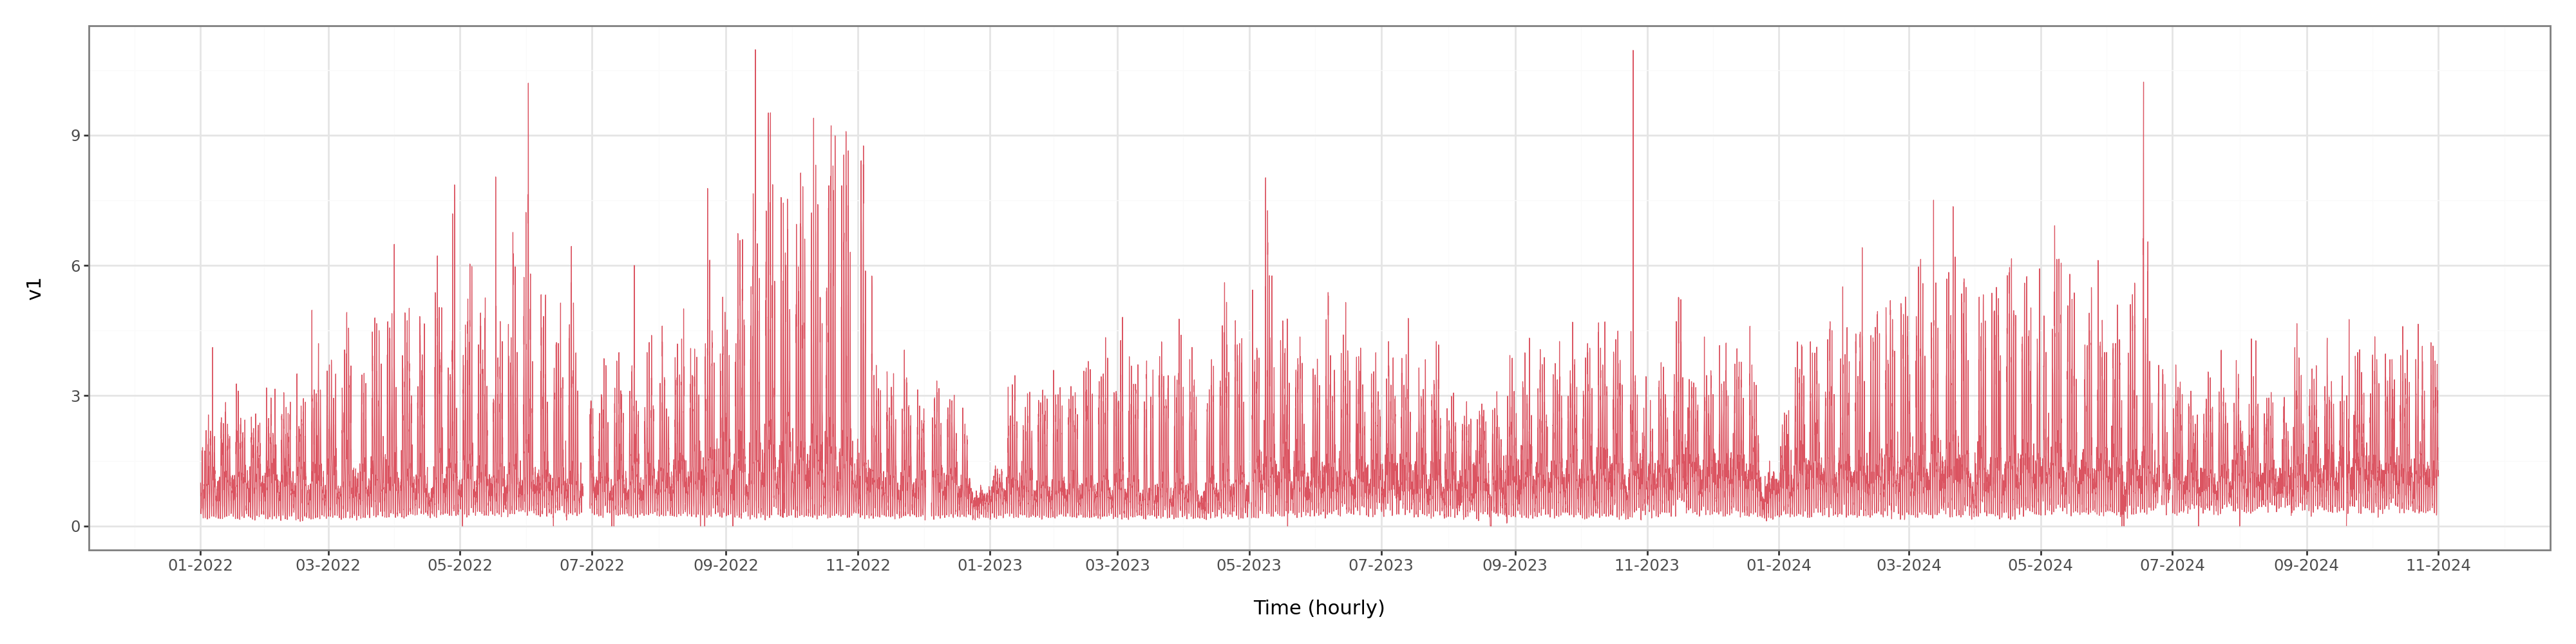

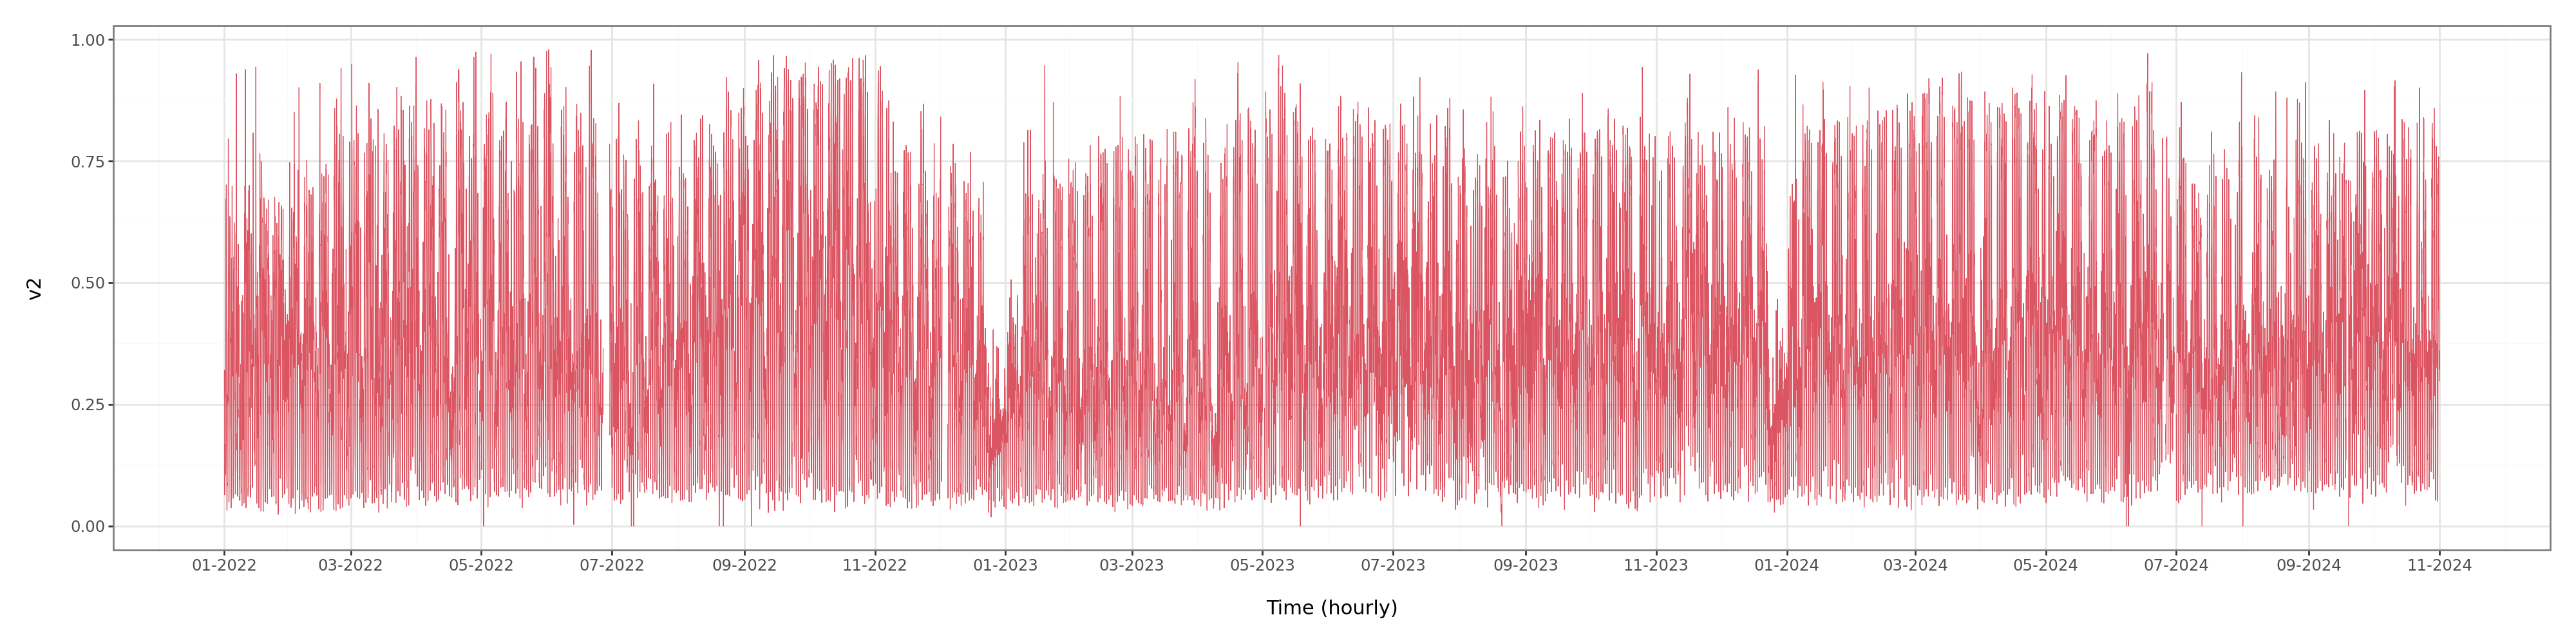

In [16]:
display(
    ggplot(data, aes(x='ts', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
    + scale_x_datetime(date_breaks='2 month', date_labels='%m-%Y')
)

display(
    ggplot(data, aes(x='ts', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
    + scale_x_datetime(date_breaks='2 month', date_labels='%m-%Y')
)

We can also assess the lack of trend claim more formally, that is with a LOWESS plot added to the chart. As we can see, the LOWESS-trend estimates are very close to a simple horizontal line.

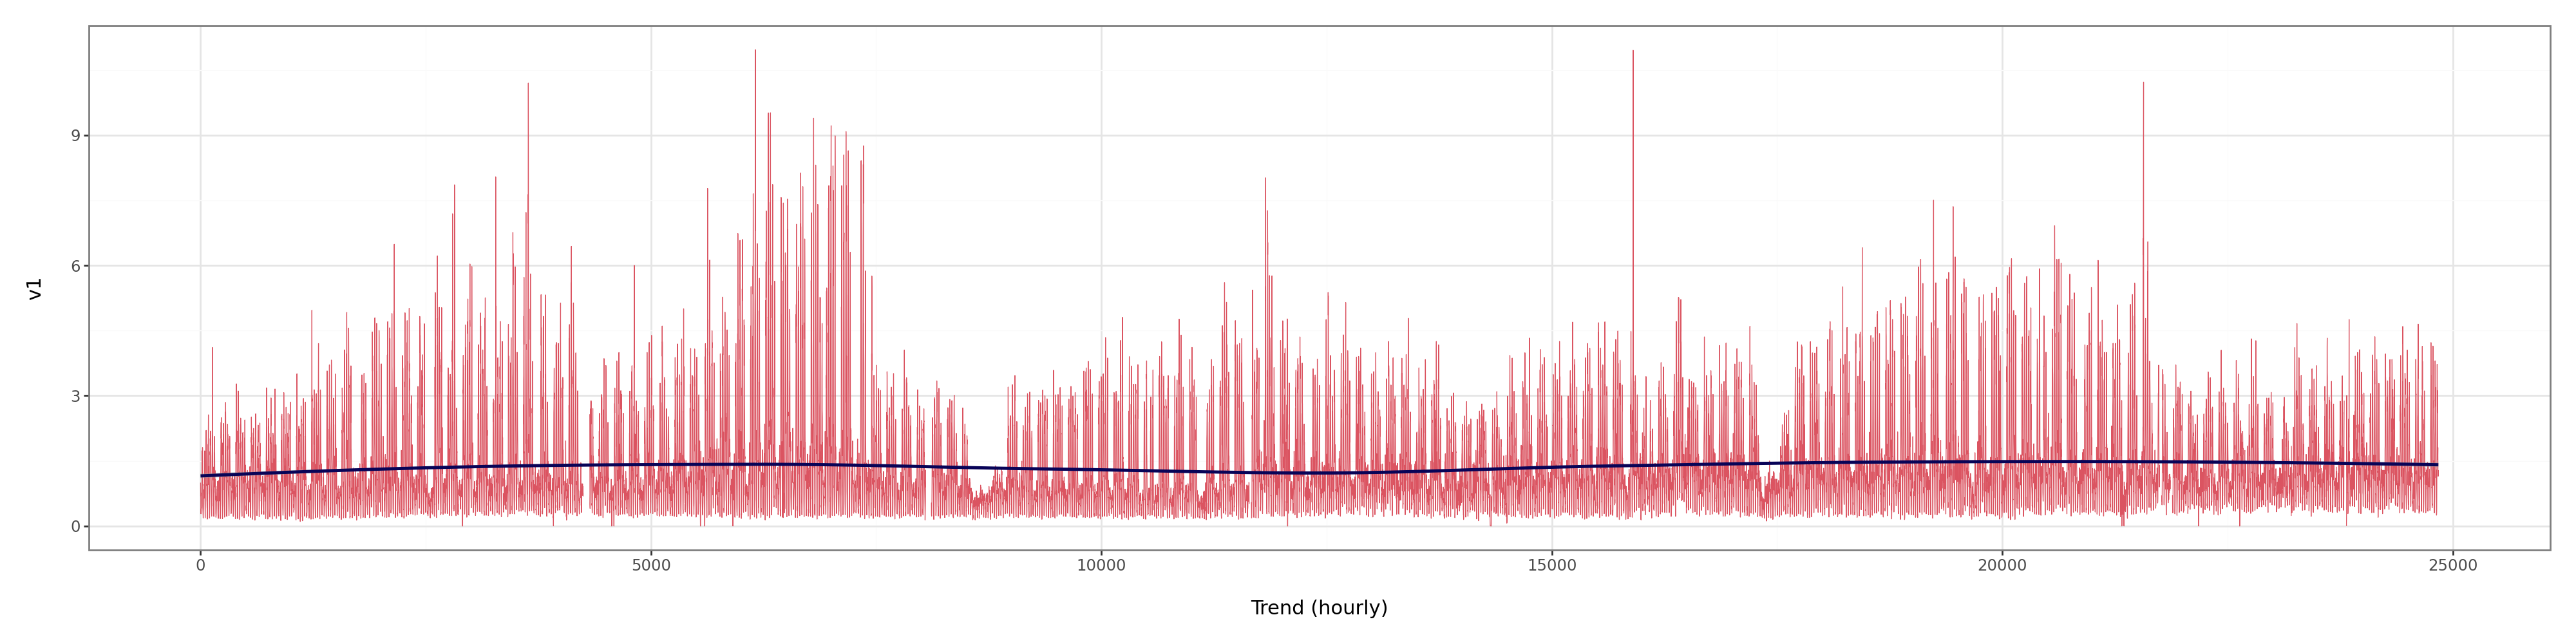

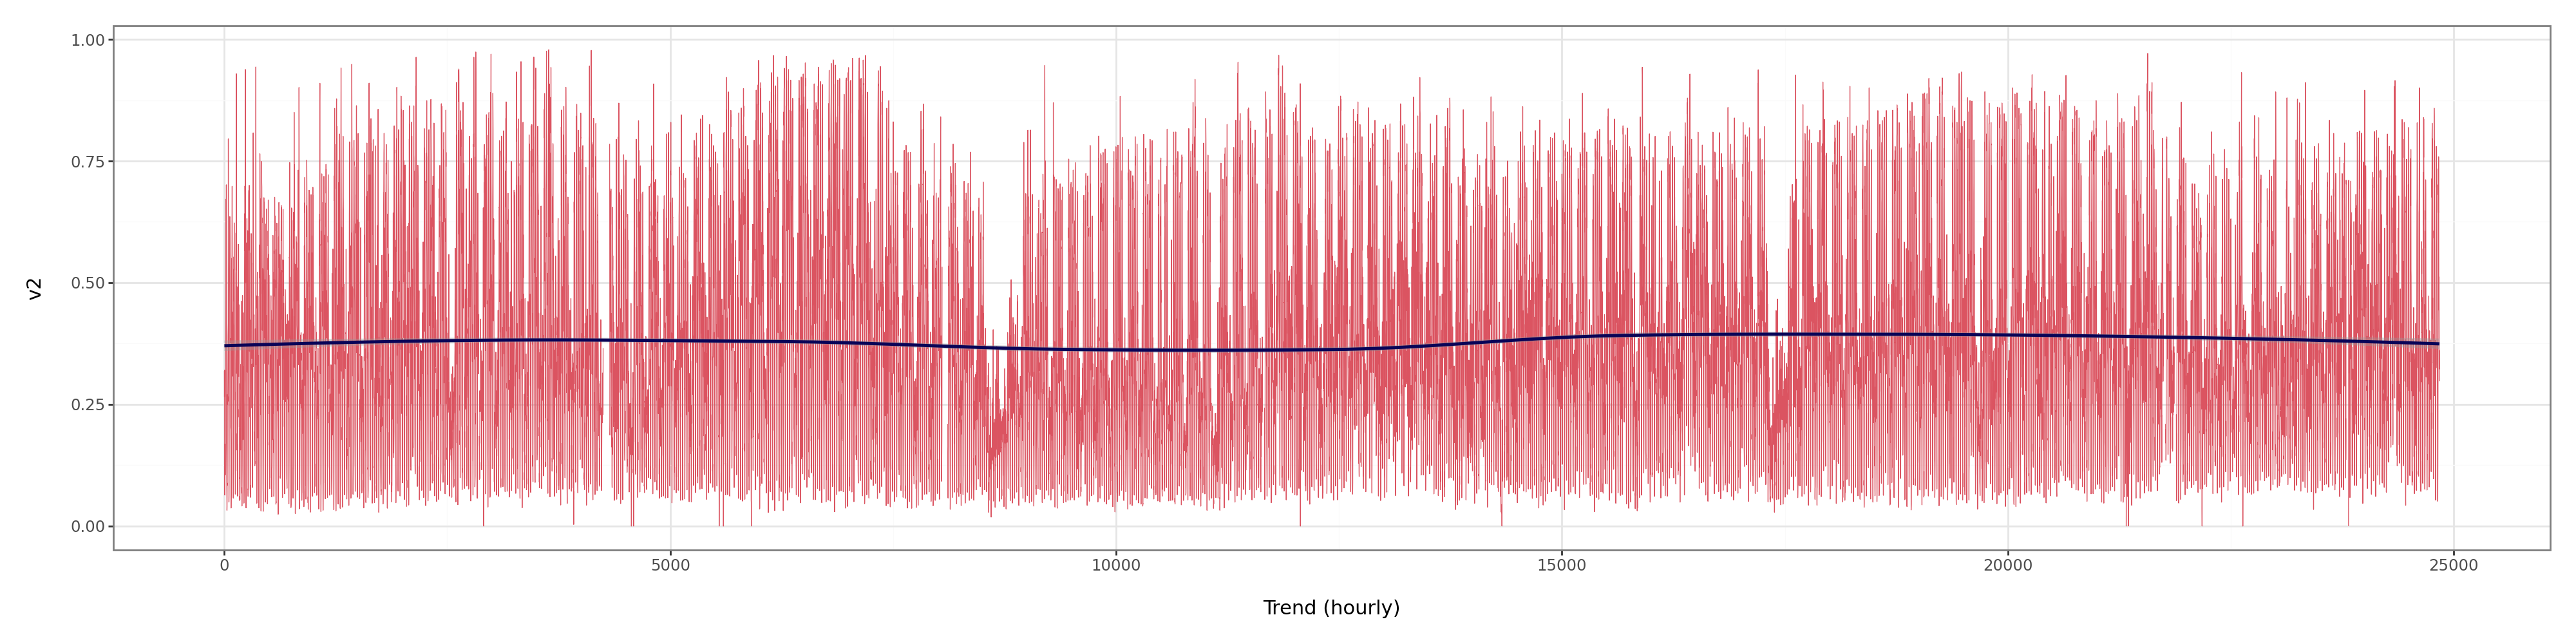

In [18]:
display(
    ggplot(data, aes(x='trend', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + geom_smooth(method='loess', color=color[1], size=1)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Trend (hourly)')
)

display(
    ggplot(data, aes(x='trend', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + geom_smooth(method='loess', color=color[1], size=1)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Trend (hourly)')
)

Let's look at only one year, 2023 now. As we can see, there are weekly fluctuations in both series, with a clear drop around the winter holidays. However, there is hardly any monthly seasonality.

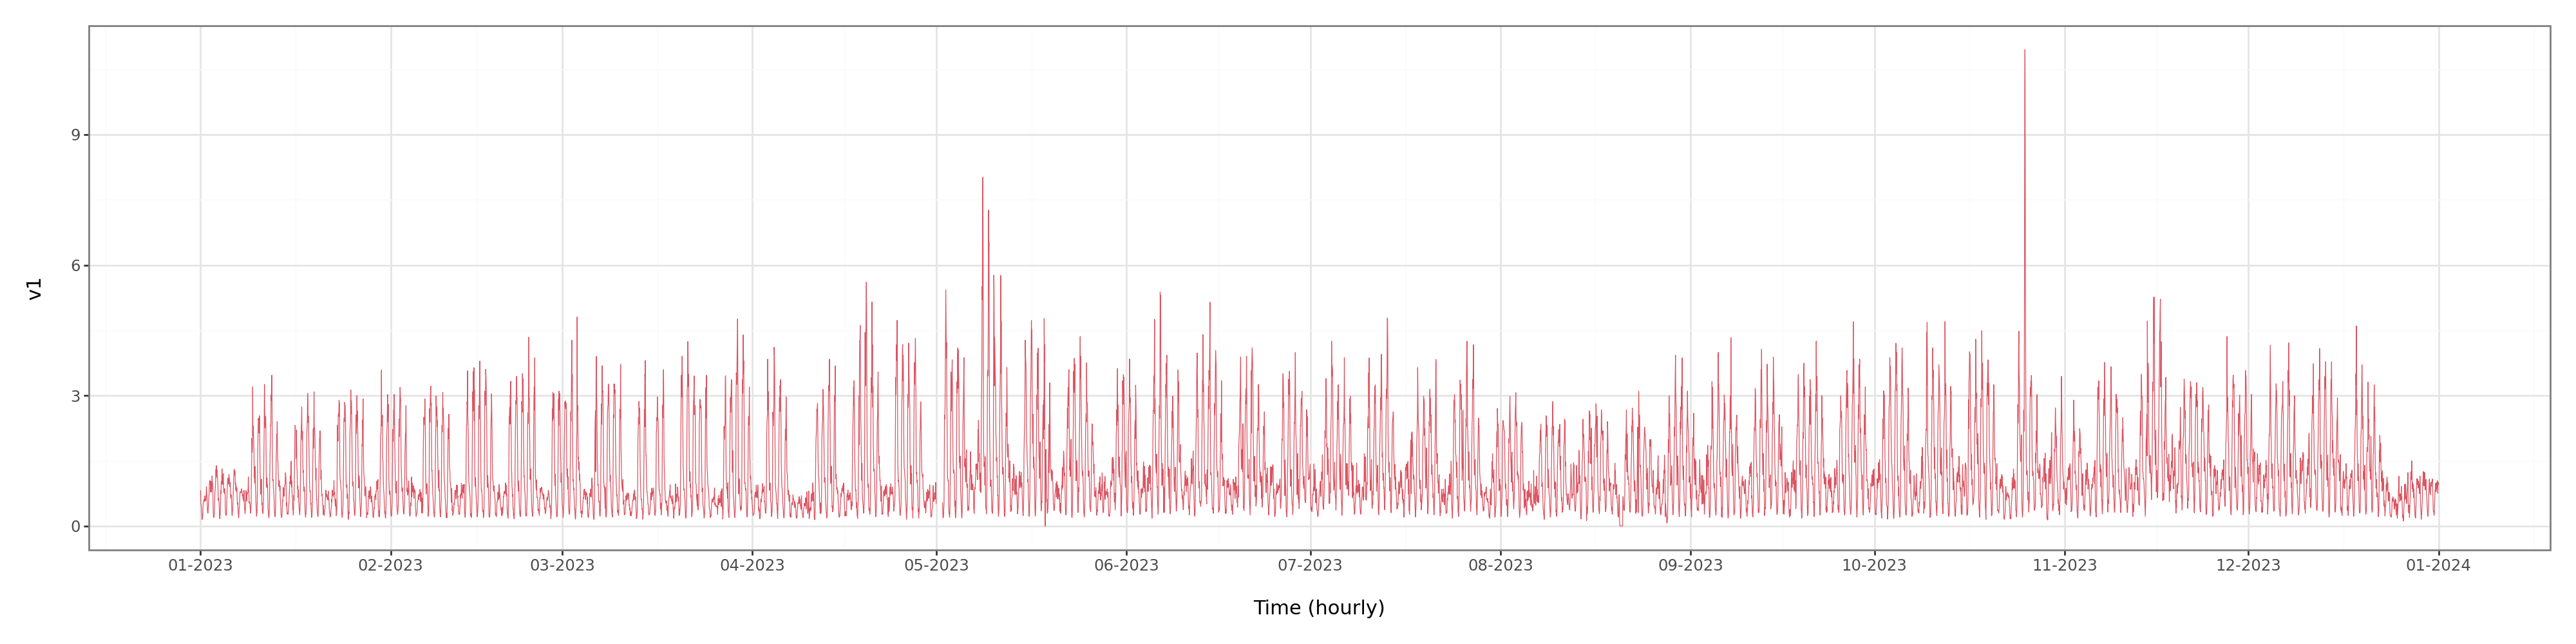

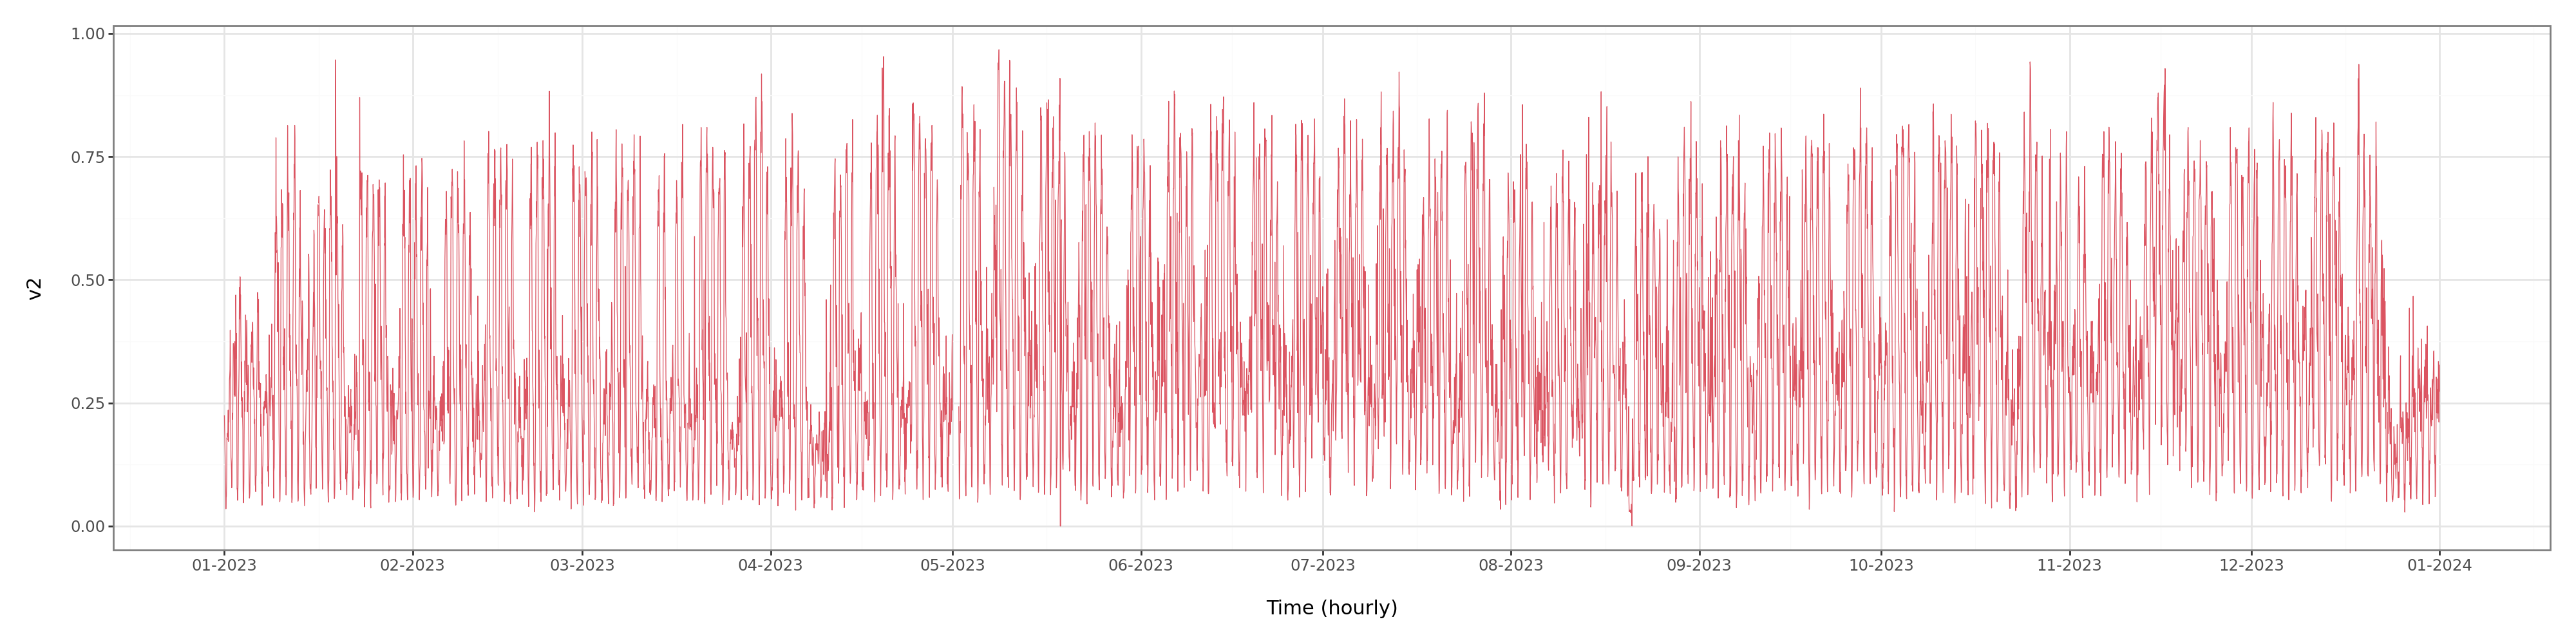

In [19]:
display(
    ggplot(data[data['year'] == 2023], aes(x='ts', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
    + scale_x_datetime(date_breaks='1 month', date_labels='%m-%Y')
)
display(
    ggplot(data[data['year'] == 2023], aes(x='ts', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
    + scale_x_datetime(date_breaks='1 month', date_labels='%m-%Y')
)

Let's move one unit down again: a specific month, June of 2023. Now we can see that there is daily seasonality in both series as well, with a clear distinction between weekdays and weekends.

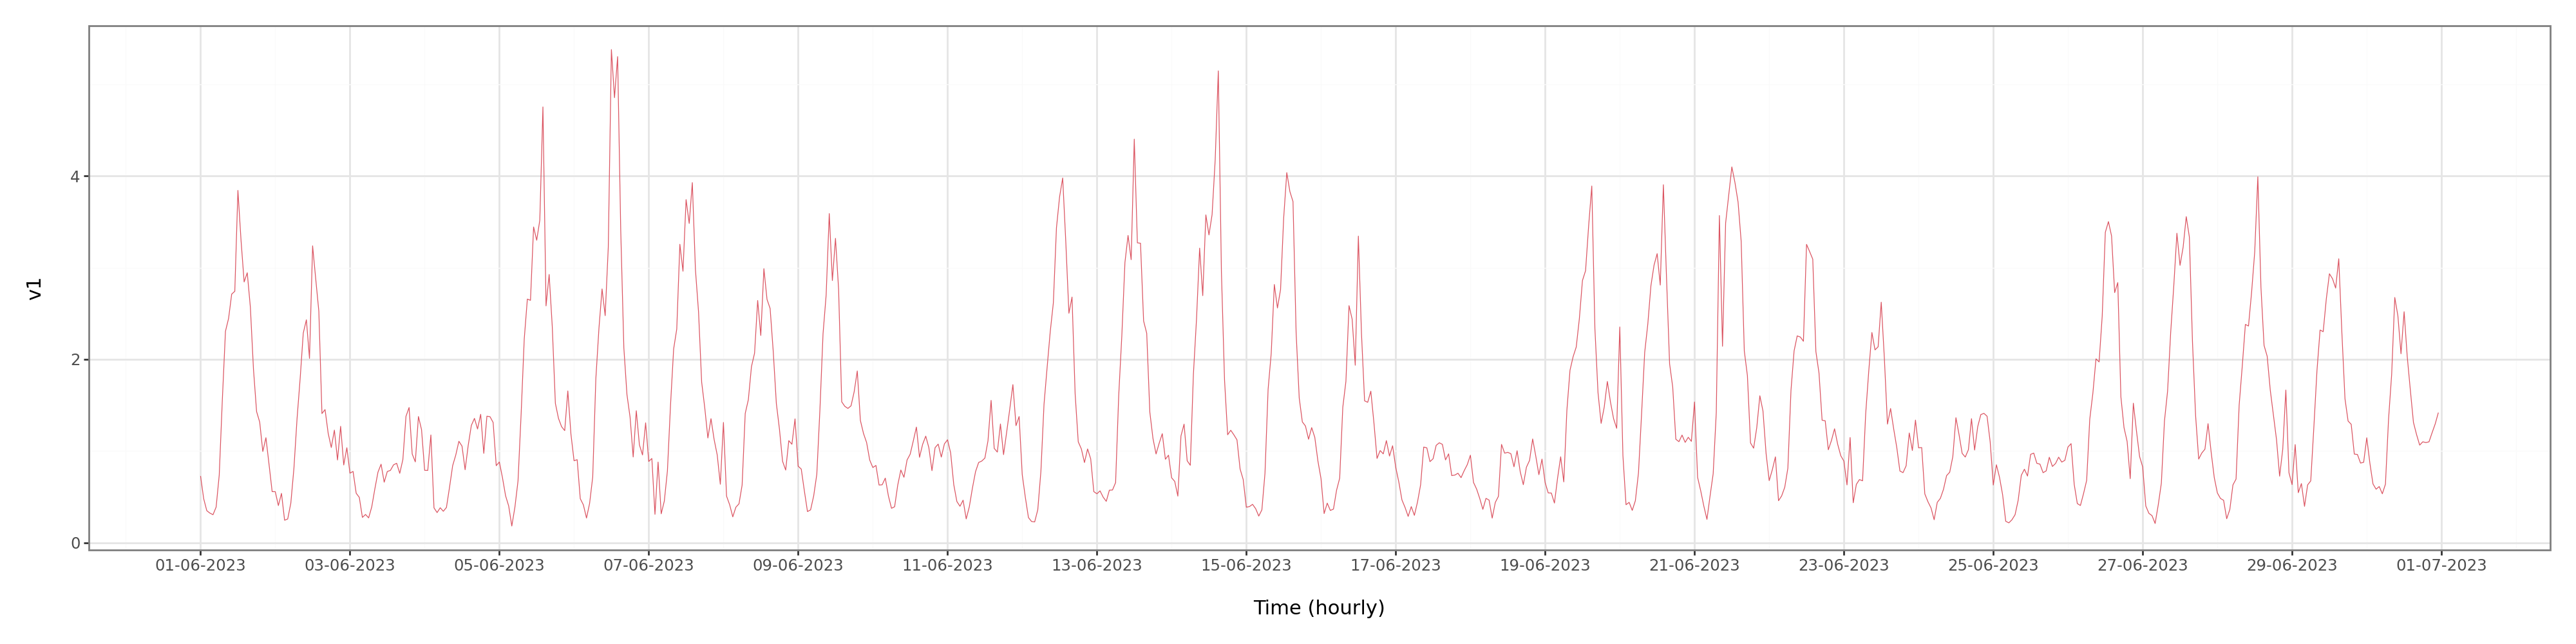

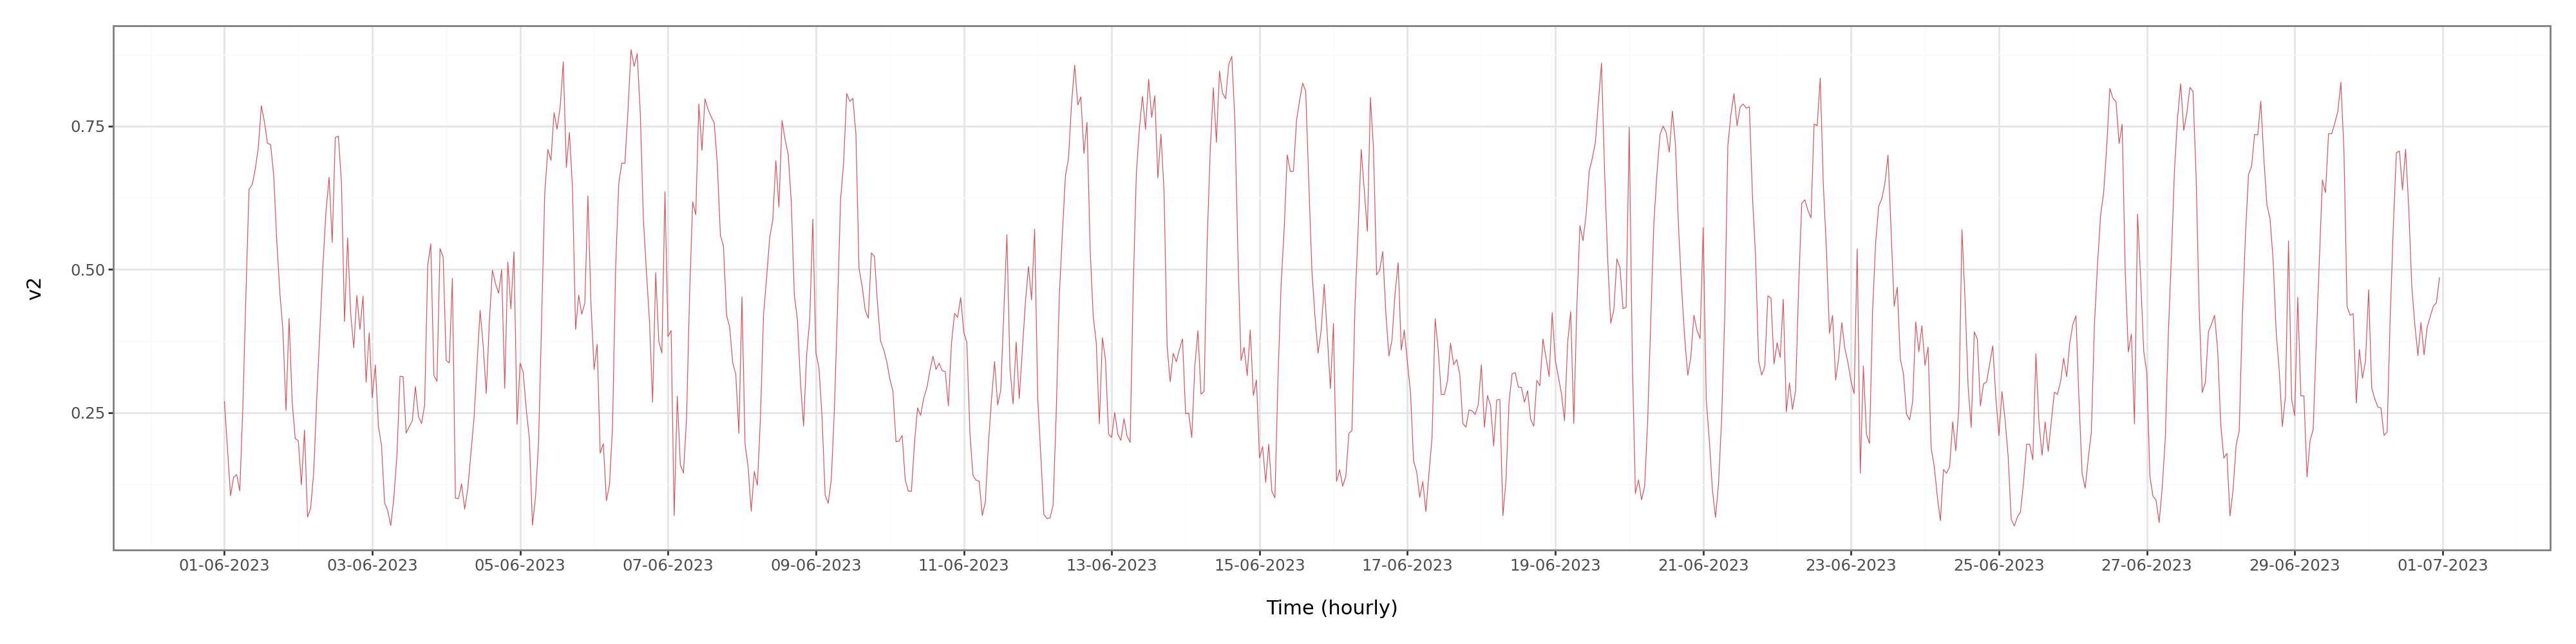

In [22]:
display(
    ggplot(data[(data['year'] == 2023) & (data['month'] == 6)], aes(x='ts', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
    + scale_x_datetime(date_breaks='2 day', date_labels='%d-%m-%Y')
)
display(
    ggplot(data[(data['year'] == 2023) & (data['month'] == 6)], aes(x='ts', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
    + scale_x_datetime(date_breaks='2 day', date_labels='%d-%m-%Y')
)

Let's look at a specific day as well! We can see an hourly seasonality, with peaks during working hours, and drops outside in both series.

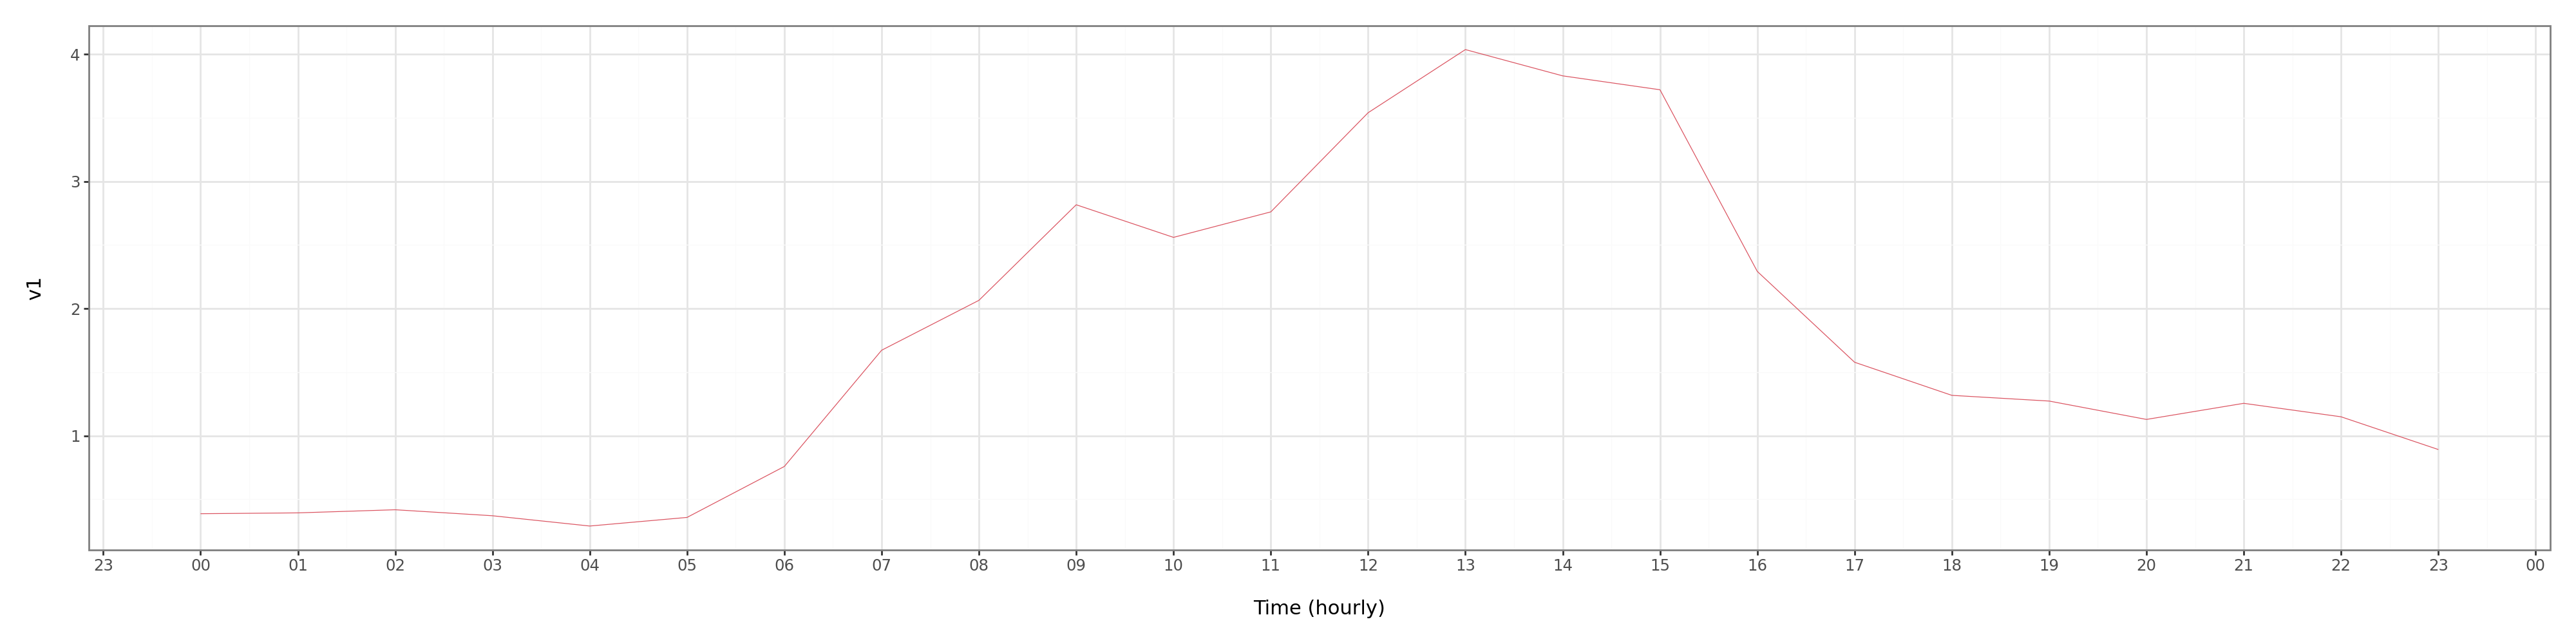

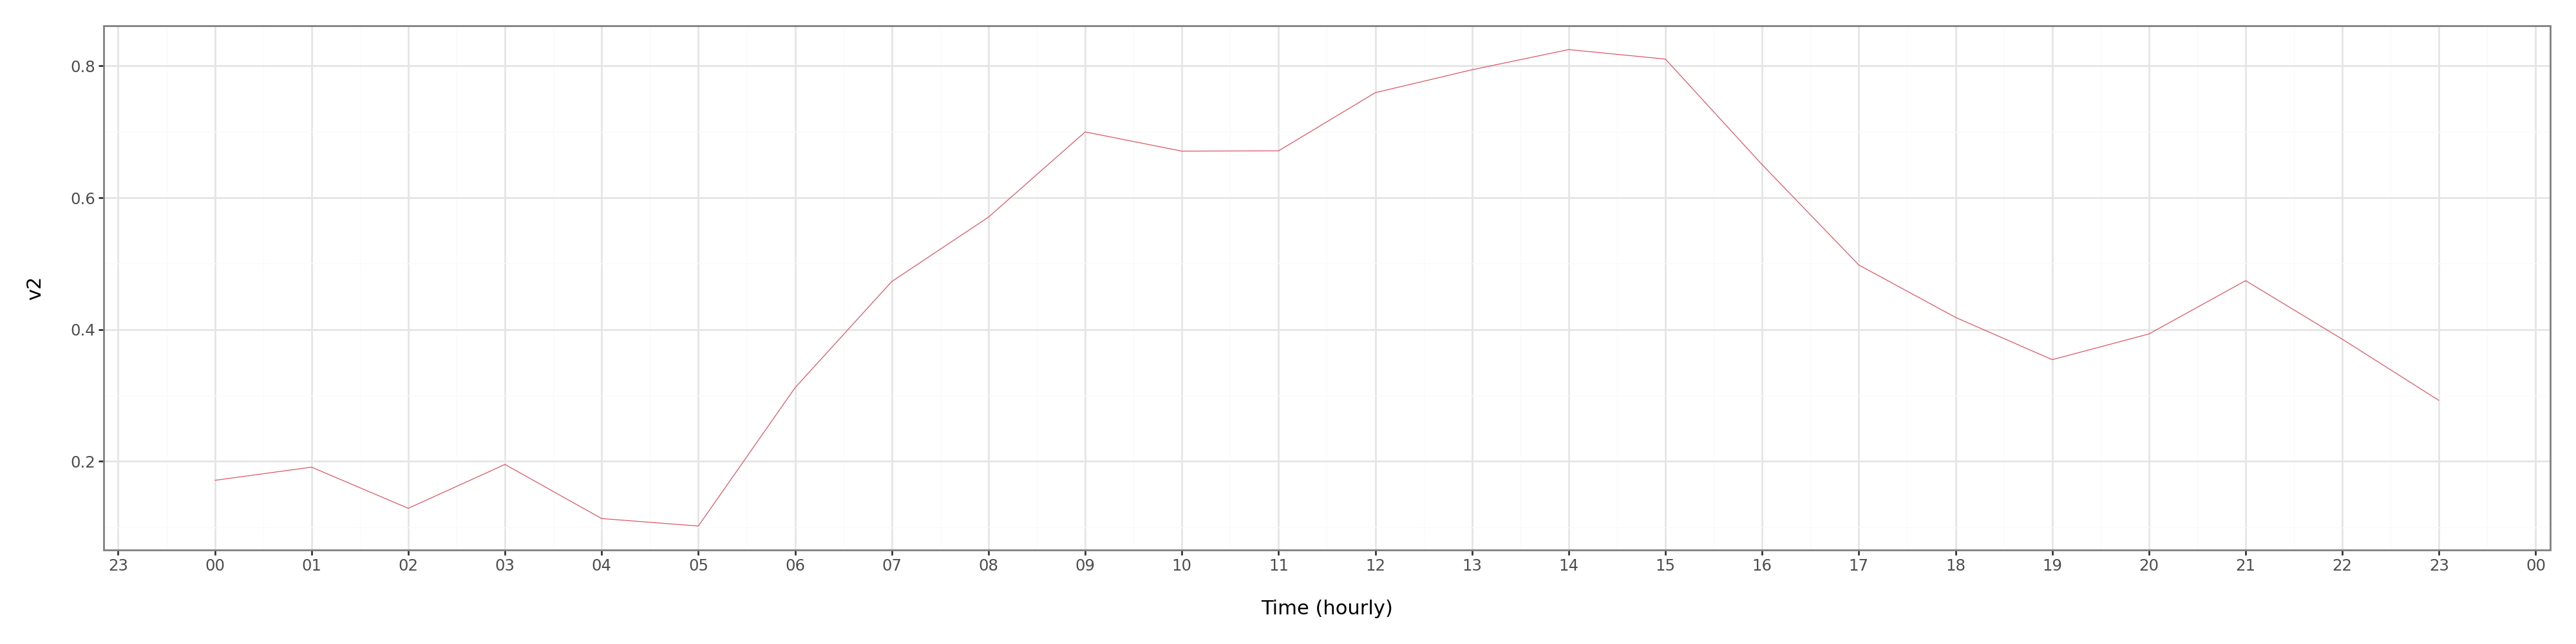

In [23]:
display(
    ggplot(data[(data['year'] == 2023) & (data['month'] == 6) & (data['day'] == 15)], aes(x='ts', y='v1'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + scale_x_datetime(date_breaks='1 hour', date_labels='%H')
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)
display(
    ggplot(data[(data['year'] == 2023) & (data['month'] == 6) & (data['day'] == 15)], aes(x='ts', y='v2'))
    + geom_line(color=color[0], size=0.25)
    + theme_bw()
    + scale_x_datetime(date_breaks='1 hour', date_labels='%H')
    + theme(figure_size=(20, 5))
    + labs(x='Time (hourly)')
)

Looking at the overall distribution of the series, we can see left-skewed distributions, espacially for `v1`. This might prompt us to log transform the series, or to simply winsorize extreme values. This can also been seen from the summary statistics.

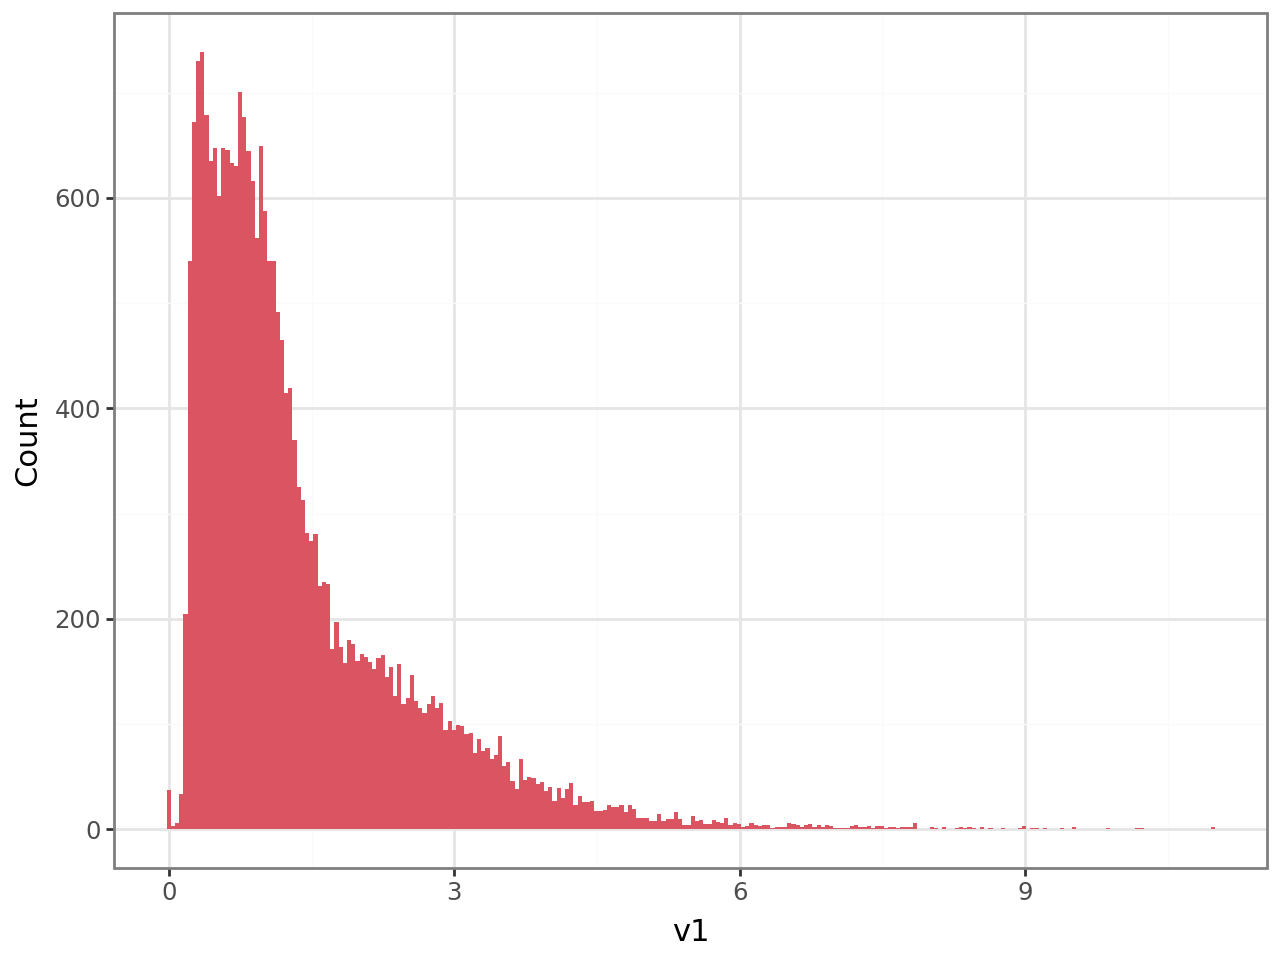

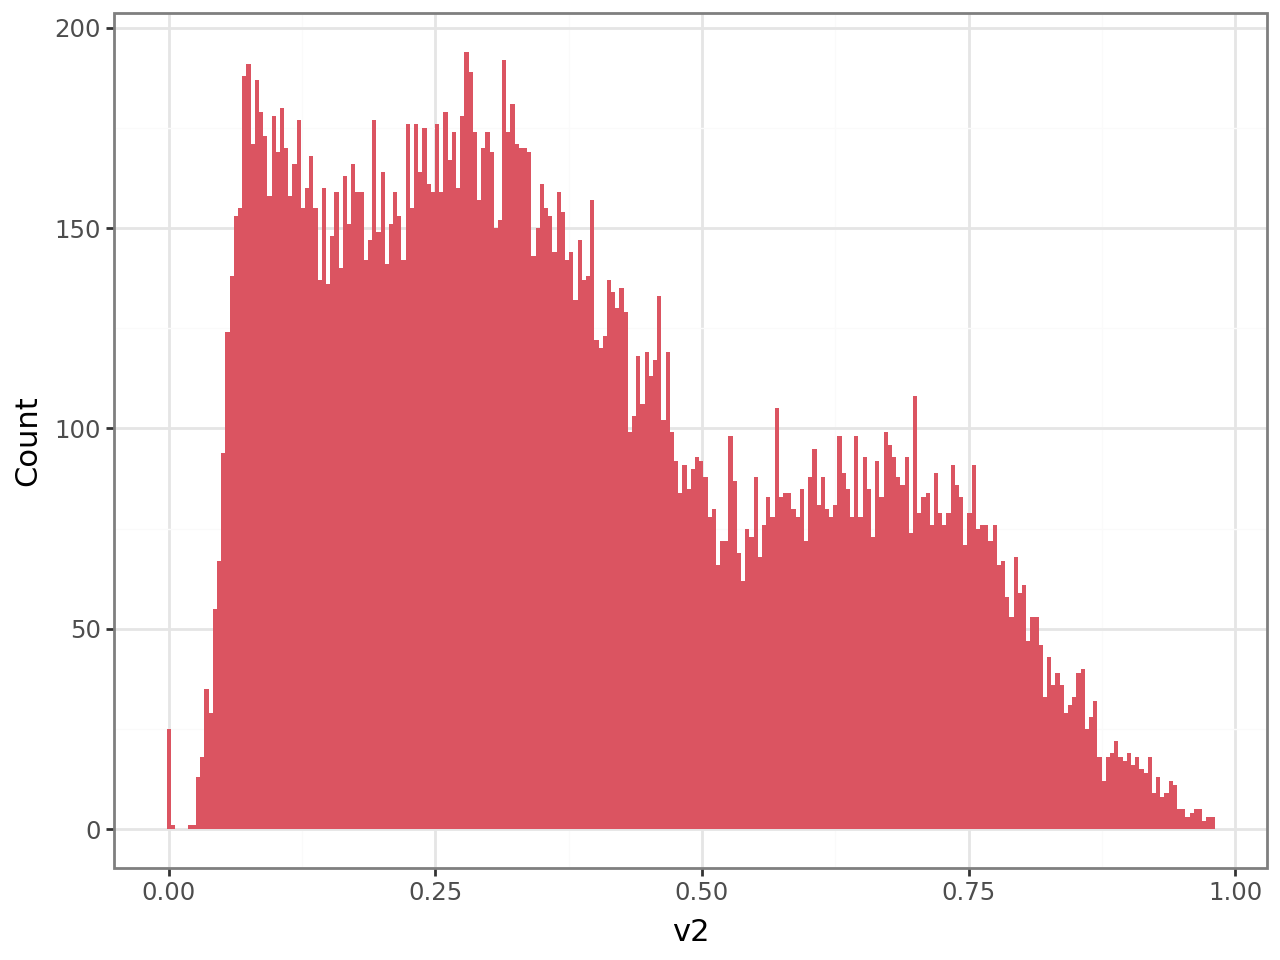

In [167]:
display(
    ggplot(data, aes(x = 'v1'))
    + geom_histogram(fill=color[0], color=None, bins=250)
    + theme_bw()
    + labs(y = 'Count')
)

display(
    ggplot(data, aes(x = 'v2'))
    + geom_histogram(fill=color[0], color=None, bins=250)
    + theme_bw()
    + labs(y = 'Count')
)

In [10]:
data[['v1', 'v2', 'v1_imputed', 'v2_imputed']].describe(percentiles=[0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.90, 0.95, 0.99, 0.995]).T.round(4)

count    mean     std  min    0.5%      1%      5%     10%  \
v1          24592.0  1.3858  1.1546  0.0  0.1712  0.1933  0.2694  0.3433   
v2          24592.0  0.3808  0.2261  0.0  0.0413  0.0492  0.0756  0.1033   
v1_imputed  24840.0  1.3843  1.1512  0.0  0.1713  0.1934  0.2698  0.3439   
v2_imputed  24840.0  0.3806  0.2256  0.0  0.0414  0.0494  0.0758  0.1035   

               25%     50%     75%     90%     95%     99%   99.5%      max  
v1          0.5927  1.0170  1.8211  2.9795  3.6918  5.3872  6.3057  10.9699  
v2          0.1949  0.3399  0.5543  0.7239  0.7864  0.8881  0.9158   0.9789  
v1_imputed  0.5941  1.0183  1.8150  2.9708  3.6850  5.3804  6.3008  10.9699  
v2_imputed  0.1953  0.3399  0.5528  0.7230  0.7859  0.8879  0.9154   0.9789

As we have zeros in both series, we have to be careful with the log-transformation. One possible approach for this is the take the log `x+1` instead of simply `x`, making every value strictly positive. After the transformation, the distributions are much closer to normal.

In [11]:
data['ln_v1'] = data['v1'].apply(lambda x: np.nan if pd.isna(x) else np.log1p(x))
data['ln_v2'] = data['v2'].apply(lambda x: np.nan if pd.isna(x) else np.log1p(x))
data['ln_v1_imputed'] = np.log1p(data['v1_imputed'])
data['ln_v2_imputed'] = np.log1p(data['v2_imputed'])

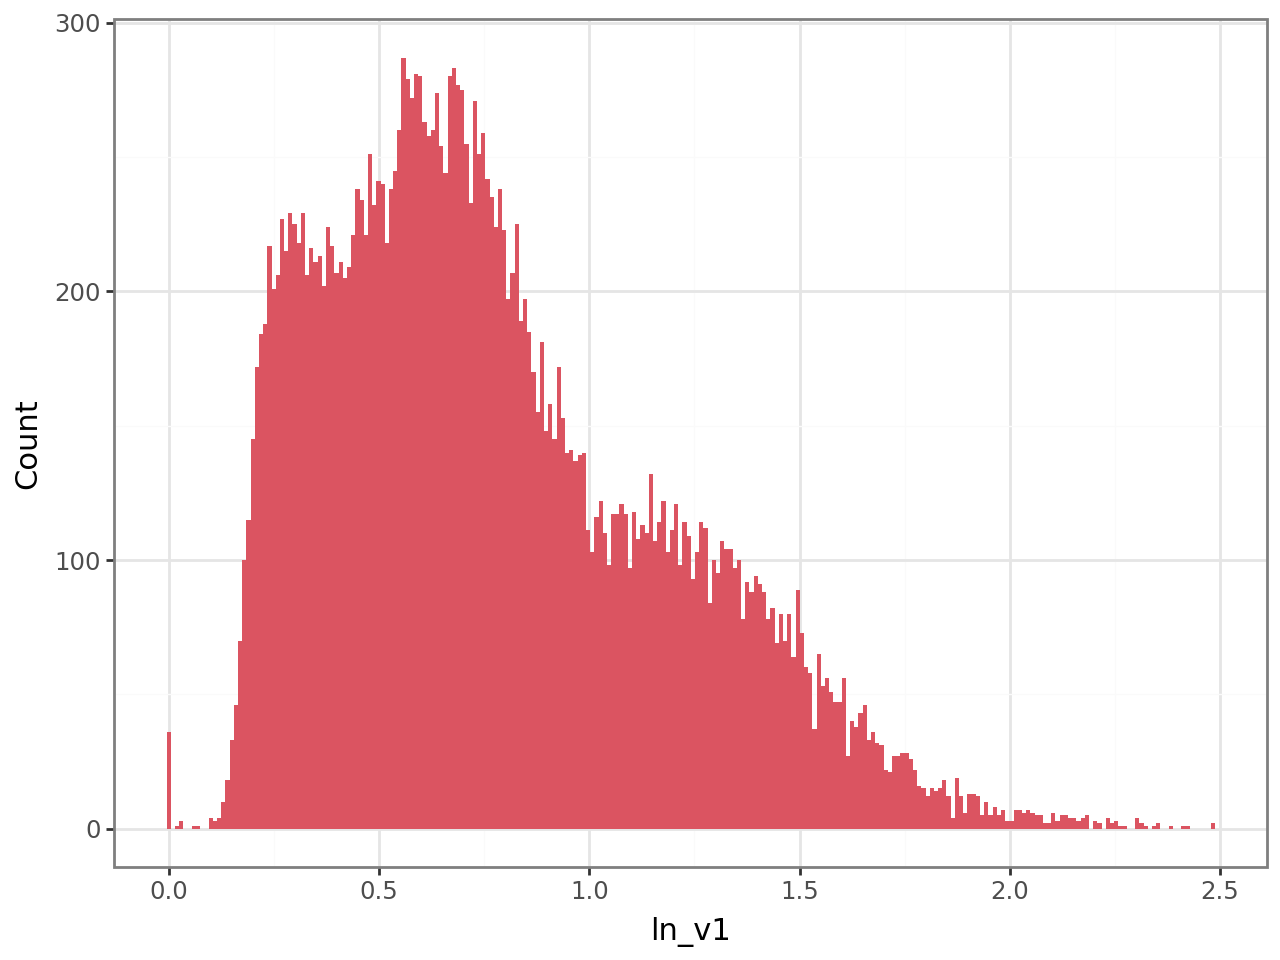

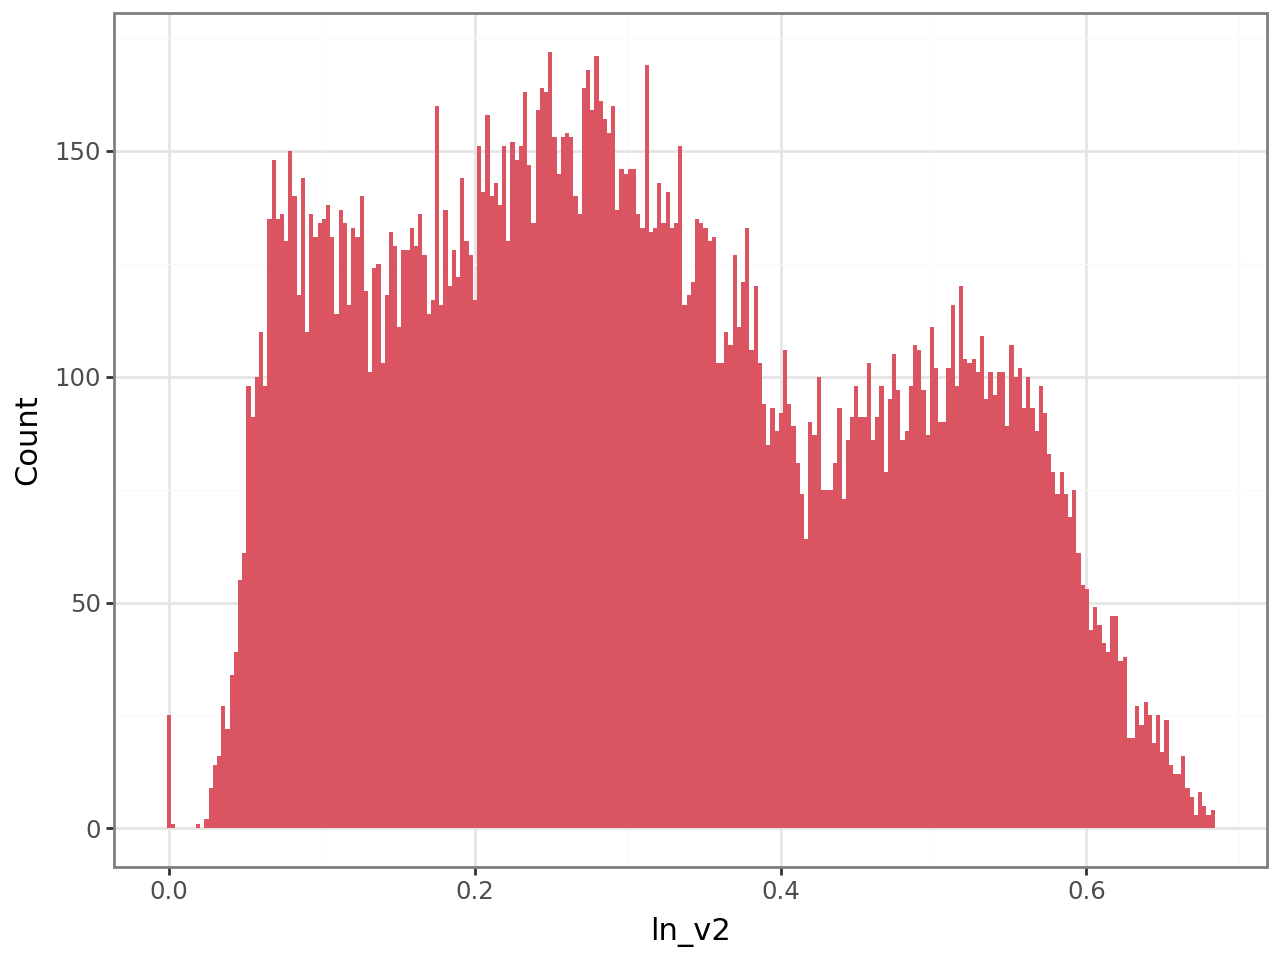

In [26]:
display(
    ggplot(data, aes(x = 'ln_v1'))
    + geom_histogram(fill=color[0], color=None, bins=250)
    + theme_bw()
    + labs(y = 'Count')
)

display(
    ggplot(data, aes(x = 'ln_v2'))
    + geom_histogram(fill=color[0], color=None, bins=250)
    + theme_bw()
    + labs(y = 'Count')
)

I also create winsorized variables with sensible thresholds (0.5% percentile lower bound for both v1 and v2, and 99% percentile upper bound). Moreover, Prophet handles extreme values the best if they are set to simply missing values.

In [12]:
data['wins_v1'] = data['v1'].apply(lambda x:
                                   np.nan
                                   if pd.isna(x)
                                   else (np.nanquantile(data['v1'], 0.99)
                                         if x > np.nanquantile(data['v1'], 0.99)
                                         else (
                                           np.nanquantile(data['v1'], 0.005)
                                           if x < np.nanquantile(data['v1'], 0.005)
                                           else x)))
data['wins_v2'] = data['v2'].apply(lambda x:
                                   np.nan
                                   if pd.isna(x)
                                   else (np.nanquantile(data['v2'], 0.99)
                                         if x > np.nanquantile(data['v2'], 0.99)
                                         else (
                                           np.nanquantile(data['v2'], 0.005)
                                           if x < np.nanquantile(data['v2'], 0.005)
                                           else x)))

# same thresholds as above for consistency
data['wins_v1_imputed'] = data['v1_imputed'].apply(lambda x:
                                                    np.nan
                                                    if pd.isna(x)
                                                    else (np.nanquantile(data['v1'], 0.99)
                                                            if x > np.nanquantile(data['v1'], 0.99)
                                                            else (
                                                            np.nanquantile(data['v1'], 0.005)
                                                            if x < np.nanquantile(data['v1'], 0.005)
                                                            else x)))
data['wins_v2_imputed'] = data['v2_imputed'].apply(lambda x:
                                                    np.nan
                                                    if pd.isna(x)
                                                    else (np.nanquantile(data['v2'], 0.99)
                                                            if x > np.nanquantile(data['v2'], 0.99)
                                                            else (
                                                            np.nanquantile(data['v2'], 0.005)
                                                            if x < np.nanquantile(data['v2'], 0.005)
                                                            else x)))

data['proph_v1'] = data['v1'].apply(lambda x:
                                   np.nan
                                   if pd.isna(x)
                                   else (np.nan
                                         if x > np.nanquantile(data['v1'], 0.99)
                                         else (
                                           np.nan
                                           if x < np.nanquantile(data['v1'], 0.005)
                                           else x)))
data['proph_v2'] = data['v2'].apply(lambda x:
                                   np.nan
                                   if pd.isna(x)
                                   else (np.nan
                                         if x > np.nanquantile(data['v2'], 0.99)
                                         else (
                                           np.nan
                                           if x < np.nanquantile(data['v2'], 0.005)
                                           else x)))

In [ ]:
'''cols = ['v1', 'v2', 'ln_v1', 'ln_v2', 'v1_imputed', 'v2_imputed', 
        'ln_v1_imputed', 'ln_v2_imputed', 'wins_v1', 'wins_v2', 
        'wins_v1_imputed', 'wins_v2_imputed', 'proph_v1', 'proph_v2']

data[[f'd_{col}' for col in cols]] = data[cols].diff()'''

To examine whether there is a need for actually using differences in my analysis, I clean the series from trends, hourly, weekly and monthly seasonality, and calculate the ADF stationarity test on the residuals. This shows that the series are stationary after being cleaned from the above factors, thus using differences may be unnecessary. I also test for serial correlation in the residuals - as there is significant serial correlation, I will experiment later with ARIMA models. I also test the Granger-causality between the two residuals: the results show that usin VAR models is unnecessary, as there is no Granger-causality in neither direction

In [13]:
df_v1 = data[['ts', 'v1_imputed']].rename(columns={'ts': 'ds', 'v1_imputed': 'y'})
df_v2 = data[['ts', 'v2_imputed']].rename(columns={'ts': 'ds', 'v2_imputed': 'y'})

prophet_v1 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, growth='flat')
prophet_v2 = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=True, growth='flat')

prophet_v1.fit(df_v1)
prophet_v2.fit(df_v2)

future = df_v1[['ds']]
forecast_v1 = prophet_v1.predict(future)
forecast_v2 = prophet_v2.predict(future)

df_v1['v1_resid'] = df_v1['y'] - forecast_v1['yhat']
df_v2['v2_resid'] = df_v2['y'] - forecast_v2['yhat']


21:19:24 - cmdstanpy - INFO - Chain [1] start processing
21:19:24 - cmdstanpy - INFO - Chain [1] done processing
21:19:25 - cmdstanpy - INFO - Chain [1] start processing
21:19:26 - cmdstanpy - INFO - Chain [1] done processing


In [14]:
v1_stat_test = adfuller(df_v1['v1_resid'], maxlag=24, regression='c', autolag='AIC', store=False, regresults=False)
v2_stat_test = adfuller(df_v2['v2_resid'], maxlag=24, regression='c', autolag='AIC', store=False, regresults=False)
print('ADF stationarity test:\n    H0: Process is non-stationary (unit root present).\n    H1: Process is stationary.')
print('Note: variables cleaned from daily, weekly and monthly seasonality (assuming no trend) by Prophet, ADF results for residuals.')
print(f'v1 (imputed) p-value: {v1_stat_test[1]:.4f}')
print(f'v2 (imputed) p-value: {v2_stat_test[1]:.4f}')

ADF stationarity test:
    H0: Process is non-stationary (unit root present).
    H1: Process is stationary.
Note: variables cleaned from daily, weekly and monthly seasonality (assuming no trend) by Prophet, ADF results for residuals.
v1 (imputed) p-value: 0.0000
v2 (imputed) p-value: 0.0000


In [15]:
v1_lb_test = acorr_ljungbox(df_v1['v1_resid'], lags=[5], return_df=True)
v2_lb_test = acorr_ljungbox(df_v2['v2_resid'], lags=[5], return_df=True)

print('Ljung-Box test for serial correlation:\n    H0: No serial correlation.\n    H1: Serial correlation present.')
print('Note: variables cleaned from daily, weekly and monthly seasonality (assuming no trend) by Prophet, LB results for residuals.')
print(f'v1 (imputed) p-value: {v1_lb_test["lb_pvalue"].values[0]:.4f}')
print(f'v2 (imputed) p-value: {v2_lb_test["lb_pvalue"].values[0]:.4f}')

Ljung-Box test for serial correlation:
    H0: No serial correlation.
    H1: Serial correlation present.
Note: variables cleaned from daily, weekly and monthly seasonality (assuming no trend) by Prophet, LB results for residuals.
v1 (imputed) p-value: 0.0000
v2 (imputed) p-value: 0.0000


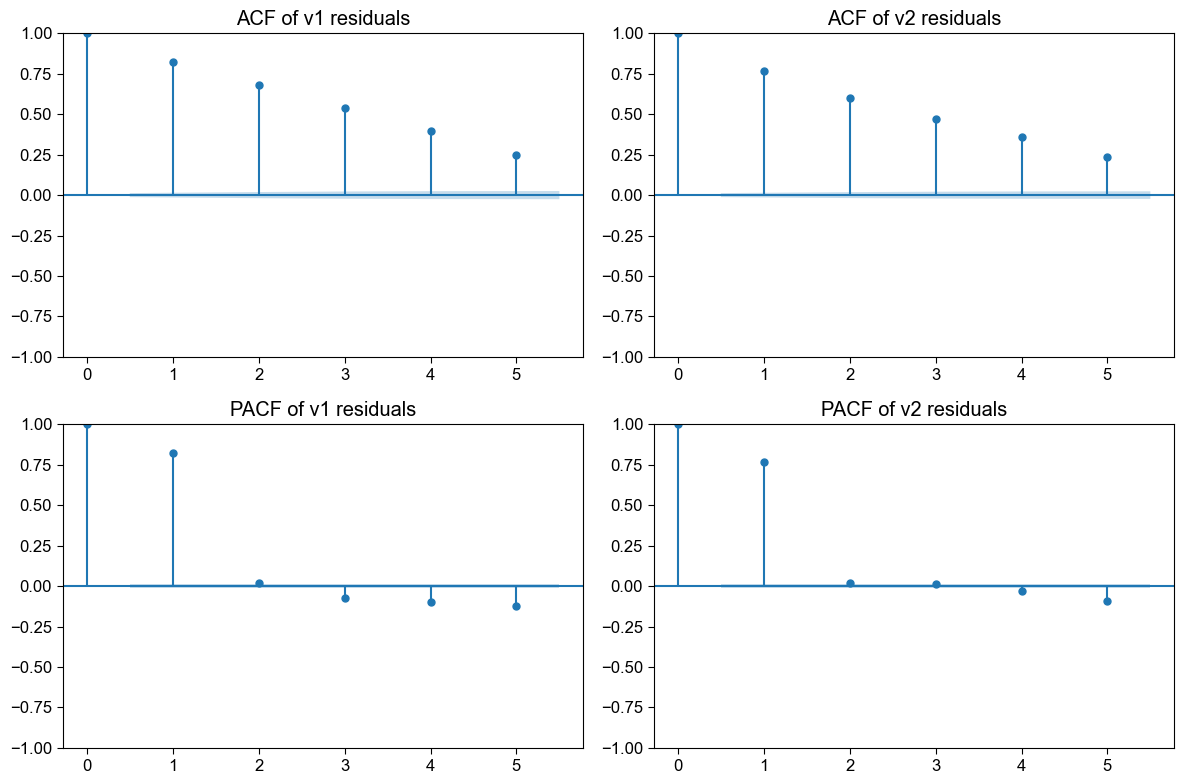

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(df_v1['v1_resid'], lags=5, ax=axes[0, 0])
axes[0, 0].set_title('ACF of v1 residuals')

plot_acf(df_v2['v2_resid'], lags=5, ax=axes[0, 1])
axes[0, 1].set_title('ACF of v2 residuals')

plot_pacf(df_v1['v1_resid'], lags=5, method='yw', ax=axes[1, 0])
axes[1, 0].set_title('PACF of v1 residuals')

plot_pacf(df_v2['v2_resid'], lags=5, method='yw', ax=axes[1, 1])
axes[1, 1].set_title('PACF of v2 residuals')

plt.tight_layout()
plt.show()


In [18]:
print('Granger-causality test (direction v2 -> v1):\n    H0: v2 Granger-causes v1.\n    H1: v2 does not Granger-cause v1.')
print('Note: variables cleaned from daily, weekly and monthly seasonality (assuming no trend) by Prophet, results for residuals.')
v1_v2_granger_test = grangercausalitytests(
    x=pd.concat([df_v1['v1_resid'], df_v2['v2_resid']], axis=1).dropna(),
    maxlag=5,
    verbose=True
)
print('\nGranger-causality test (direction v1 -> v2):\n    H0: v1 Granger-causes v2.\n    H1: v1 does not Granger-cause v2.')
print('Note: variables cleaned from daily, weekly and monthly seasonality (assuming no trend) by Prophet, results for residuals.')
v2_v1_granger_test = grangercausalitytests(
    x=pd.concat([df_v2['v2_resid'], df_v1['v1_resid']], axis=1).dropna(),
    maxlag=5,
    verbose=True
)

Granger-causality test (direction v2 -> v1):
    H0: v2 Granger-causes v1.
    H1: v2 does not Granger-cause v1.
Note: variables cleaned from daily, weekly and monthly seasonality (assuming no trend) by Prophet, results for residuals.

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=56.9872 , p=0.0000  , df_denom=24836, df_num=1
ssr based chi2 test:   chi2=56.9940 , p=0.0000  , df=1
likelihood ratio test: chi2=56.9288 , p=0.0000  , df=1
parameter F test:         F=56.9872 , p=0.0000  , df_denom=24836, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=31.6264 , p=0.0000  , df_denom=24833, df_num=2
ssr based chi2 test:   chi2=63.2655 , p=0.0000  , df=2
likelihood ratio test: chi2=63.1851 , p=0.0000  , df=2
parameter F test:         F=31.6264 , p=0.0000  , df_denom=24833, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=28.8930 , p=0.0000  , df_denom=24830, df_num=3
ssr based chi2 test:   chi2=86.7

Let's examine further the seasonality present in the series. First, let's look at boxplots broken down by certain time categories - these may be more informative than simply looking at a randomly chosen instance of them.

The monthly boxplots suggest that there is a very slight monthly seasonality in both cases.

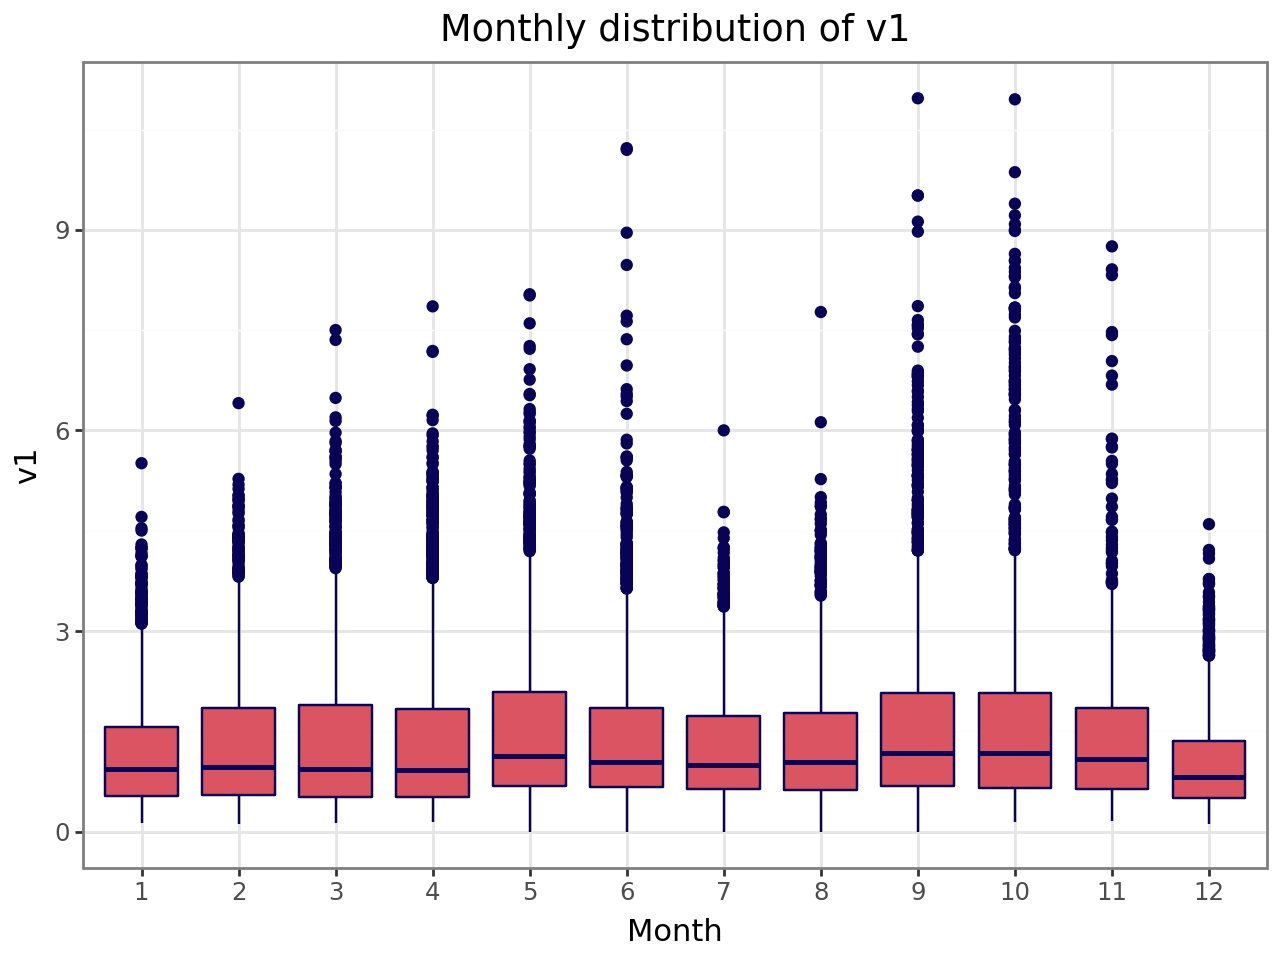

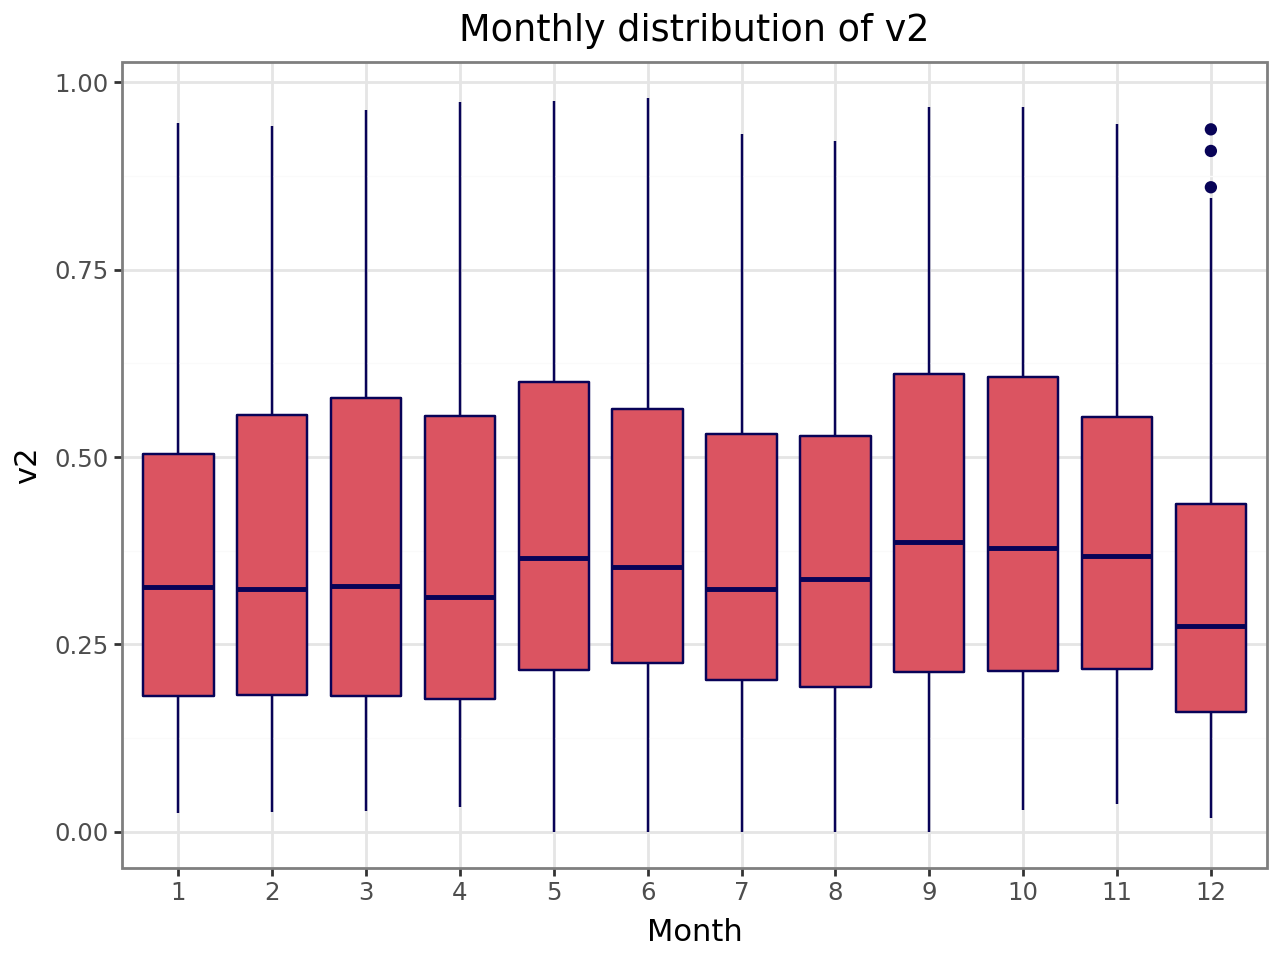

In [48]:
display(
    ggplot(data, aes(x='month.astype("category")', y = 'v1'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = range(1, 13))
    + labs(x = 'Month', title = 'Monthly distribution of v1')
)

display(
    ggplot(data, aes(x='month.astype("category")', y = 'v2'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = range(1, 13))
    + labs(x = 'Month', title = 'Monthly distribution of v2')
)

Moreover, there is no difference in distributions by the day of the month.

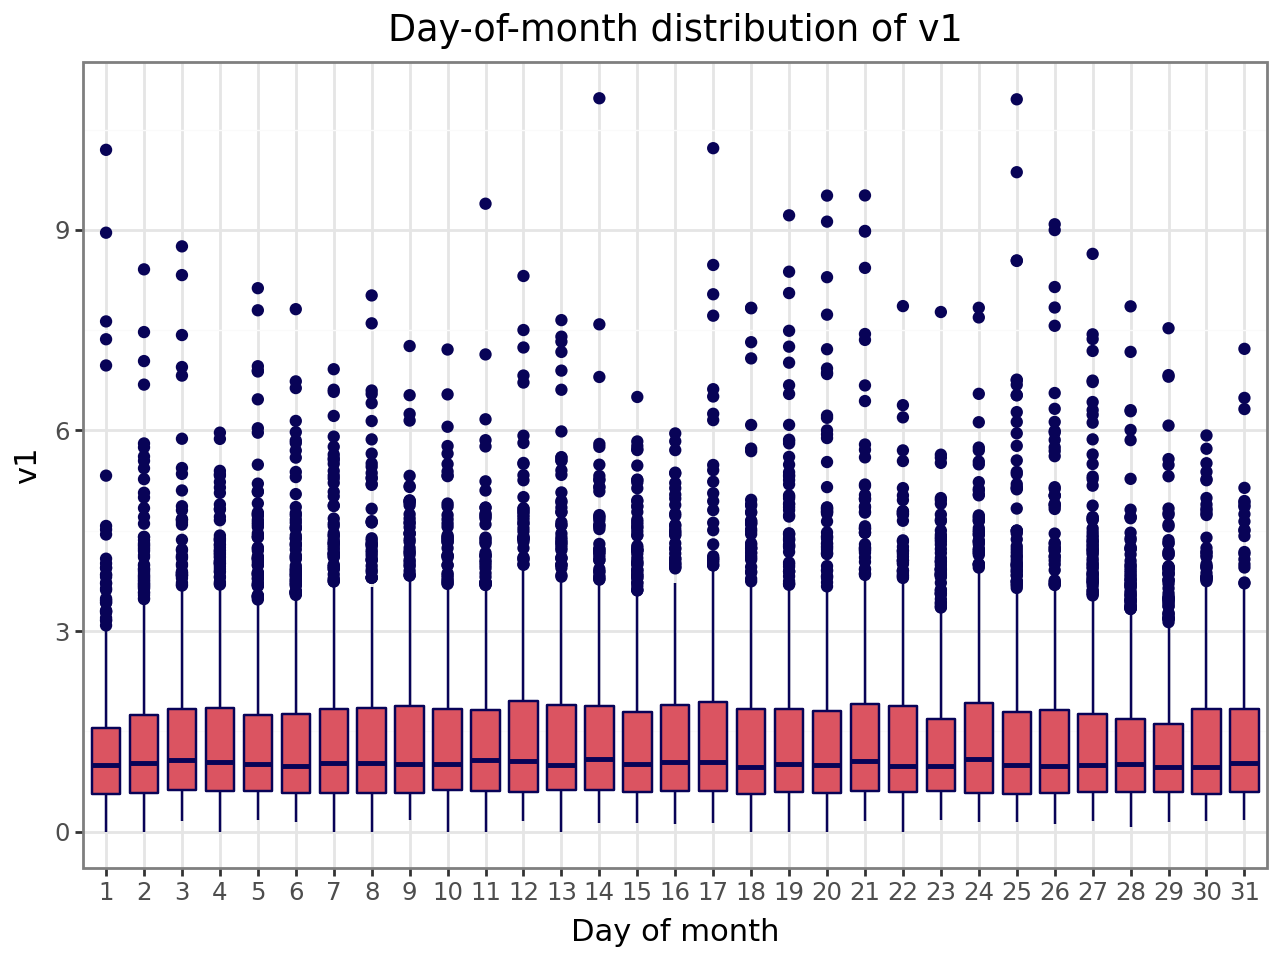

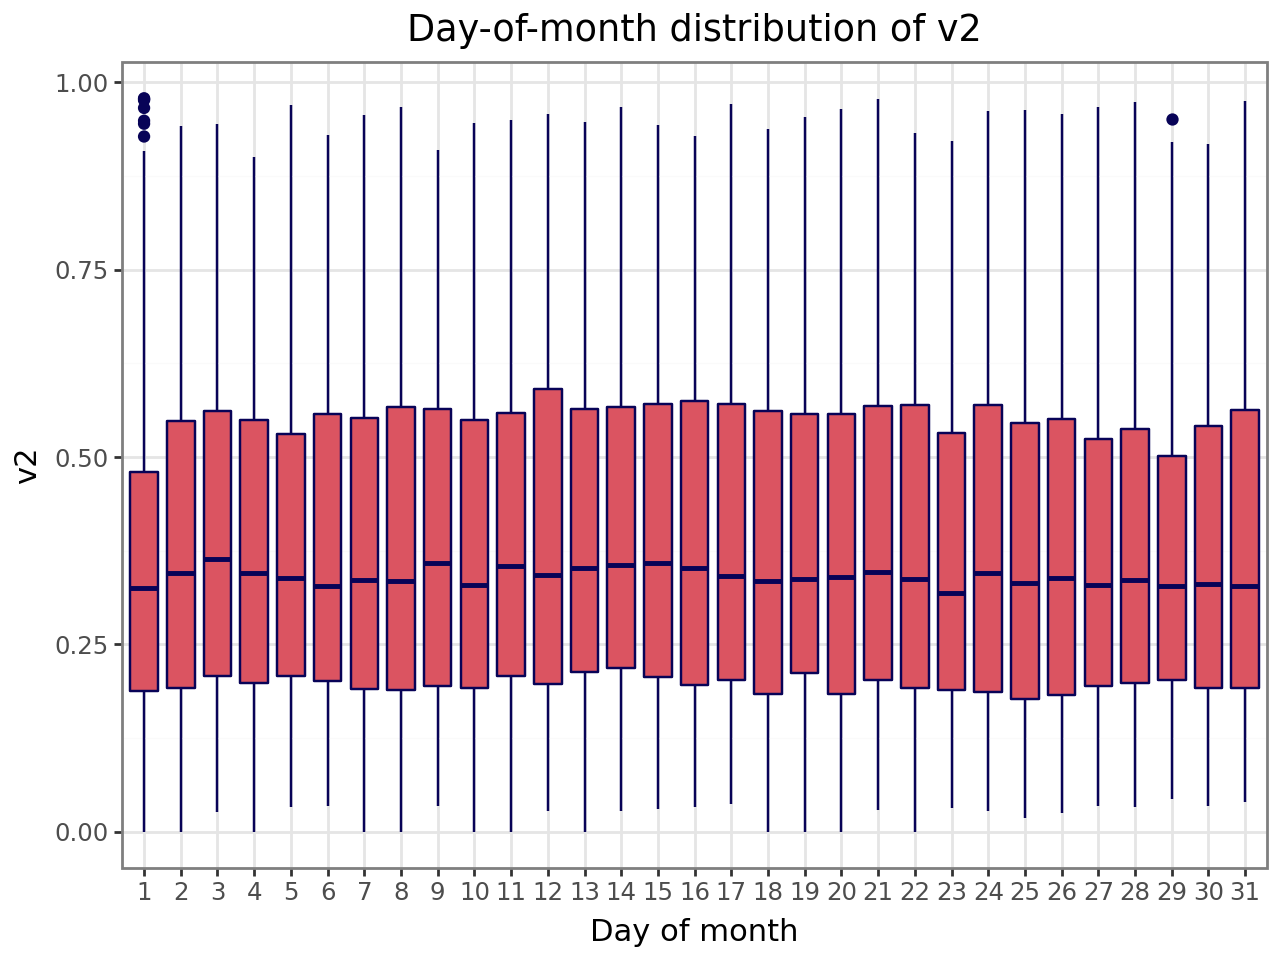

In [50]:
display(
    ggplot(data, aes(x='day.astype("category")', y = 'v1'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = range(1, 32))
    + labs(x = 'Day of month', title = 'Day-of-month distribution of v1')
)

display(
    ggplot(data, aes(x='day.astype("category")', y = 'v2'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = range(1, 32))
    + labs(x = 'Day of month', title = 'Day-of-month distribution of v2')
)

Regarding the day of the week, distributions are rather similar from Monday to Thursday. However, there is a slight drop in the mean on Friday, and weekends are very different for both series.

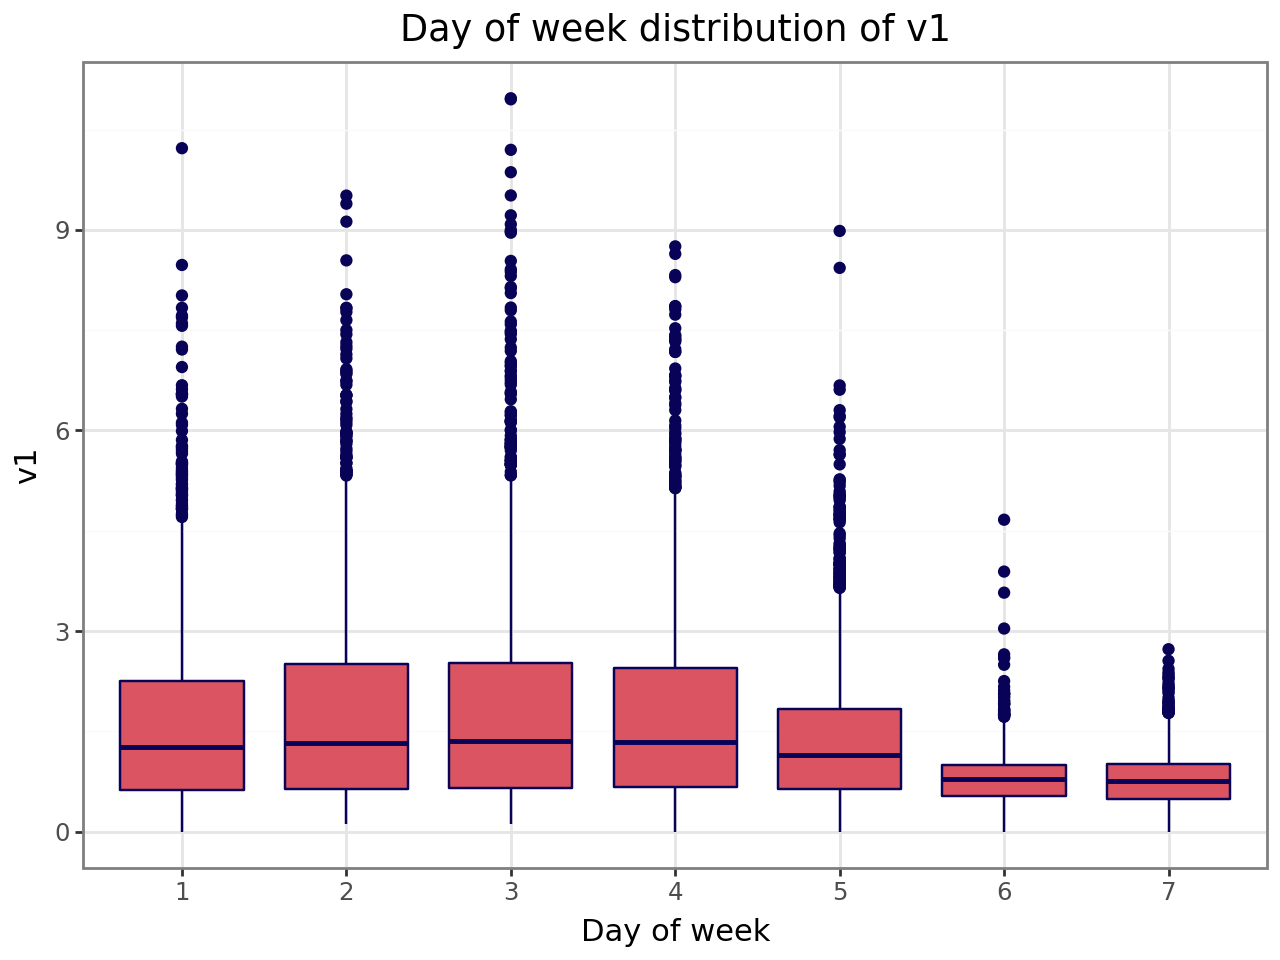

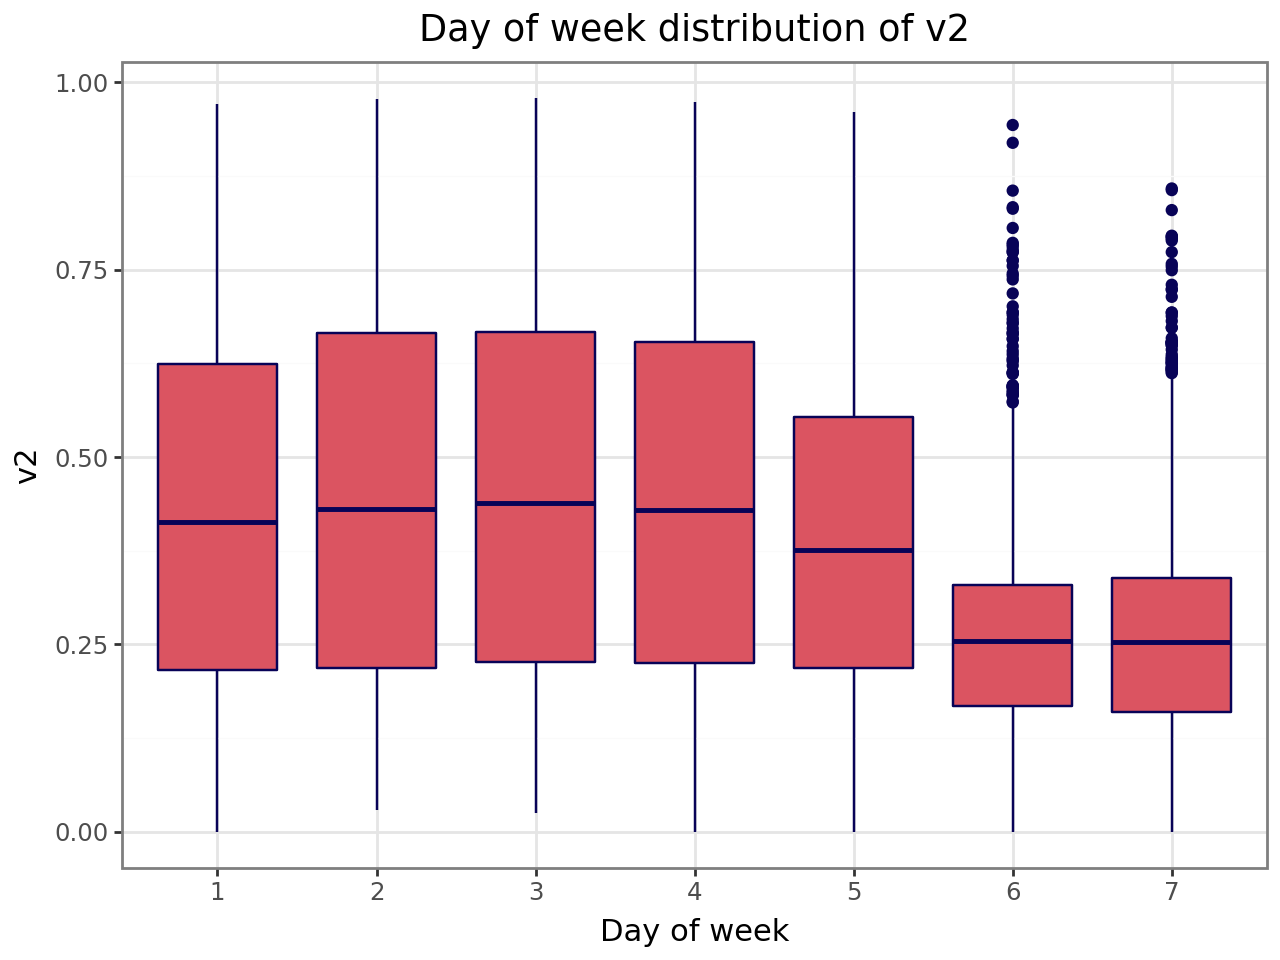

In [52]:
display(
    ggplot(data, aes(x='dow.astype("category")', y = 'v1'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = range(1, 8))
    + labs(x = 'Day of week', title = 'Day of week distribution of v1')
)

display(
    ggplot(data, aes(x='dow.astype("category")', y = 'v2'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = range(1, 8))
    + labs(x = 'Day of week', title = 'Day of week distribution of v2')
)

The above can also be shown if we simply look at the distributions by the weekend dummy.

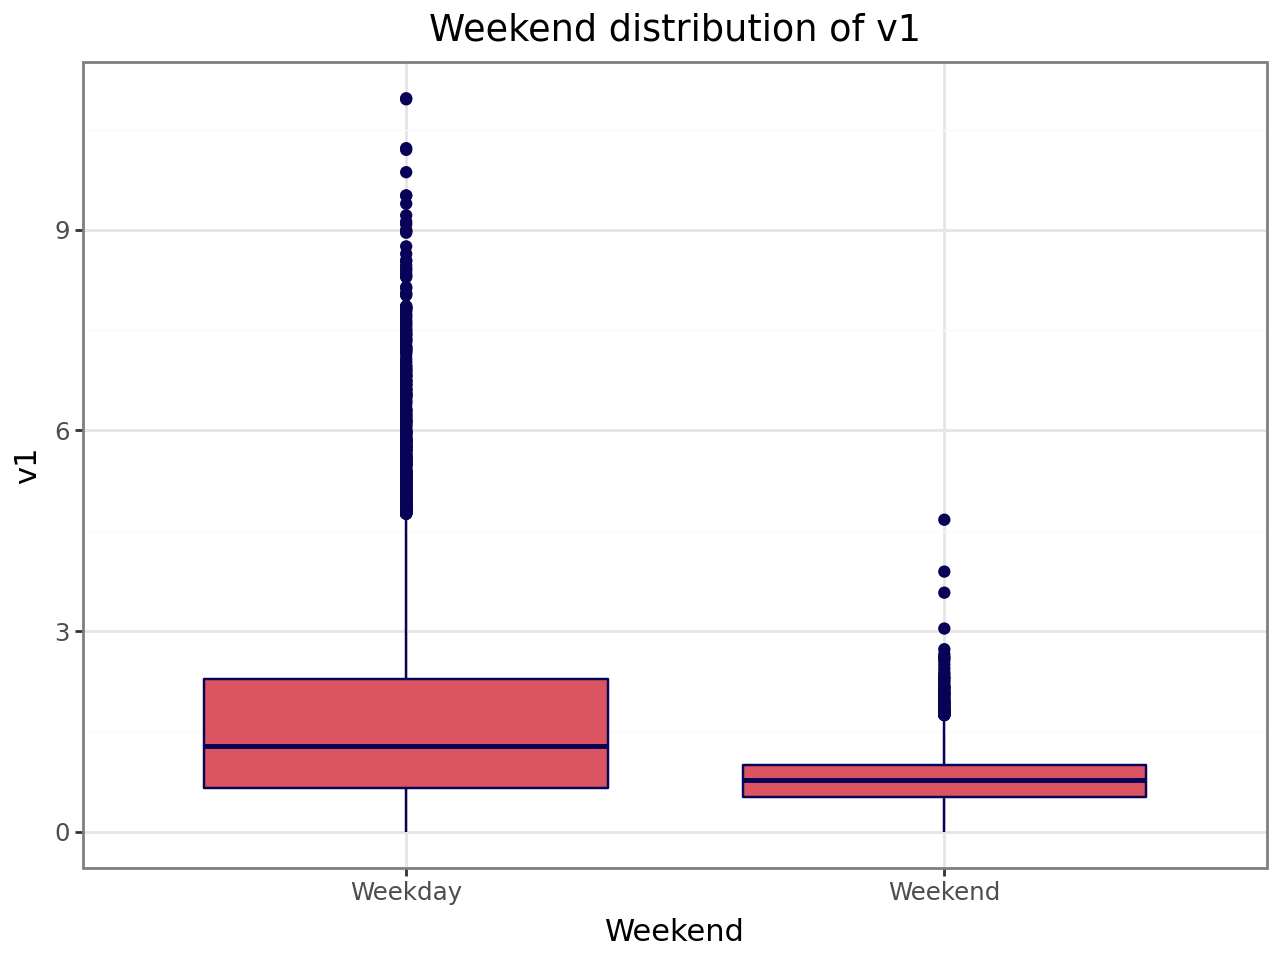

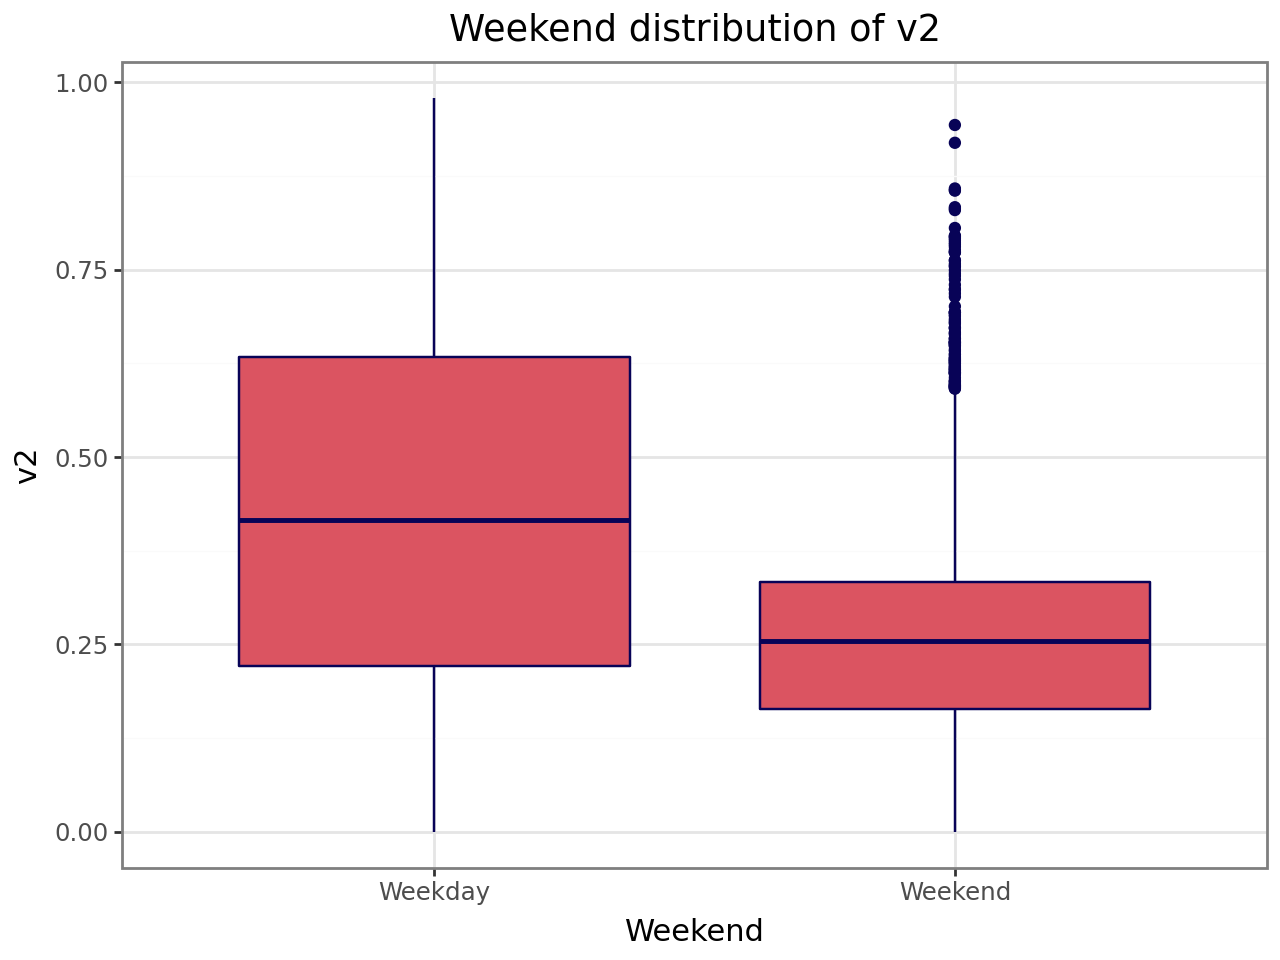

In [57]:
display(
    ggplot(data, aes(x='weekend.astype("category")', y = 'v1'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = ['Weekday', 'Weekend'])
    + labs(x = 'Weekend', title = 'Weekend distribution of v1')
)

display(
    ggplot(data, aes(x='weekend.astype("category")', y = 'v2'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = ['Weekday', 'Weekend'])
    + labs(x = 'Weekend', title = 'Weekend distribution of v2')
)

Moreover, there is also a similar pattern for holidays.

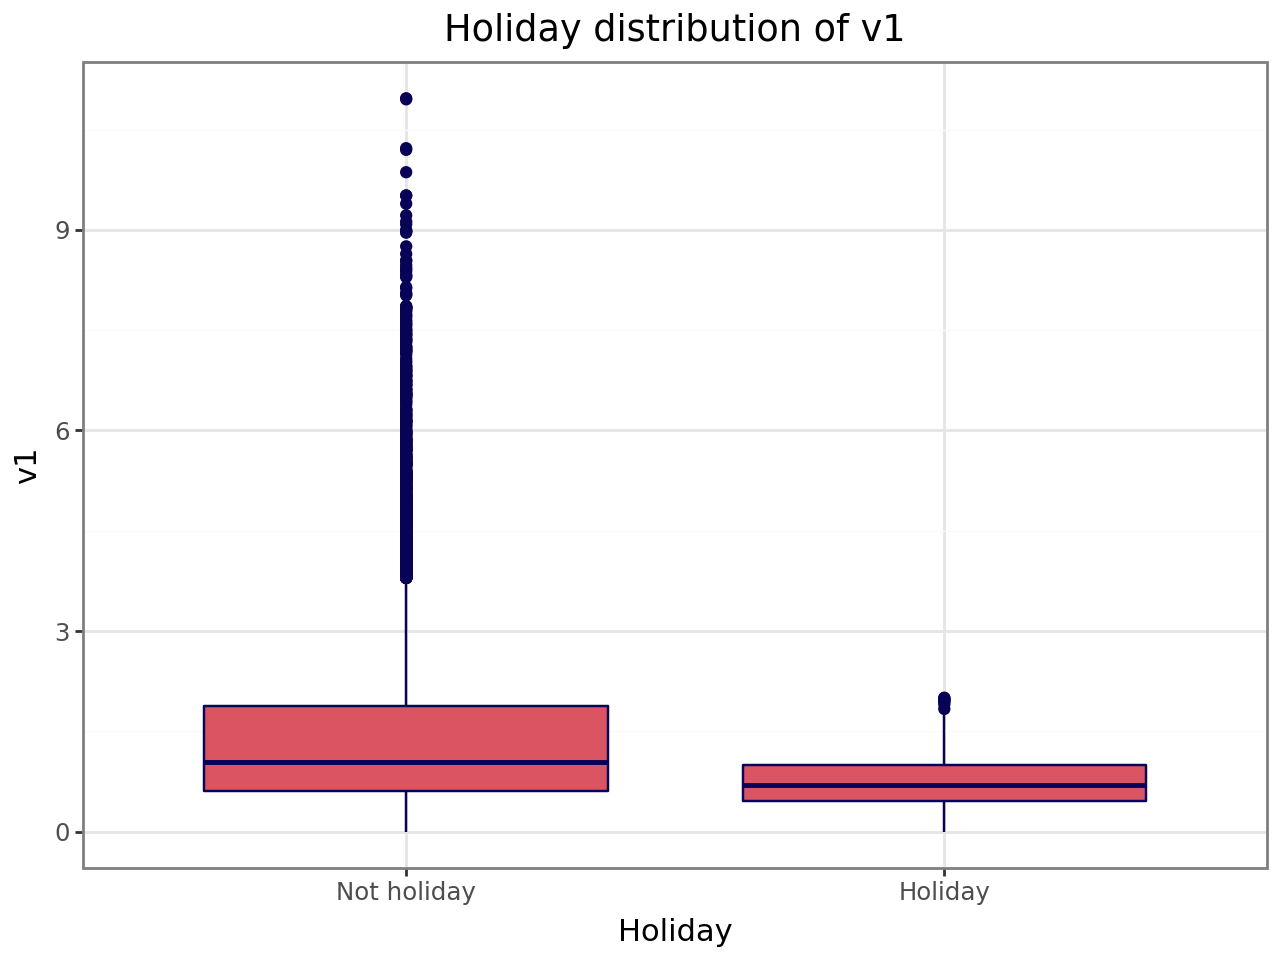

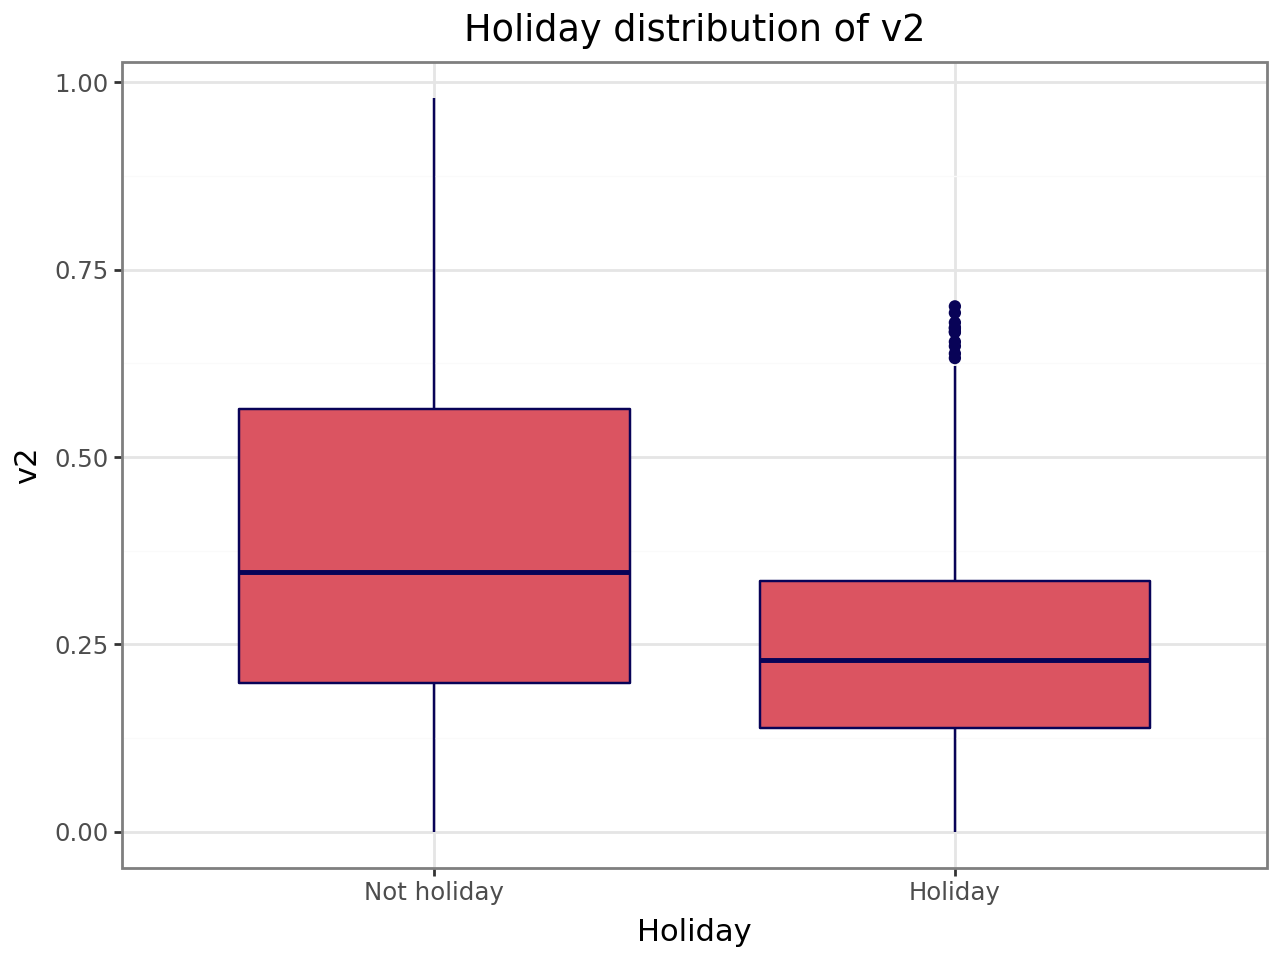

In [58]:
display(
    ggplot(data, aes(x='is_holiday.astype("category")', y = 'v1'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = ['Not holiday', 'Holiday'])
    + labs(x = 'Holiday', title = 'Holiday distribution of v1')
)

display(
    ggplot(data, aes(x='is_holiday.astype("category")', y = 'v2'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = ['Not holiday', 'Holiday'])
    + labs(x = 'Holiday', title = 'Holiday distribution of v2')
)

We can also exmine whether holidays have different effects depending on what day of the week day fall on. We can see that the drop is the largest on weekdays, slightly smaller on Fridays, and practically nonexistent on weekends.

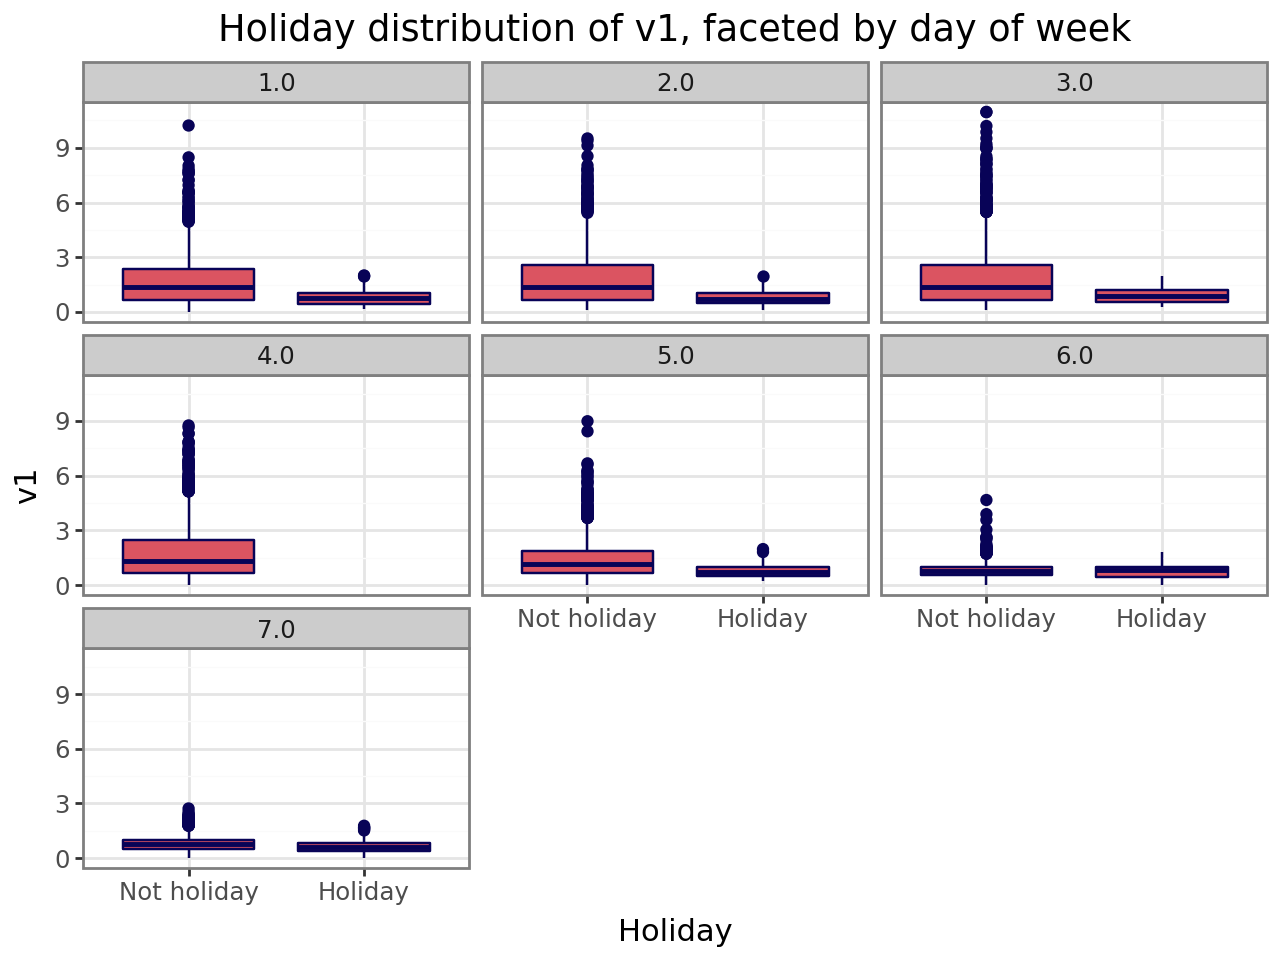

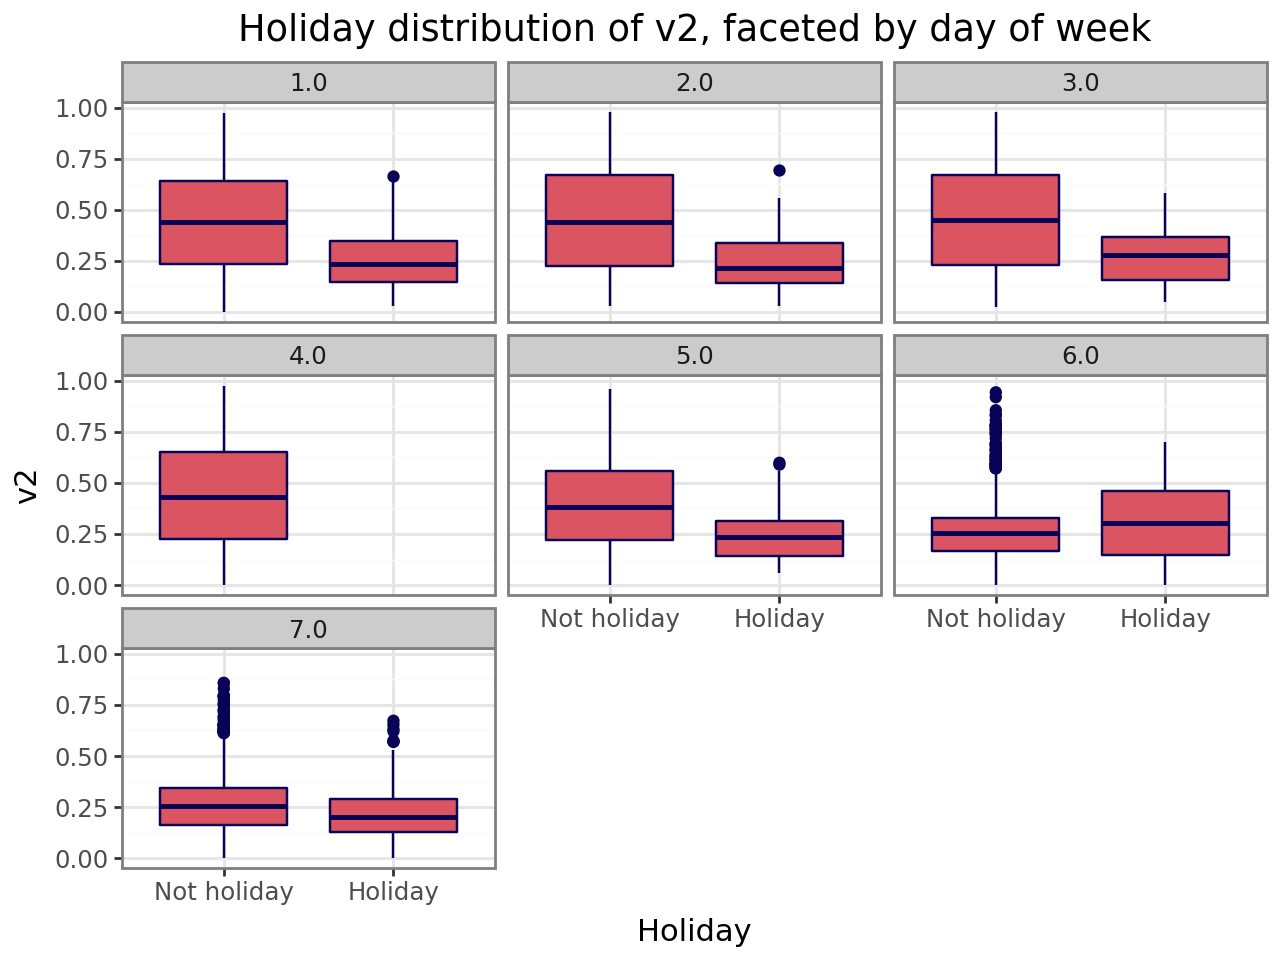

In [80]:
display(
    ggplot(data, aes(x='is_holiday.astype("category")', y = 'v1'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = ['Not holiday', 'Holiday'])
    + labs(x = 'Holiday', title = 'Holiday distribution of v1, faceted by day of week')
    + facet_wrap('~dow')
)

display(
    ggplot(data, aes(x='is_holiday.astype("category")', y = 'v2'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = ['Not holiday', 'Holiday'])
    + labs(x = 'Holiday', title = 'Holiday distribution of v2, faceted by day of week')
    + facet_wrap('~dow')
)

Most importantly, there are very apparent differences in the hourly distributions.

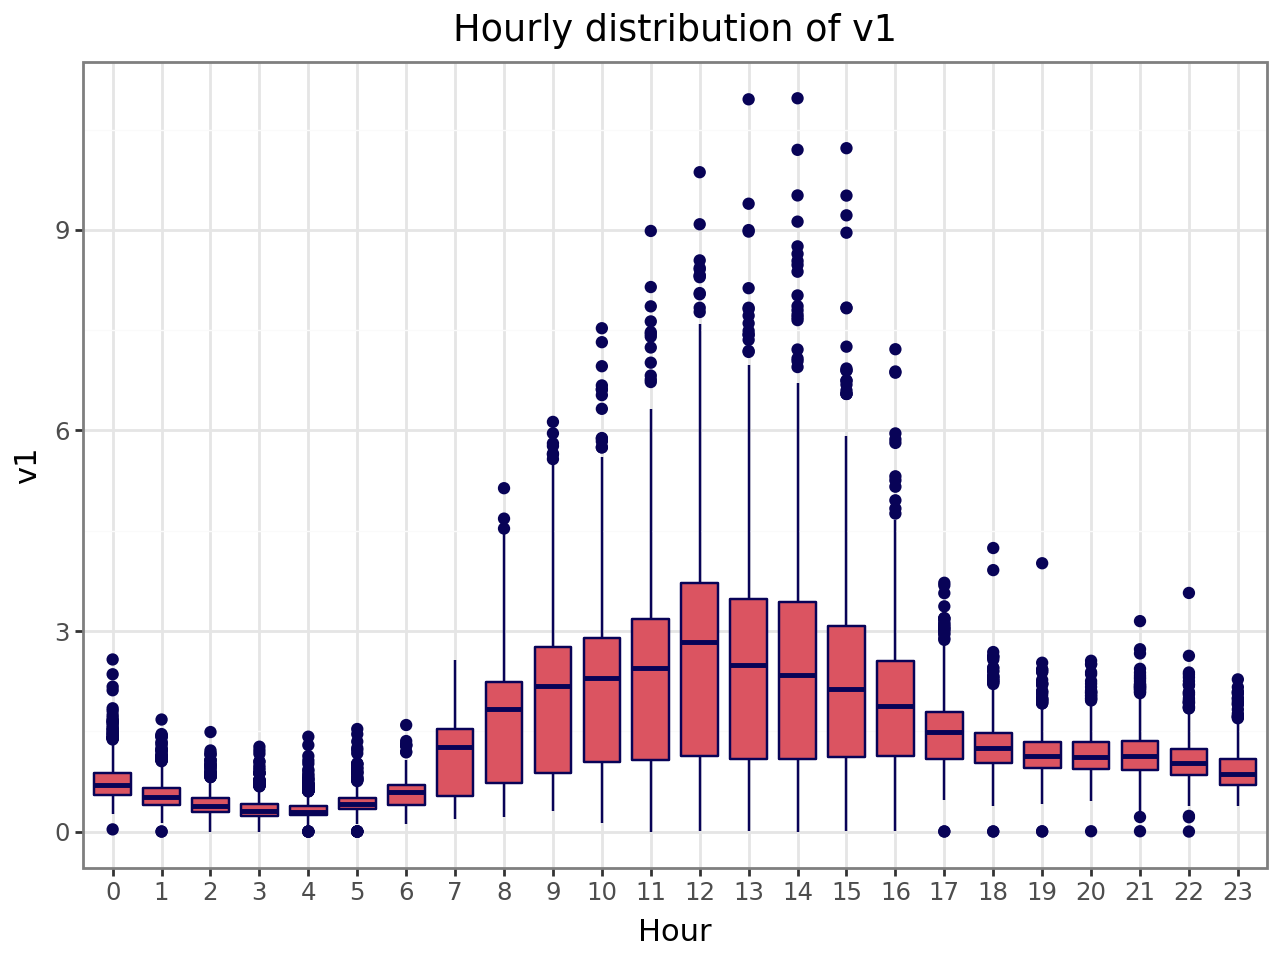

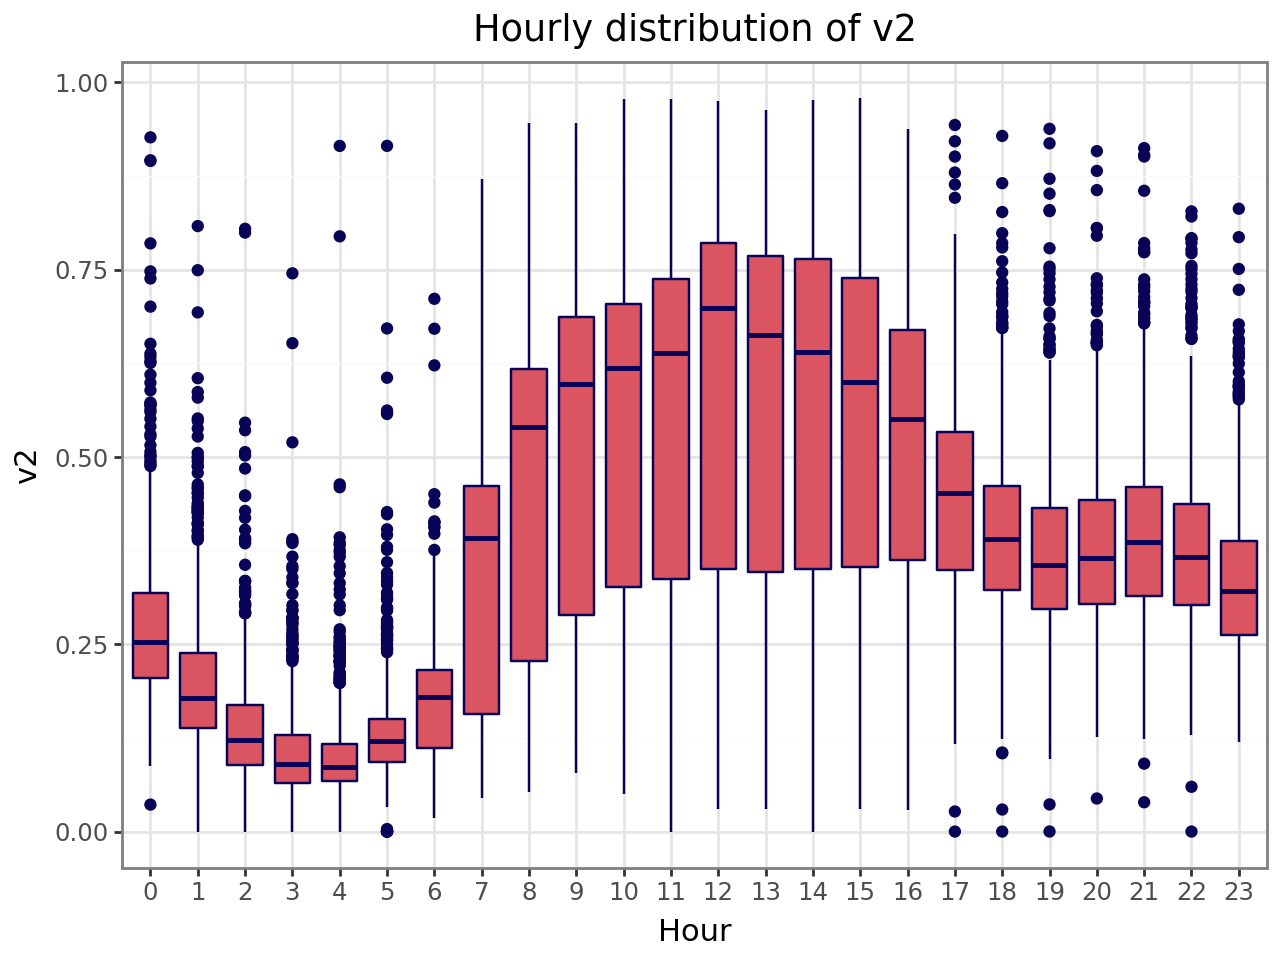

In [54]:
display(
    ggplot(data, aes(x='hour.astype("category")', y = 'v1'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = range(0, 24))
    + labs(x = 'Hour', title = 'Hourly distribution of v1')
)

display(
    ggplot(data, aes(x='hour.astype("category")', y = 'v2'))
    + geom_boxplot(fill=color[0], color=color[1], outlier_color = color[1])
    + theme_bw()
    + scale_x_discrete(labels = range(0, 24))
    + labs(x = 'Hour', title = 'Hourly distribution of v2')
)

But simply looking at distributions broken down by one variable may not tell the full story, as there may be some important interaction effects going on. To uncover these, we can look at some heatmaps for all the possible variable combinations (except day of week x weekend, as these are mutually exclusive). From the plots below, we can see the following:

- month x day of month: there seems to be no interaction;
- month x hour of the day: it seems that how much the series peak during the day is quite different in January, July, August, and December, so there is an interaction;
- month x day of week: similar differences as previously, so there is an interaction;
- month x weekend: quite similar differences between weekdays and weekends, and even if there is an interaction, it may already be captured by the previous interaction;
- month x holiday: same as before, and moreover, some months do not even have holidays;
- day of the month x hour of the day: very similar patterns all across, thus no interaction needed;
- day of month x day of week: same as above, no interactions;
- day of month x weekend: same as above, no interaction;
- day of month x holiday: same as above, no interaction;
- hour of the day x day of week: on Fridays and weekends the patterns are quite different, thus there is an interaction;
- hour of the day x weekend: because of the above, there is a difference here as well, but it may be already captured by the previous interaction;
- hour of the day x holiday: holidays seem to have different patterns, so there is an interaction;
- day of week x holiday: similarly to above, there seems to be an interaction;
- weekend x holiday: important differences, so there may be an interaction (but this may be captured by the previous interaction).

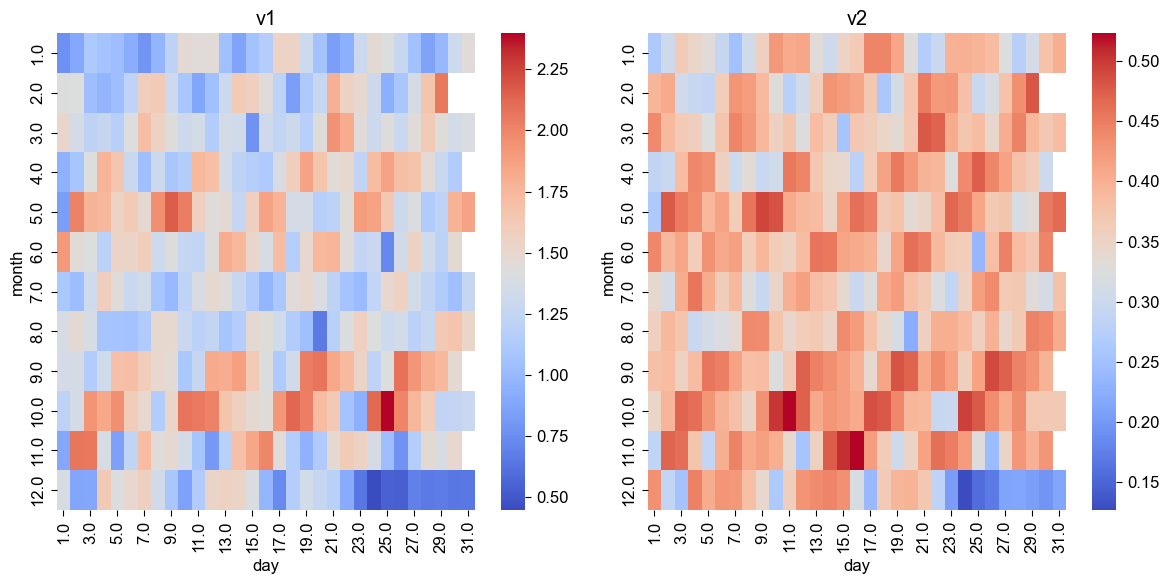

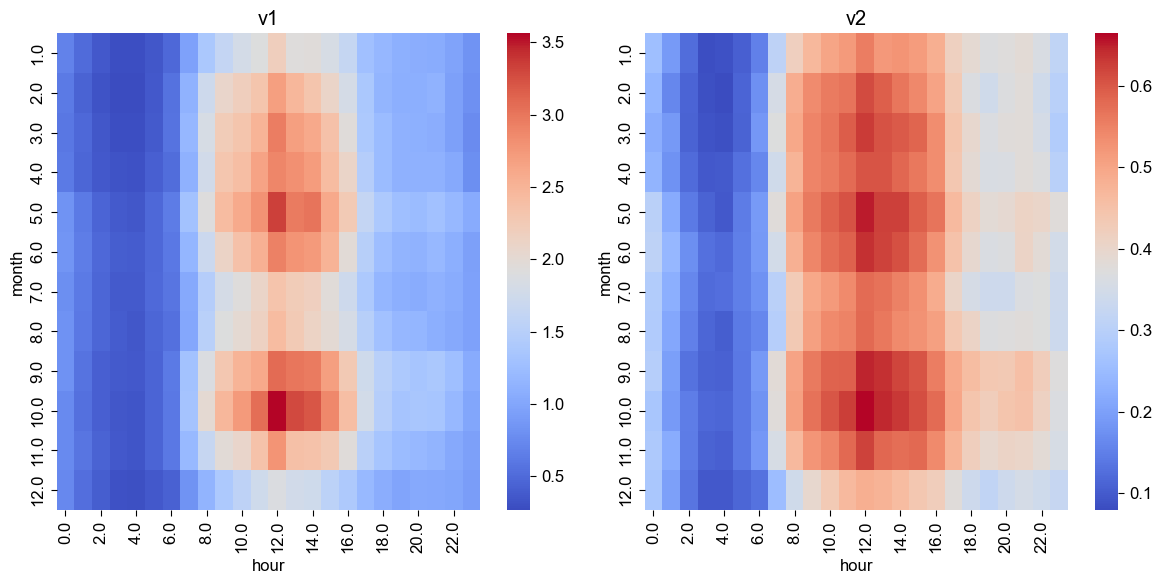

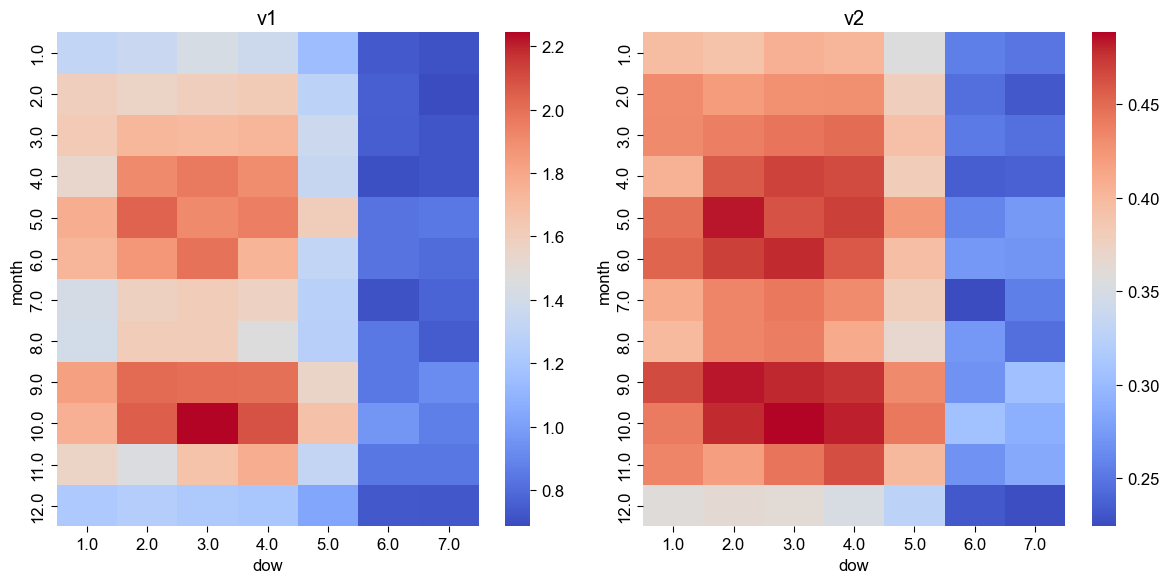

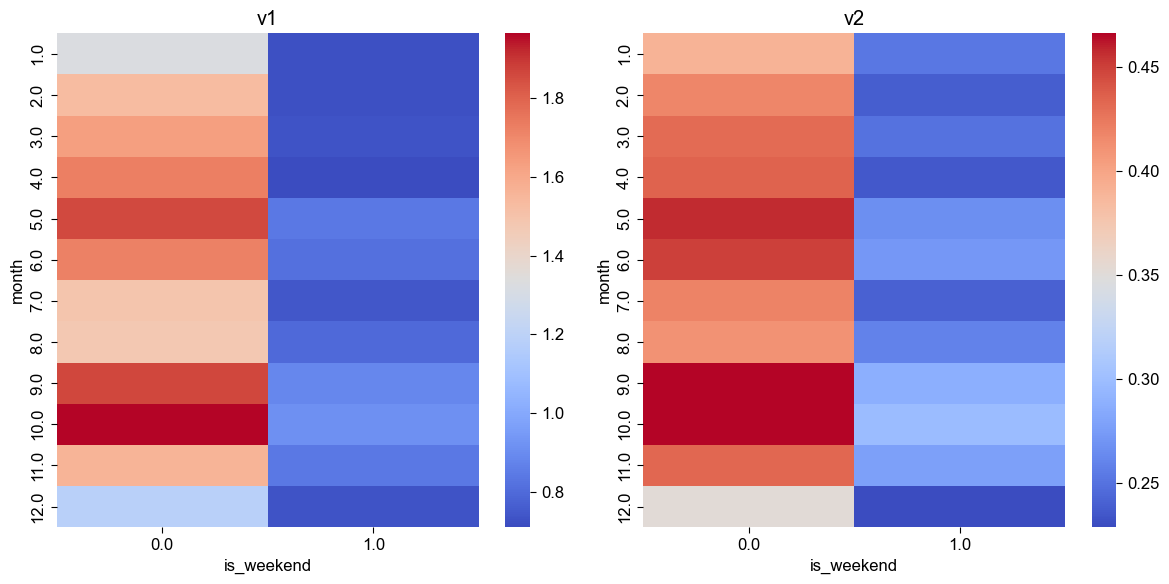

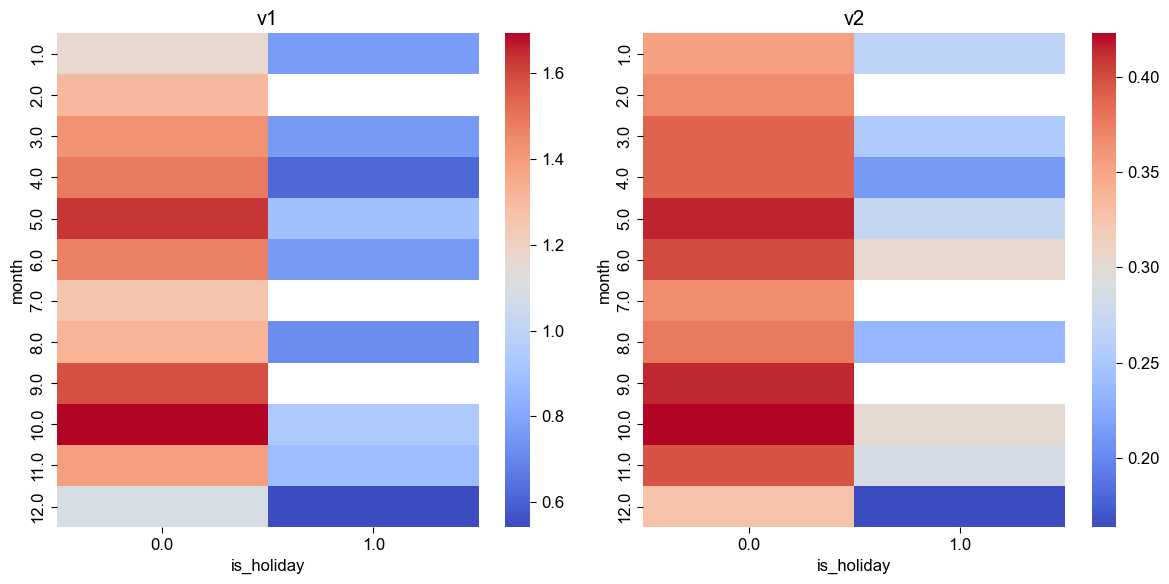

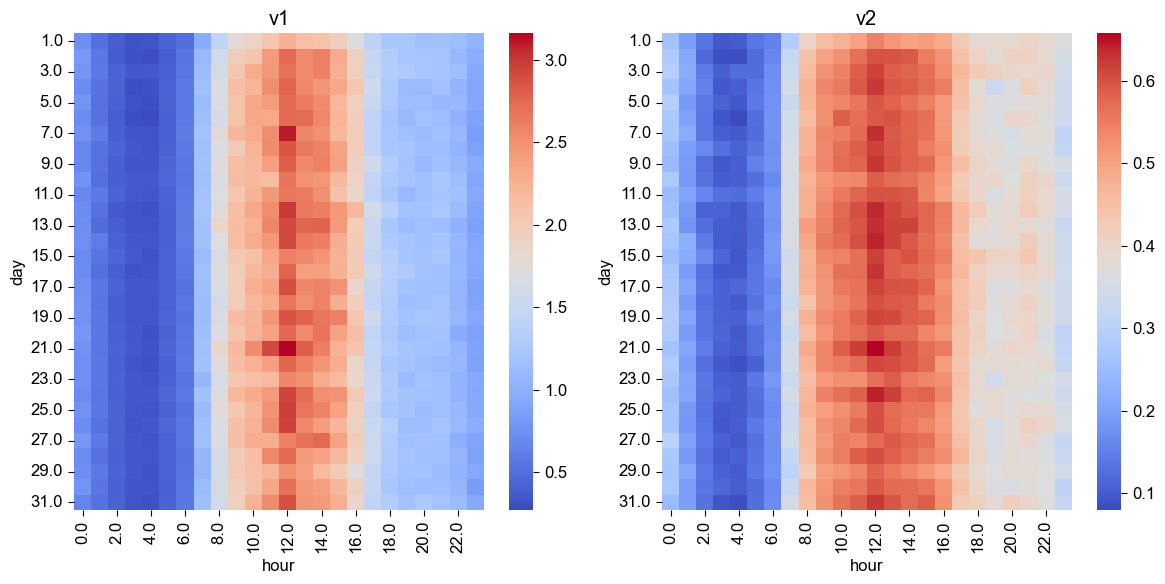

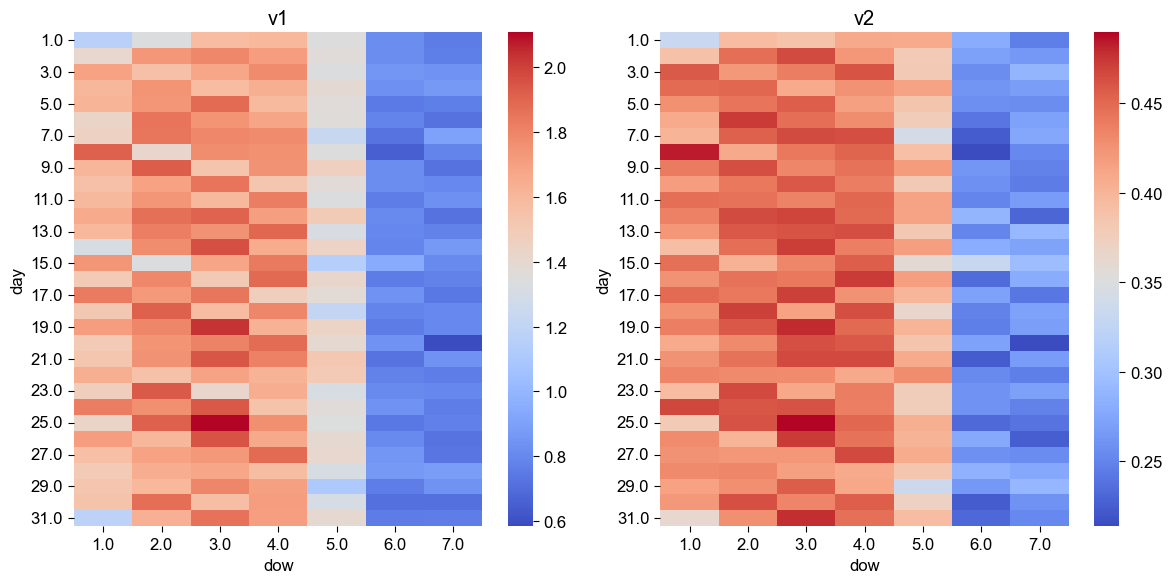

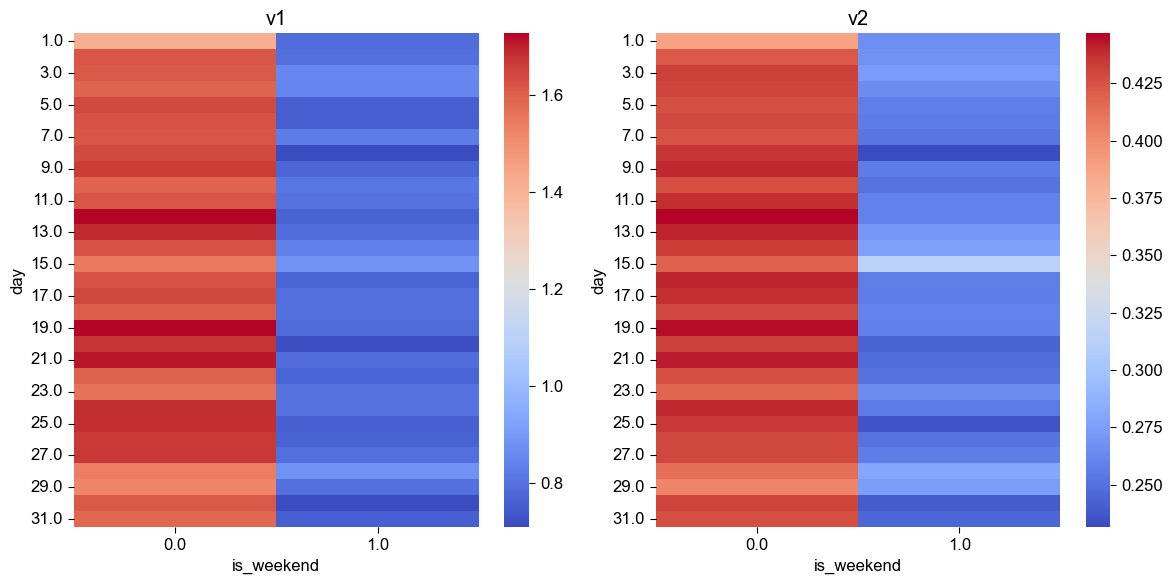

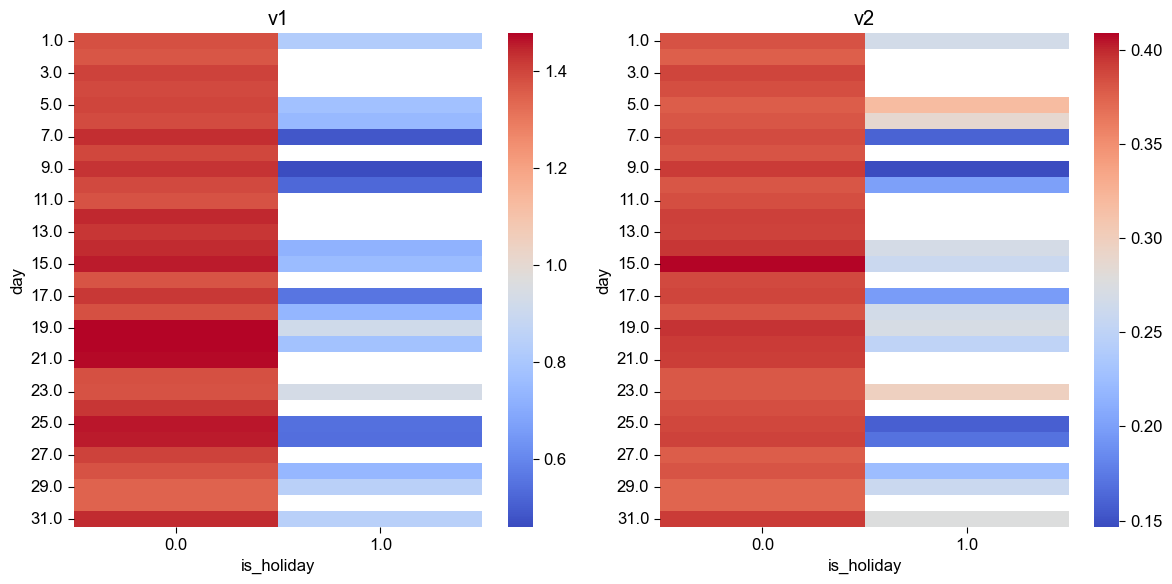

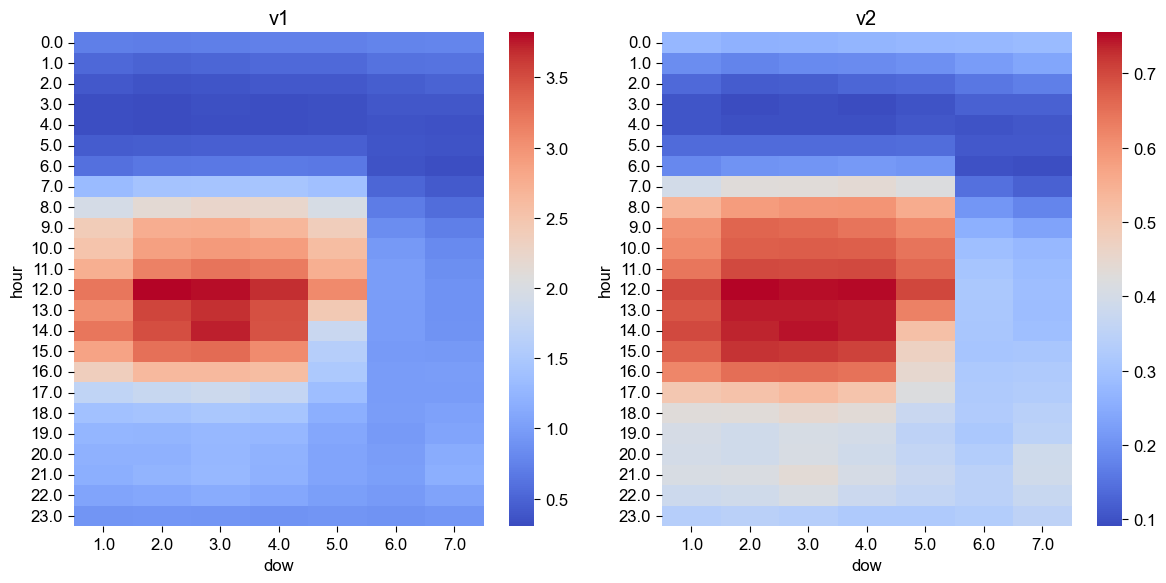

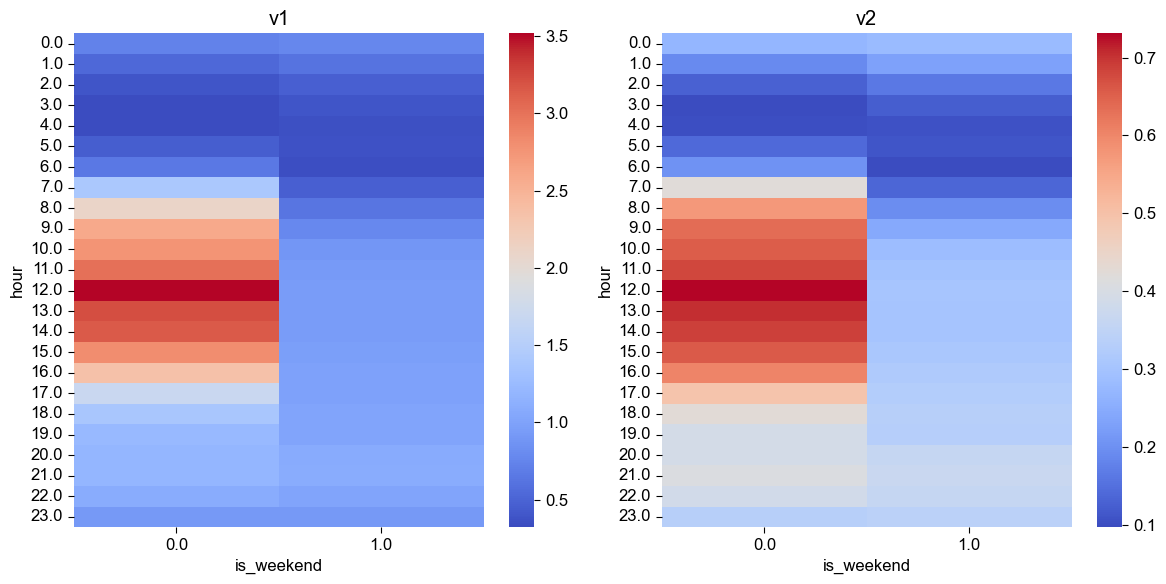

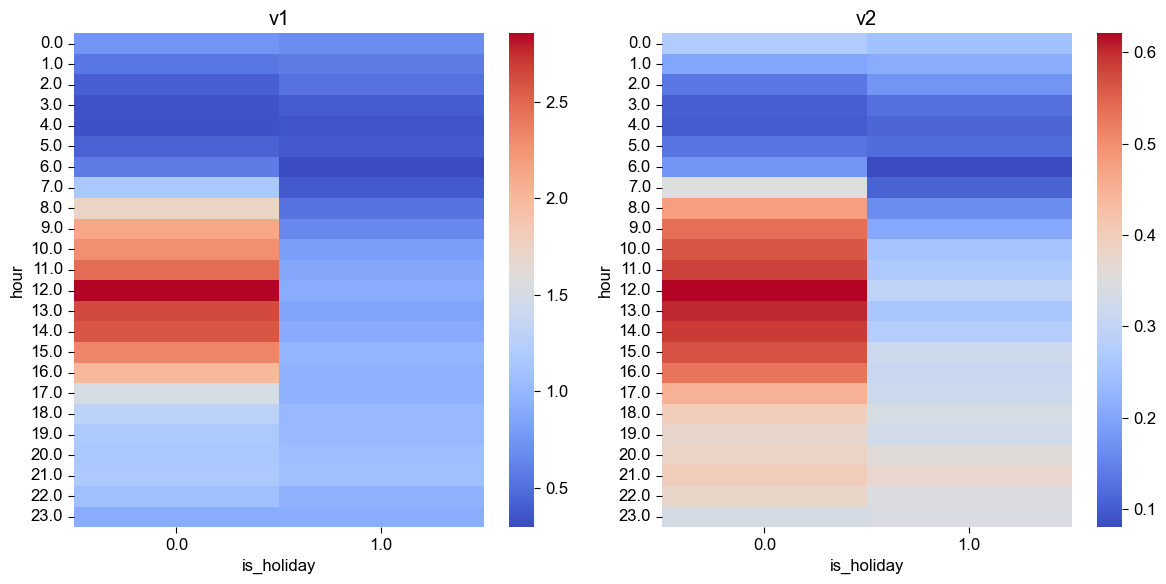

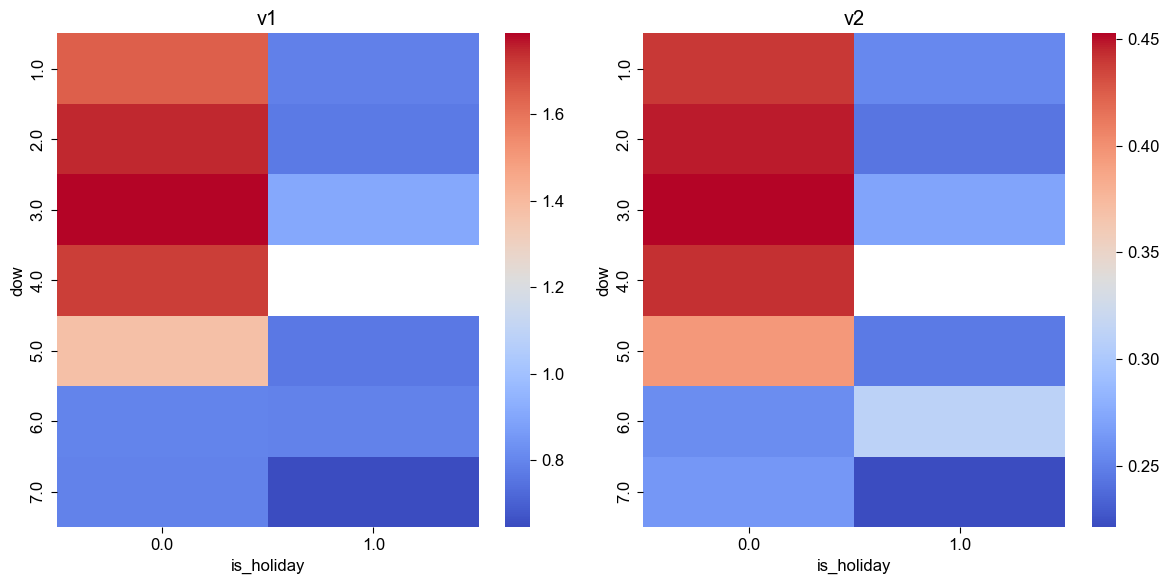

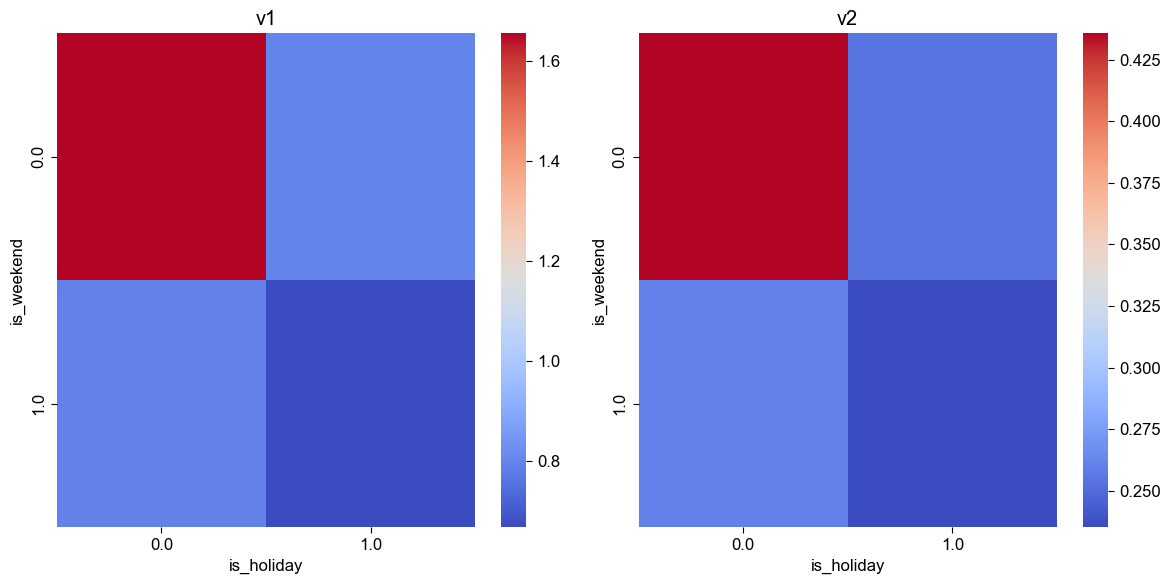

In [15]:
time_vars = ['month', 'day', 'hour', 'dow', 'is_weekend', 'is_holiday']
for i in range(len(time_vars)):
    for j in range(i + 1, len(time_vars)):
        if not (time_vars[i] == 'dow' and time_vars[j] == 'is_weekend'):
            fig, axes = plt.subplots(1, 2, figsize=(12, 6))
            sns.heatmap(
                data = data.pivot_table(index=time_vars[i], columns=time_vars[j], values="v1", aggfunc='mean'), 
                cmap = 'coolwarm',
                ax = axes[0])
            axes[0].set_title('v1')
            sns.heatmap(
                data = data.pivot_table(index=time_vars[i], columns=time_vars[j], values="v2", aggfunc='mean'), 
                cmap = 'coolwarm',
                ax = axes[1])
            axes[1].set_title('v2')
            plt.tight_layout()
            plt.show()

Based on the above, we can define the following interaction terms: `month x hour`, `month x dow`, `hour x dow`, `hour x is_holiday`, `dow x is_holiday`. However, if we were to include all these interactions (as well as the needed categories with dummies), we would have more than 600 dummy features in our dataset. This may be too much given that our training set will have around 25K observations. So, instead, let's create some groupings based on the above heatmaps.

Note, that in Prophet models we will not model these as interactions, but rather conditional seasonalities (that is e.g. different hourly seasonality by part of the year).

In [19]:
# part of year (month)
data['is_winter'] = data['month'].apply(lambda x: 1 if x in [12, 1] else 0)
data['is_summer'] = data['month'].apply(lambda x: 1 if x in [7, 8] else 0)
data['is_not_win_sum'] = data['month'].apply(lambda x: 1 if x in [2, 3, 4, 5, 6, 9, 10, 11] else 0)
# part of day (hour)
data['is_working_hours'] = data['hour'].apply(lambda x: 1 if x in range(8, 18) else 0)
data['is_off_hours'] = data['hour'].apply(lambda x: 1 if x in range(0, 8) or x in range(18, 24) else 0)
# part of week (plus is_weekend) (dow)
data['is_friday'] = data['dow'].apply(lambda x: 1 if x == 5 else 0)
data['is_weekday'] = data['dow'].apply(lambda x: 1 if x in range(1, 5) else 0)
# holiday x part of week
data['is_holiweekday'] = data['is_holiday'] * ((data['is_weekday'] + data['is_friday']) > 0).astype(int)
data['is_holiweekend'] = data['is_holiday'] * data['is_weekend']

As Prophet models cannot handle two conditional seasonalities by the same condition (e.g. different daily and weekly seasonality based on the part of the year), I duplicate some variables.

In [20]:
data['is_winter2'] = data['is_winter']
data['is_summer2'] = data['is_summer']
data['is_not_win_sum2'] = data['is_not_win_sum']

Let's also create seasonal interaction variables for our non-Prophet models.

In [21]:
# month x hour
data['winter_x_working_hours'] = data['is_winter'] * data['is_working_hours']
data['summer_x_working_hours'] = data['is_summer'] * data['is_working_hours']
# month x dow
data['winter_x_friday'] = data['is_winter'] * data['is_friday']
data['summer_x_friday'] = data['is_summer'] * data['is_friday']
data['winter_x_weekend'] = data['is_winter'] * data['is_weekend']
data['summer_x_weekend'] = data['is_summer'] * data['is_weekend']
# hour x dow
data['working_hours_x_friday'] = data['is_working_hours'] * data['is_friday']
data['working_hours_x_weekend'] = data['is_working_hours'] * data['is_weekend']
# hour x is_holiday
data['working_hours_x_holiday'] = data['is_working_hours'] * data['is_holiday']
# dow x is_holiday -> already created by e.g. is_holiweekday


I create dummies from the month, day of week, and hour variables (that have shown seasonal patterns).

In [22]:
data = pd.concat([
    data, 
    pd.get_dummies(data['month'], prefix='month', drop_first=True).astype(int),
    pd.get_dummies(data['dow'], prefix='dow', drop_first=True).astype(int),
    pd.get_dummies(data['hour'], prefix='hour', drop_first=True).astype(int)
], axis=1)

In [23]:
data.to_pickle('data_prepped.pkl')

# RUN FROM HERE FOR PREPPED DATA

In [2]:
data = pd.read_pickle('data_prepped.pkl')

Now we can define the train and holdout sets. I reserve the last month in my sample as a hold-out set.

In [3]:
data_holdout = data[(data['year'] == 2024) & (data['month'] == 10)]
data_train = data[(data['year'] != 2024) | (data['month'] != 10)]

The training set will be split into 5 equal sized groups, while retaining the the time series ordering. This is the inserted test sets approach, meaning that data both before and after the test set will be used to train each cross-validation fold.

In [4]:
logo = LeaveOneGroupOut()
groups = data_train.index.to_numpy() // int(np.floor(data_train.shape[0]/5))
groups[groups == 5] = 4

In [5]:
np.unique(groups, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([4819, 4819, 4819, 4819, 4820], dtype=int64))

# RUN THE FOLLOWING CHUNKS ONLY IF RE-TUNING PROPHET MODELS

Now we can cross-validate some Prophet models. I will CV two parameters suggested by the docs (these effectively regularize seasonality strength), the fourier order of conditional seasonalities and the variable to use for the analysis. I will not cross-validate the regularization for the trend line, as I fit models without a trend line. I do this because even though they would provide better in-sample fits, they might overfit on noise (as we have seen that there is trend in either of the variables).

I turn the default weekly and daily seasonalities off as I create conditional seasonalities for these. I will cross-validate the models with a self-made function to allow parallel processing.

In [7]:
month_daily_interactions = [{'name':'winter_daily','period':1,'condition_name':'is_winter'},{'name':'summer_daily','period':1,'condition_name':'is_summer'},
                            {'name':'not_win_sum_daily','period':1,'condition_name':'is_not_win_sum'}]
month_weekly_interactions = [{'name':'winter_weekly','period':7,'condition_name':'is_winter2'},{'name':'summer_weekly','period':7,'condition_name':'is_summer2'},
                             {'name':'not_win_sum_weekly','period':7,'condition_name':'is_not_win_sum2'}]
dow_interactions = [{'name':'weekday_daily','period':1,'condition_name':'is_weekday'},{'name':'friday_daily','period':1,'condition_name':'is_friday'},
                    {'name':'weekend_daily','period':1,'condition_name':'is_weekend'}]
holiday_interactions = [{'name':'holiweekday_daily','period':1,'condition_name':'is_holiweekday'},{'name':'holiweekend_daily','period':1,'condition_name':'is_holiweekend'}]

In [7]:
param_grid = {  
    #'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1],
    'holidays_prior_scale': [0.1, 1],
    'fourier_order' : [5, 8],
    'complexity':  [month_weekly_interactions, month_weekly_interactions+month_daily_interactions, month_weekly_interactions+month_daily_interactions+dow_interactions,
                    month_weekly_interactions+month_daily_interactions+dow_interactions+holiday_interactions],
    'variable' : ['proph_v1'],

}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [8]:
def evaluate_model(params, df):
    model = (
        Prophet(
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            growth='flat',
            seasonality_mode='additive',
            seasonality_prior_scale=params['seasonality_prior_scale'],
            holidays_prior_scale=params['holidays_prior_scale'])
            .add_country_holidays(country_name='HU')
    )

    df = df.rename(columns={'ts': 'ds', params['variable']: 'y'})

    for cond_season in params['complexity']:
        model.add_seasonality(name=cond_season['name'], period=cond_season['period'], fourier_order=params['fourier_order'], condition_name=cond_season['condition_name'])

    '''model.add_seasonality(name='winter_daily', period=1, fourier_order=params['fourier_order'], condition_name='is_winter')
    model.add_seasonality(name='summer_daily', period=1, fourier_order=params['fourier_order'], condition_name='is_summer')
    model.add_seasonality(name='not_win_sum_daily', period=1, fourier_order=params['fourier_order'], condition_name='is_not_win_sum')
    model.add_seasonality(name='winter_weekly', period=7, fourier_order=params['fourier_order'], condition_name='is_winter2')
    model.add_seasonality(name='summer_weekly', period=7, fourier_order=params['fourier_order'], condition_name='is_summer2')
    model.add_seasonality(name='not_win_sum_weekly', period=7, fourier_order=params['fourier_order'], condition_name='is_not_win_sum2')
    model.add_seasonality(name='weekday_daily', period=1, fourier_order=params['fourier_order'], condition_name='is_weekday')
    model.add_seasonality(name='weekend_daily', period=1, fourier_order=params['fourier_order'], condition_name='is_weekend')
    model.add_seasonality(name='friday_daily', period=1, fourier_order=params['fourier_order'], condition_name='is_friday')
    model.add_seasonality(name='holiweekday_daily', period=1, fourier_order=params['fourier_order'], condition_name='is_holiweekday')
    model.add_seasonality(name='holiweekend_daily', period=1, fourier_order=params['fourier_order'], condition_name='is_holiweekend')'''

    model.fit(df, algorithm='LBFGS', iter=1000) # for faster results

    df_cv = cross_validation(model, initial='365 days', period='122 days', horizon='30 days', parallel='processes')

    '''if params['variable'].startswith('ln_'): # if the variable is log-transformed, I calculate level RMSE by hand
        df_cv['y_level'] = np.expm1(df_cv['y'])
        corrb = mean_squared_error(df_cv['y'] , df_cv['yhat'])
        df_cv['yhat_level'] = np.exp(df_cv['yhat'] + corrb/2) - 1
        level_rmses = []
        for c in df_cv.cutoff.unique():
            level_rmses.append(mean_squared_error(df_cv.loc[df_cv['cutoff'] == c, 'y_level'], df_cv.loc[df_cv['cutoff'] == c, 'yhat_level'], squared=False))
        rmse = np.mean(level_rmses)
    else: # else I use the built-in function'''
    df_p = performance_metrics(df_cv, rolling_window=1, metrics=['rmse'])
    rmse = df_p['rmse'].values[0]
    
    return rmse

Cross-validating the model for v1.

In [11]:
rmses = Parallel(n_jobs=7, verbose=10)(delayed(evaluate_model)(params, data_train) for params in all_params)
v1_tuning_results = pd.DataFrame(all_params)
v1_tuning_results['rmse'] = rmses

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:  4.5min
[Parallel(n_jobs=7)]: Done  23 out of  32 | elapsed:  5.8min remaining:  2.3min
[Parallel(n_jobs=7)]: Done  27 out of  32 | elapsed:  6.0min remaining:  1.1min
[Parallel(n_jobs=7)]: Done  32 out of  32 | elapsed:  6.7min finished


In [26]:
v1_tuning_results.to_pickle('v1_prophet_tuning_results.pkl')

Cross-validating the model for v2.

In [13]:
param_grid = {  
    #'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1],
    'holidays_prior_scale': [0.1, 1],
    'fourier_order' : [5, 8],
    'complexity':  [month_weekly_interactions, month_weekly_interactions+month_daily_interactions, month_weekly_interactions+month_daily_interactions+dow_interactions,
                    month_weekly_interactions+month_daily_interactions+dow_interactions+holiday_interactions],
    'variable' : ['proph_v2'],

}
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [14]:
rmses = Parallel(n_jobs=7, verbose=10)(delayed(evaluate_model)(params, data_train) for params in all_params)
v2_tuning_results = pd.DataFrame(all_params)
v2_tuning_results['rmse'] = rmses

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:   57.6s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done  18 tasks      | elapsed:  3.6min
[Parallel(n_jobs=7)]: Done  23 out of  32 | elapsed:  5.0min remaining:  1.9min
[Parallel(n_jobs=7)]: Done  27 out of  32 | elapsed:  5.3min remaining:   59.3s
[Parallel(n_jobs=7)]: Done  32 out of  32 | elapsed:  6.1min finished


In [16]:
v2_tuning_results.to_pickle('v2_prophet_tuning_results.pkl')

# RUN FROM HERE

I import the saved cross-validation results.

In [83]:
v1_tuning_results = pd.read_pickle('v1_prophet_tuning_results.pkl')
v2_tuning_results = pd.read_pickle('v2_prophet_tuning_results.pkl')

In [84]:
v1_best_params = v1_tuning_results.loc[v1_tuning_results['rmse'].idxmin()]
v2_best_params = v2_tuning_results.loc[v2_tuning_results['rmse'].idxmin()]

The best parameters are the following. Note that the complexity parameter, though not visible, is the most complex set-up for both variables.

In [85]:
v1_best_params

seasonality_prior_scale                                                 0.01
holidays_prior_scale                                                     0.1
fourier_order                                                              8
complexity                 [{'name': 'winter_weekly', 'period': 7, 'condi...
variable                                                            proph_v1
rmse                                                                0.478601
Name: 7, dtype: object

In [86]:
v2_best_params

seasonality_prior_scale                                                  0.1
holidays_prior_scale                                                     0.1
fourier_order                                                              8
complexity                 [{'name': 'winter_weekly', 'period': 7, 'condi...
variable                                                            proph_v2
rmse                                                                 0.09335
Name: 23, dtype: object

Now let's rebuild the two models using the whole training set.

In [87]:
v1_prophet_model = (
    Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        growth='flat',
        seasonality_mode='additive',
        **v1_best_params.iloc[:-4].to_dict())
        .add_country_holidays(country_name='HU')
)

for cond_season in v1_best_params['complexity']:
    v1_prophet_model.add_seasonality(name=cond_season['name'], period=cond_season['period'], fourier_order=v1_best_params['fourier_order'], condition_name=cond_season['condition_name'])

v1_prophet_model.fit(data_train.rename(columns={'ts': 'ds', v1_best_params['variable']: 'y'}))

11:49:21 - cmdstanpy - INFO - Chain [1] start processing
11:49:26 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
v2_prophet_model = (
    Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        growth='flat',
        seasonality_mode='additive',
        **v2_best_params.iloc[:-4].to_dict())
        .add_country_holidays(country_name='HU')
)

for cond_season in v2_best_params['complexity']:
    v2_prophet_model.add_seasonality(name=cond_season['name'], period=cond_season['period'], fourier_order=v2_best_params['fourier_order'], condition_name=cond_season['condition_name'])

v2_prophet_model.fit(data_train.rename(columns={'ts': 'ds', v2_best_params['variable']: 'y'}))

11:49:30 - cmdstanpy - INFO - Chain [1] start processing
11:49:33 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
holdout_rmse_dict = {
    'prophet_v1' : -1,
    'prophet_v2' : -1
}
df = data_holdout.rename(columns={'ts': 'ds'})
forecast_v1 = v1_prophet_model.predict(df)
holdout_rmse_dict['prophet_v1'] = mean_squared_error(df['v1'], forecast_v1['yhat'], squared=False)

df = data_holdout.rename(columns={'ts': 'ds'})
forecast_v2 = v2_prophet_model.predict(df)
holdout_rmse_dict['prophet_v2'] = mean_squared_error(df['v2'], forecast_v2['yhat'], squared=False)

In [90]:
print('Best Prophet model for v1:')
print(f'    CV RMSE: {v1_best_params['rmse']:.4f} ({v1_best_params['rmse'] / data_train.proph_v1.mean() * 100:.2f}% of mean)')
print(f'    Hold-out RMSE: {holdout_rmse_dict['prophet_v1']:.4f} ({holdout_rmse_dict['prophet_v1'] / data_holdout.v1.mean() * 100:.2f}% of mean)')
print('\nBest Prophet model for v2:')
print(f'    CV RMSE: {v2_best_params['rmse']:.4f} ({v2_best_params['rmse'] / data_train.proph_v2.mean() * 100:.2f}% of mean)')
print(f'    Hold-out RMSE: {holdout_rmse_dict['prophet_v2']:.4f} ({holdout_rmse_dict['prophet_v2'] / data_holdout.v2.mean() * 100:.2f}% of mean)')

Best Prophet model for v1:
    CV RMSE: 0.4786 (35.89% of mean)
    Hold-out RMSE: 0.3508 (23.37% of mean)

Best Prophet model for v2:
    CV RMSE: 0.0933 (24.80% of mean)
    Hold-out RMSE: 0.1026 (25.48% of mean)


We can also examine graphically how the models perform on the hold-out set - that is, on data for October 2024. It seems that the model learnt the seasonal patterns quite well for both variables: we can see the changes within days generally mathc the actual values, the changes by the day of the week also look good, and the model can even handle the drops due to the 23 October holiday. There are, however, for both models some unexpected fluctuations in the actual value, especially on the week between 7 and 14 October.

In [29]:
forecast_v1.set_index('ds', inplace=True)
forecast_v2.set_index('ds', inplace=True)
df.set_index('ds', inplace=True)

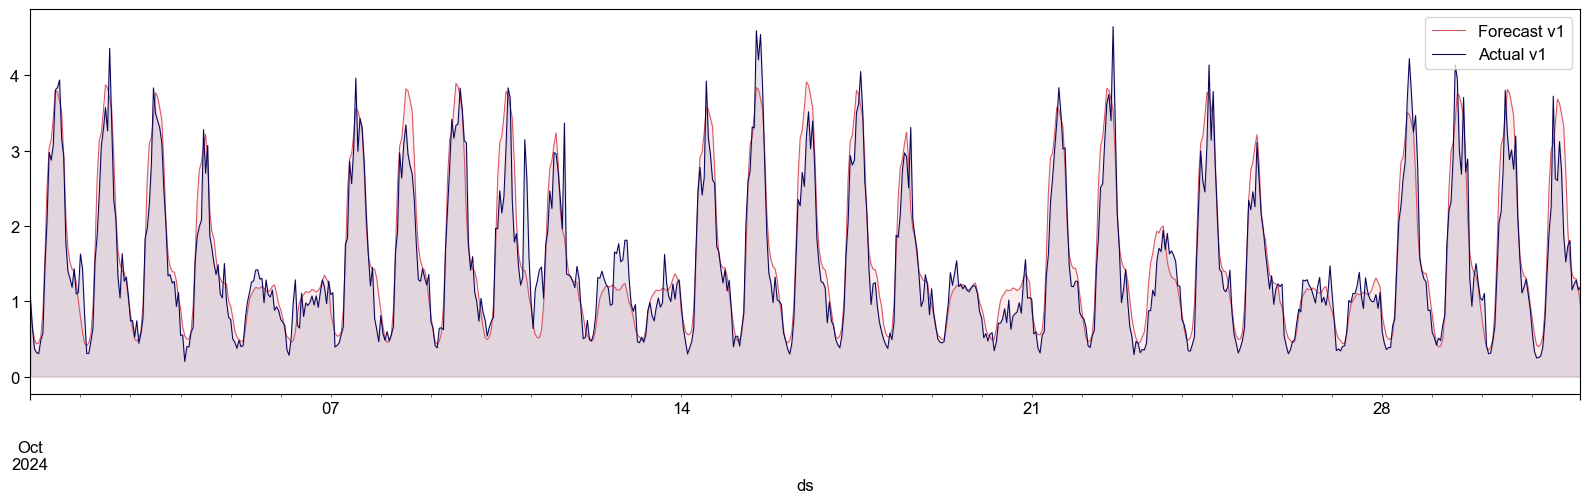

In [31]:
fig, ax = plt.subplots(figsize=(20, 5))
forecast_v1['yhat'].plot(ax=ax, color=color[0], linewidth=0.75, label='Forecast v1')
df['v1'].plot(ax=ax, color=color[1], linewidth=0.75, label='Actual v1')

ax.fill_between(forecast_v1.index, forecast_v1['yhat'], color=color[0], alpha=0.1)
ax.fill_between(df.index, df['v1'], color=color[1], alpha=0.1)
ax.legend()
plt.show()

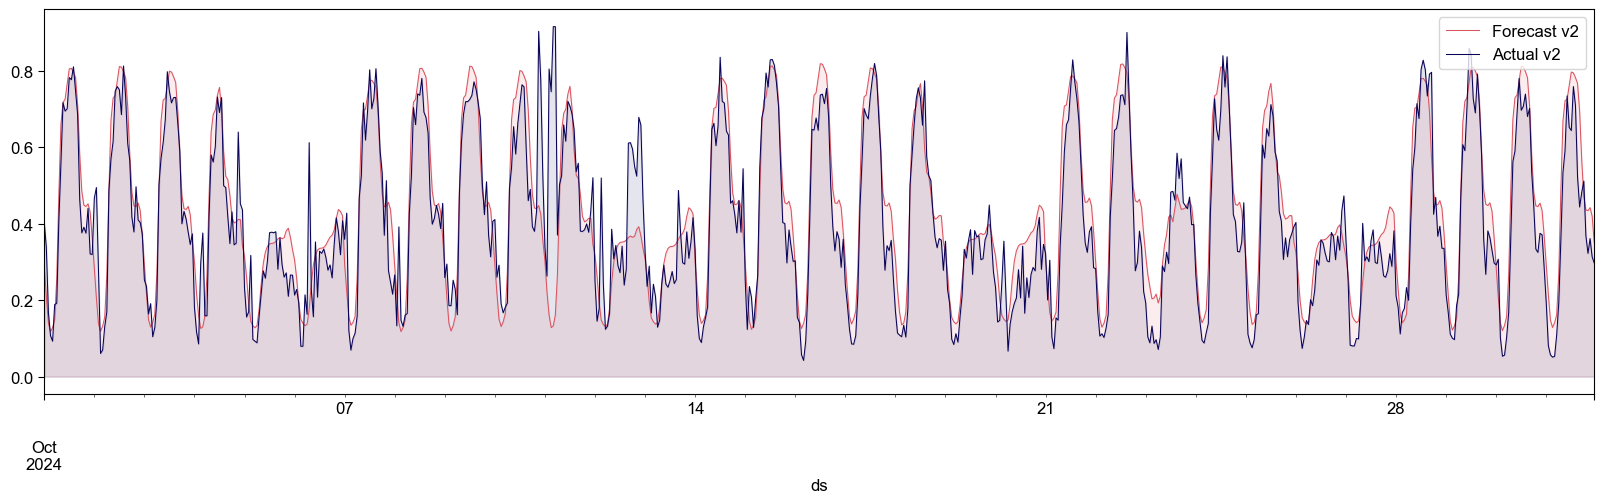

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))
forecast_v2['yhat'].plot(ax=ax, color=color[0], linewidth=0.75, label='Forecast v2')
df['v2'].plot(ax=ax, color=color[1], linewidth=0.75, label='Actual v2')

ax.fill_between(forecast_v2.index, forecast_v2['yhat'], color=color[0], alpha=0.1)
ax.fill_between(df.index, df['v2'], color=color[1], alpha=0.1)
ax.legend()
plt.show()

Let's check again the serial correlation of the residuals from the model (as this model incorporates a lot more factors than when I was previously examining this). As there is still autocorrelation in the residuals, ARIMA models may be justified (either built on the raw data and adding seasonality manually, or by building the models only on the Prophet residuals).

In [33]:
forecast_v1 = v1_prophet_model.predict(data_train.rename(columns = {'ts' : 'ds'}))
forecast_v2 = v2_prophet_model.predict(data_train.rename(columns = {'ts' : 'ds'}))

forecast_v1['resid'] = data_train['v1_imputed'] - forecast_v1['yhat']
forecast_v2['resid'] = data_train['v2_imputed'] - forecast_v2['yhat']

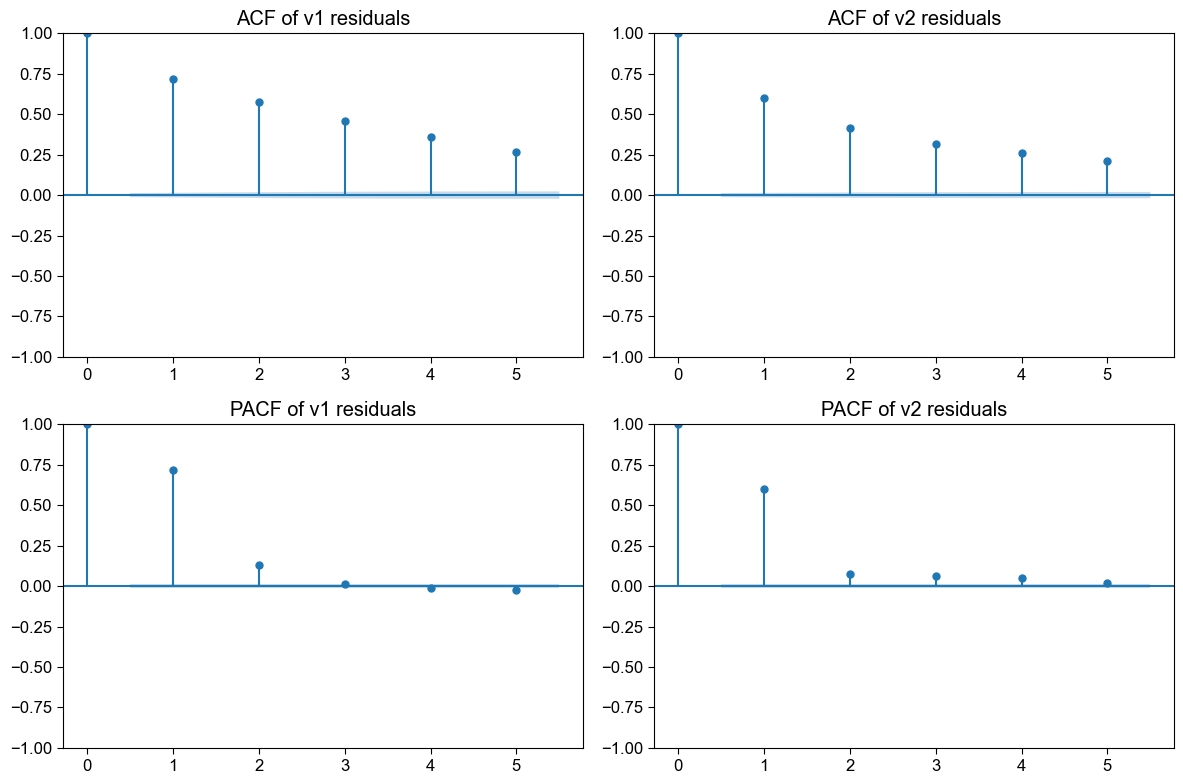

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_acf(forecast_v1['resid'], lags=5, ax=axes[0, 0])
axes[0, 0].set_title('ACF of v1 residuals')

plot_acf(forecast_v2['resid'], lags=5, ax=axes[0, 1])
axes[0, 1].set_title('ACF of v2 residuals')

plot_pacf(forecast_v1['resid'], lags=5, method='yw', ax=axes[1, 0])
axes[1, 0].set_title('PACF of v1 residuals')

plot_pacf(forecast_v2['resid'], lags=5, method='yw', ax=axes[1, 1])
axes[1, 1].set_title('PACF of v2 residuals')

plt.tight_layout()
plt.show()

# TODO

- use Prophet models for imputation and extreme value management - DONE
- build simple deterministic models
- build ARIMA models
- build XGBoost forecaster

As mentioned earlier, Prophet is also a good asset to impute missing values and manage extreme one in our dataset. Thus, I add some new columns which contain the predicted values from the Prophet models if their training value was missing. I will use this variable to train further models.

In [35]:
data_train['proph_v1_pred'] = v1_prophet_model.predict(data_train.rename(columns = {'ts' : 'ds'}))['yhat']
data_train['proph_v2_pred'] = v2_prophet_model.predict(data_train.rename(columns = {'ts' : 'ds'}))['yhat']

data_train['proph_v1_pred'] = data_train.apply(lambda row: row['proph_v1_pred'] if pd.isna(row['proph_v1']) else row['proph_v1'], axis=1)
data_train['proph_v2_pred'] = data_train.apply(lambda row: row['proph_v2_pred'] if pd.isna(row['proph_v2']) else row['proph_v2'], axis=1)

In [36]:
def cross_validate_linear_regression(df, formula, horizon, period=None, initial=None, cutoffs=None, disable_tqdm=False):
    """
    Cross-validation for simple Linear Regression models, similar to Prophet's approach.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the time series data.
    formula : str
        Patsy formula specifying the model (e.g., 'y ~ x1 + x2').
    horizon : str
        Forecast horizon (e.g., '5 days').
    period : str, optional
        Time between cutoffs (default is 0.5 * horizon).
    initial : str, optional
        Minimum amount of data for the first training set (default is 3 * horizon).
    cutoffs : list of pd.Timestamp, optional
        Custom cutoffs for cross-validation.
    disable_tqdm : bool, optional
        If True, disables the progress bar.
    
    Returns
    -------
    pd.DataFrame
        DataFrame with actual values, predictions, and cutoffs.
    """
    df = df.copy().reset_index(drop=True)
    horizon = pd.Timedelta(horizon)
    
    if cutoffs is None:
        period = pd.Timedelta(period) if period else 0.5 * horizon
        initial = pd.Timedelta(initial) if initial else 3 * horizon
        cutoffs = generate_cutoffs(df, horizon, initial, period)
    
    # Generate the design matrix for the whole dataset
    y, X = patsy.dmatrices(formula, df, return_type='dataframe')
    
    # Initialize an empty list to store results
    results = []
    
    for cutoff in (tqdm(cutoffs) if not disable_tqdm else cutoffs):
        # Split the data into train and test sets based on the cutoff
        train = df[df['ds'] <= cutoff]
        test = df[(df['ds'] > cutoff) & (df['ds'] <= cutoff + horizon)]
        
        if train.shape[0] < 2:
            raise ValueError("Not enough data before cutoff. Increase initial window.")
        
        # Use the design matrix to get train and test data
        X_train, y_train = X.loc[train.index], y.loc[train.index]
        X_test, y_test = X.loc[test.index], y.loc[test.index]
        
        # Fit the model
        model = LinearRegression()
        model.fit(X_train, y_train.values.ravel())
        
        # Get predictions
        predictions = model.predict(X_test)
        
        # Store the results in a DataFrame
        result_df = pd.DataFrame({
            'ds': test['ds'].values,
            'yhat': predictions,
            'y': y_test.values.ravel(),
            'cutoff': cutoff
        })
        results.append(result_df)
    
    # Return the concatenated results as a DataFrame
    return pd.concat(results, axis=0).reset_index(drop=True)

def generate_cutoffs(df, horizon, initial, period):
    """Generate cutoff timestamps for cross-validation."""
    max_date = df['ds'].max()
    min_date = df['ds'].min() + initial
    cutoffs = []
    
    while max_date - horizon >= min_date:
        cutoffs.append(max_date - horizon)
        max_date -= period
    
    return list(reversed(cutoffs))


In [65]:
ols_formulas = {
    'M1': 'C(month)+C(dow)+C(hour)',
    'M2': 'C(month)+C(dow)+C(hour)+is_holiday',
    'M3': 'C(month)+C(dow)+C(hour)+is_holiday+winter_x_friday+summer_x_friday+winter_x_weekend+summer_x_weekend',
    'M4': 'C(month)+C(dow)+C(hour)+is_holiday+winter_x_friday+summer_x_friday+winter_x_weekend+summer_x_weekend' +\
        '+winter_x_working_hours+summer_x_working_hours',
    'M5': 'C(month)+C(dow)+C(hour)+is_holiday+winter_x_friday+summer_x_friday+winter_x_weekend+summer_x_weekend' +\
        '+winter_x_working_hours+summer_x_working_hours+working_hours_x_friday+working_hours_x_weekend',
    'M6': 'C(month)+C(dow)+C(hour)+is_holiday+winter_x_friday+summer_x_friday+winter_x_weekend+summer_x_weekend' +\
        '+winter_x_working_hours+summer_x_working_hours+working_hours_x_friday+working_hours_x_weekend' +\
        '+working_hours_x_holiday+is_holiweekday+is_holiweekend',
    'M7': 'C(month)*C(dow)+C(month)*C(hour)+C(dow)*C(hour)*is_holiday'
}

In [70]:
v1_ols_rmses = {}
for code, formula in ols_formulas.items():
    df_cv = cross_validate_linear_regression(data_train.rename(columns={'ts' : 'ds'}), 'proph_v1_pred~'+formula, '30 days',
                                             period='122 days', initial='365 days', disable_tqdm=True)
    cutoff_rmses = []
    for c in df_cv.cutoff.unique():
        cutoff_rmses.append(mean_squared_error(df_cv.loc[df_cv['cutoff'] == c, 'y'], df_cv.loc[df_cv['cutoff'] == c, 'yhat'], squared=False))
    v1_ols_rmses[code] = np.mean(cutoff_rmses)

In [71]:
v1_ols_rmses

{'M1': 0.6260066352978765,
 'M2': 0.6198314643409015,
 'M3': 0.6252524195710251,
 'M4': 0.6353625858514328,
 'M5': 0.5192100340626061,
 'M6': 0.5108985606672742,
 'M7': 0.5082526381772453}

In [72]:
v2_ols_rmses = {}
for code, formula in ols_formulas.items():
    df_cv = cross_validate_linear_regression(data_train.rename(columns={'ts' : 'ds'}), 'proph_v2_pred~'+formula, '30 days',
                                             period='122 days', initial='365 days', disable_tqdm=True)
    cutoff_rmses = []
    for c in df_cv.cutoff.unique():
        cutoff_rmses.append(mean_squared_error(df_cv.loc[df_cv['cutoff'] == c, 'y'], df_cv.loc[df_cv['cutoff'] == c, 'yhat'], squared=False))
    v2_ols_rmses[code] = np.mean(cutoff_rmses)

In [73]:
v2_ols_rmses

{'M1': 0.1251535876038194,
 'M2': 0.12383512083953359,
 'M3': 0.12463470731244215,
 'M4': 0.12549154816105818,
 'M5': 0.10267662859279092,
 'M6': 0.10097300002511837,
 'M7': 0.09647039722814567}

In [77]:
X_ols = patsy.dmatrix(ols_formulas['M7'], data=data, return_type='dataframe')
X_ols_train = X_ols.loc[data_train.index]
X_ols_holdout = X_ols.loc[data_holdout.index]

v1_ols_model = LinearRegression().fit(X_ols_train, data_train['proph_v1_pred'].values.ravel())
v2_ols_model = LinearRegression().fit(X_ols_train, data_train['proph_v2_pred'].values.ravel())

In [98]:
ols_predictions = pd.DataFrame({
    'ts': data_holdout['ts'],
    'v1' : data_holdout['v1'],
    'v2' :  data_holdout['v2'],
    'v1_hat': v1_ols_model.predict(X_ols_holdout),
    'v2_hat': v2_ols_model.predict(X_ols_holdout)
})

ols_results = {
    'v1 CV RMSE' : v1_ols_rmses['M7'],
    'v1 holdout RMSE' : mean_squared_error(ols_predictions['v1'], ols_predictions['v1_hat'], squared=False),
    'v2 CV RMSE' : v2_ols_rmses['M7'],
    'v2 holdout RMSE' : mean_squared_error(ols_predictions['v2'], ols_predictions['v2_hat'], squared=False)
}

In [100]:
print('Best OLS model for v1:')
print(f'    CV RMSE: {ols_results['v1 CV RMSE']:.4f} ({ols_results['v1 CV RMSE'] / data_train.proph_v1.mean() * 100:.2f}% of mean)')
print(f'    Hold-out RMSE: {ols_results['v1 holdout RMSE']:.4f} ({ols_results['v1 holdout RMSE'] / data_holdout.v1.mean() * 100:.2f}% of mean)')
print('\nBest OLS model for v2:')
print(f'    CV RMSE: {ols_results['v2 CV RMSE']:.4f} ({ols_results['v2 CV RMSE'] / data_train.proph_v2.mean() * 100:.2f}% of mean)')
print(f'    Hold-out RMSE: {ols_results['v2 holdout RMSE']:.4f} ({ols_results['v2 holdout RMSE'] / data_holdout.v2.mean() * 100:.2f}% of mean)')

Best OLS model for v1:
    CV RMSE: 0.5083 (38.11% of mean)
    Hold-out RMSE: 0.3934 (26.20% of mean)

Best OLS model for v2:
    CV RMSE: 0.0965 (25.63% of mean)
    Hold-out RMSE: 0.1097 (27.24% of mean)


In [94]:
ols_predictions.set_index('ts', inplace=True)

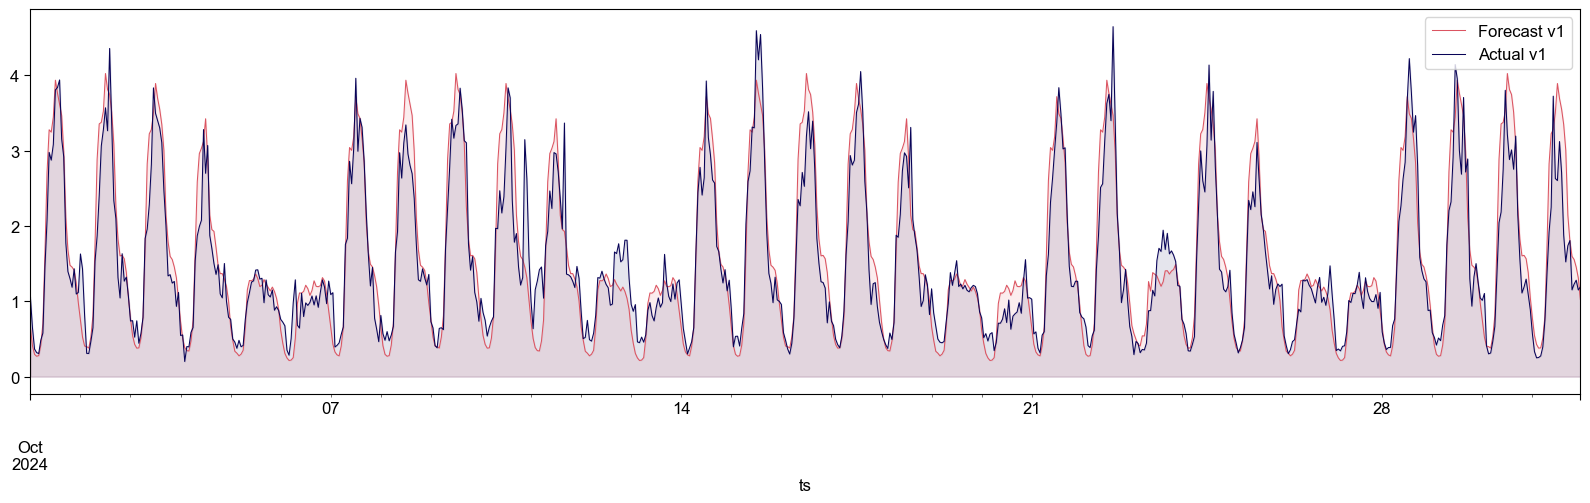

In [95]:
fig, ax = plt.subplots(figsize=(20, 5))
ols_predictions['v1_hat'].plot(ax=ax, color=color[0], linewidth=0.75, label='Forecast v1')
ols_predictions['v1'].plot(ax=ax, color=color[1], linewidth=0.75, label='Actual v1')

ax.fill_between(ols_predictions.index, ols_predictions['v1_hat'], color=color[0], alpha=0.1)
ax.fill_between(ols_predictions.index, ols_predictions['v1'], color=color[1], alpha=0.1)
ax.legend()
plt.show()

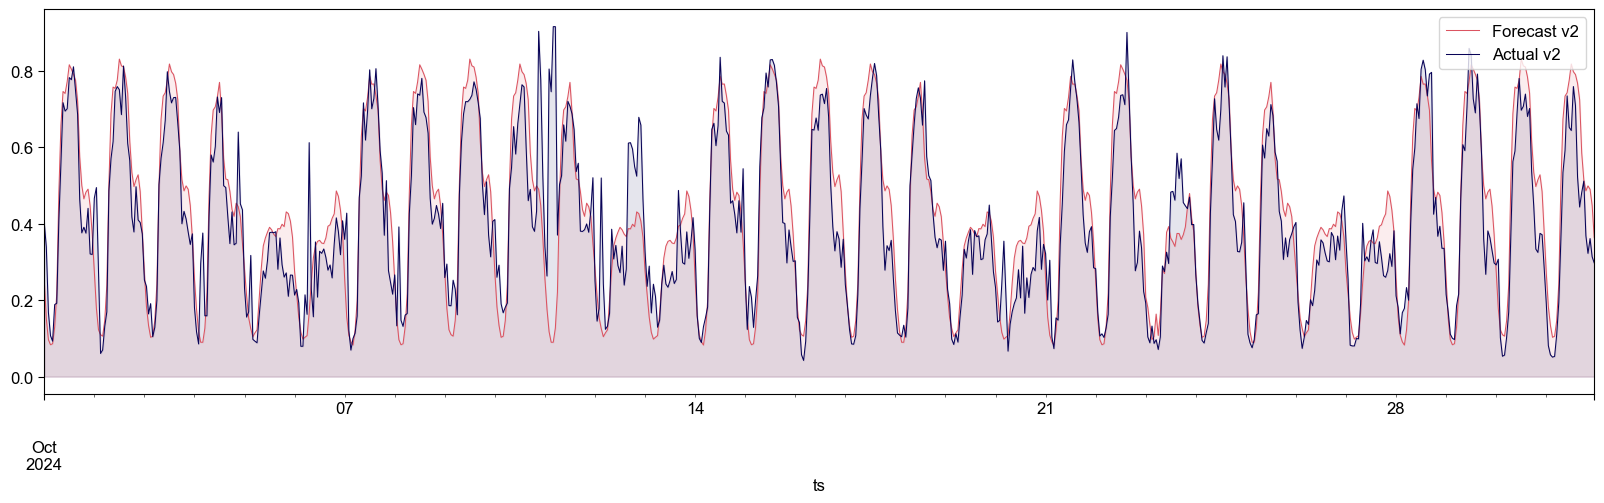

In [96]:
fig, ax = plt.subplots(figsize=(20, 5))
ols_predictions['v2_hat'].plot(ax=ax, color=color[0], linewidth=0.75, label='Forecast v2')
ols_predictions['v2'].plot(ax=ax, color=color[1], linewidth=0.75, label='Actual v2')

ax.fill_between(ols_predictions.index, ols_predictions['v2_hat'], color=color[0], alpha=0.1)
ax.fill_between(ols_predictions.index, ols_predictions['v2'], color=color[1], alpha=0.1)
ax.legend()
plt.show()

Now let's build some ARIMA models. I will build two types: (1) models such that the seasonality dummies and interactions are added as exogenous regressors and (2) models that are simply built on the residuals of the best Prophet models (these will be predicting how much the Prophet models were off, thus they may help refine the previous predictions if added together).